- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        32, 
        activation='swish', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='swish'))
    model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer=Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=512, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/200
4/4 [==============================] - 15s 205ms/step - loss: 0.7077 - accuracy: 0.5714 - auc_roc: 0.5990
Epoch 2/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5882 - accuracy: 0.7160 - auc_roc: 0.7797
Epoch 3/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5792 - accuracy: 0.7182 - auc_roc: 0.7755
Epoch 4/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5400 - accuracy: 0.7238 - auc_roc: 0.8008
Epoch 5/200
4/4 [==============================] - 1s 163ms/step - loss: 0.5409 - accuracy: 0.7447 - auc_roc: 0.8093
Epoch 6/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5166 - accuracy: 0.7440 - auc_roc: 0.8202
Epoch 7/200
4/4 [==============================] - 1s 164ms/step - loss: 0.5320 - accuracy: 0.7332 - auc_roc: 0.8107
Epo

4/4 [==============================] - 1s 242ms/step - loss: 0.4661 - accuracy: 0.7704 - auc_roc: 0.8595
Epoch 69/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4603 - accuracy: 0.7821 - auc_roc: 0.8594
Epoch 70/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4477 - accuracy: 0.7924 - auc_roc: 0.8701
Epoch 71/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4516 - accuracy: 0.7842 - auc_roc: 0.8644
Epoch 72/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4529 - accuracy: 0.7910 - auc_roc: 0.8633
Epoch 73/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4723 - accuracy: 0.7724 - auc_roc: 0.8515
Epoch 74/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4444 - accuracy: 0.7936 - auc_roc: 0.8701
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4385 - accuracy: 0.7949 - auc_roc: 0.8768
Epoch 76/200
4/4 [==============================] - 1s 253ms/step - l

4/4 [==============================] - 1s 217ms/step - loss: 0.4236 - accuracy: 0.8062 - auc_roc: 0.8852
Epoch 138/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4251 - accuracy: 0.8102 - auc_roc: 0.8842
Epoch 139/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4323 - accuracy: 0.8053 - auc_roc: 0.8810
Epoch 140/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4126 - accuracy: 0.8070 - auc_roc: 0.8905
Epoch 141/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4228 - accuracy: 0.7967 - auc_roc: 0.8849
Epoch 142/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4162 - accuracy: 0.8047 - auc_roc: 0.8909
Epoch 143/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4197 - accuracy: 0.8033 - auc_roc: 0.8864
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4187 - accuracy: 0.8156 - auc_roc: 0.8904
Epoch 145/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0002 Epoch 1/200
4/4 [==============================] - 15s 218ms/step - loss: 0.6401 - accuracy: 0.6432 - auc_roc: 0.8290
Epoch 2/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5840 - accuracy: 0.7050 - auc_roc: 0.7670
Epoch 3/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5779 - accuracy: 0.7224 - auc_roc: 0.7713
Epoch 4/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5584 - accuracy: 0.7262 - auc_roc: 0.7844
Epoch 5/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5518 - accuracy: 0.7253 - auc_roc: 0.7900
Epoch 6/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5324 - accuracy: 0.7297 - auc_roc: 0.8027
Epoch 7/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5370 - accuracy: 0.7321 - auc_roc: 0.8019
Epoch 8/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5465 - accuracy: 0.7391 - auc_roc: 0.7924
Epoch 9

4/4 [==============================] - 1s 302ms/step - loss: 0.4687 - accuracy: 0.7731 - auc_roc: 0.8507
Epoch 71/200
4/4 [==============================] - 1s 296ms/step - loss: 0.4514 - accuracy: 0.7931 - auc_roc: 0.8660
Epoch 72/200
4/4 [==============================] - 1s 325ms/step - loss: 0.4642 - accuracy: 0.7769 - auc_roc: 0.8567
Epoch 73/200
4/4 [==============================] - 1s 287ms/step - loss: 0.4696 - accuracy: 0.7792 - auc_roc: 0.8507
Epoch 74/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4689 - accuracy: 0.7811 - auc_roc: 0.8587
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4507 - accuracy: 0.7892 - auc_roc: 0.8666
Epoch 76/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4670 - accuracy: 0.7852 - auc_roc: 0.8515
Epoch 77/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4558 - accuracy: 0.7785 - auc_roc: 0.8621
Epoch 78/200
4/4 [==============================] - 1s 278ms/step - l

4/4 [==============================] - 1s 254ms/step - loss: 0.4292 - accuracy: 0.8097 - auc_roc: 0.8812
Epoch 140/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4349 - accuracy: 0.8033 - auc_roc: 0.8790
Epoch 141/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4306 - accuracy: 0.8034 - auc_roc: 0.8835
Epoch 142/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4265 - accuracy: 0.8042 - auc_roc: 0.8833
Epoch 143/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4391 - accuracy: 0.7958 - auc_roc: 0.8814
Epoch 144/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4375 - accuracy: 0.7987 - auc_roc: 0.8752
Epoch 145/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4223 - accuracy: 0.8114 - auc_roc: 0.8841
Epoch 146/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4208 - accuracy: 0.8079 - auc_roc: 0.8855
Epoch 147/200
4/4 [==============================] - 1s 282ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 42ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0003 Epoch 1/200
4/4 [==============================] - 15s 248ms/step - loss: 0.7667 - accuracy: 0.5405 - auc_roc: 0.8025
Epoch 2/200
4/4 [==============================] - 1s 260ms/step - loss: 0.6049 - accuracy: 0.7124 - auc_roc: 0.7686
Epoch 3/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5883 - accuracy: 0.7157 - auc_roc: 0.7706
Epoch 4/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5855 - accuracy: 0.7007 - auc_roc: 0.7614
Epoch 5/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5638 - accuracy: 0.7164 - auc_roc: 0.7816
Epoch 6/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5651 - accuracy: 0.7227 - auc_roc: 0.7849
Epoch 7/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5445 - accuracy: 0.7292 - auc_roc: 0.7977
Epoch 8/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5508 - accuracy: 0.7259 - auc_roc: 0.7947
Epoch 9

4/4 [==============================] - 1s 266ms/step - loss: 0.4720 - accuracy: 0.7750 - auc_roc: 0.8507
Epoch 71/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4777 - accuracy: 0.7689 - auc_roc: 0.8484
Epoch 72/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4780 - accuracy: 0.7753 - auc_roc: 0.8468
Epoch 73/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4720 - accuracy: 0.7802 - auc_roc: 0.8531
Epoch 74/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4695 - accuracy: 0.7775 - auc_roc: 0.8544
Epoch 75/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4849 - accuracy: 0.7543 - auc_roc: 0.8403
Epoch 76/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4625 - accuracy: 0.7764 - auc_roc: 0.8602
Epoch 77/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4598 - accuracy: 0.7906 - auc_roc: 0.8592
Epoch 78/200
4/4 [==============================] - 1s 241ms/step - l

4/4 [==============================] - 1s 198ms/step - loss: 0.4414 - accuracy: 0.8011 - auc_roc: 0.8777
Epoch 140/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4472 - accuracy: 0.7844 - auc_roc: 0.8719
Epoch 141/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4427 - accuracy: 0.7985 - auc_roc: 0.8737
Epoch 142/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4212 - accuracy: 0.8095 - auc_roc: 0.8861
Epoch 143/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4227 - accuracy: 0.8156 - auc_roc: 0.8850
Epoch 144/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4324 - accuracy: 0.8054 - auc_roc: 0.8806
Epoch 145/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4297 - accuracy: 0.7947 - auc_roc: 0.8813
Epoch 146/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4254 - accuracy: 0.8122 - auc_roc: 0.8860
Epoch 147/200
4/4 [==============================] - 1s 282ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0004 Epoch 1/200
4/4 [==============================] - 28s 257ms/step - loss: 0.6737 - accuracy: 0.6023 - auc_roc: 0.8240
Epoch 2/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5967 - accuracy: 0.7044 - auc_roc: 0.7670
Epoch 3/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5694 - accuracy: 0.7137 - auc_roc: 0.7780
Epoch 4/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5649 - accuracy: 0.7173 - auc_roc: 0.7804
Epoch 5/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5566 - accuracy: 0.7216 - auc_roc: 0.7866
Epoch 6/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5623 - accuracy: 0.7332 - auc_roc: 0.7875
Epoch 7/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5473 - accuracy: 0.7362 - auc_roc: 0.7953
Epoch 8/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5485 - accuracy: 0.7352 - auc_roc: 0.7934
Epoch 

4/4 [==============================] - 1s 220ms/step - loss: 0.4972 - accuracy: 0.7609 - auc_roc: 0.8349
Epoch 71/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4939 - accuracy: 0.7630 - auc_roc: 0.8378
Epoch 72/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4933 - accuracy: 0.7683 - auc_roc: 0.8390
Epoch 73/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4867 - accuracy: 0.7622 - auc_roc: 0.8473
Epoch 74/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4887 - accuracy: 0.7631 - auc_roc: 0.8433
Epoch 75/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4941 - accuracy: 0.7551 - auc_roc: 0.8391
Epoch 76/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4863 - accuracy: 0.7735 - auc_roc: 0.8422
Epoch 77/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4945 - accuracy: 0.7561 - auc_roc: 0.8412
Epoch 78/200
4/4 [==============================] - 1s 257ms/step - l

4/4 [==============================] - 1s 268ms/step - loss: 0.4573 - accuracy: 0.7913 - auc_roc: 0.8658
Epoch 140/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4603 - accuracy: 0.7879 - auc_roc: 0.8644
Epoch 141/200
4/4 [==============================] - 1s 183ms/step - loss: 0.4667 - accuracy: 0.7814 - auc_roc: 0.8591
Epoch 142/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4546 - accuracy: 0.7865 - auc_roc: 0.8683
Epoch 143/200
4/4 [==============================] - 1s 159ms/step - loss: 0.4495 - accuracy: 0.7917 - auc_roc: 0.8734
Epoch 144/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4451 - accuracy: 0.7987 - auc_roc: 0.8755
Epoch 145/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4513 - accuracy: 0.7801 - auc_roc: 0.8712
Epoch 146/200
4/4 [==============================] - 1s 168ms/step - loss: 0.4514 - accuracy: 0.7931 - auc_roc: 0.8715
Epoch 147/200
4/4 [==============================] - 1s 140ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0005 Epoch 1/200
4/4 [==============================] - 23s 274ms/step - loss: 0.7290 - accuracy: 0.6100 - auc_roc: 0.7981
Epoch 2/200
4/4 [==============================] - 1s 299ms/step - loss: 0.5921 - accuracy: 0.7182 - auc_roc: 0.7839
Epoch 3/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5814 - accuracy: 0.7223 - auc_roc: 0.7842
Epoch 4/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5552 - accuracy: 0.7123 - auc_roc: 0.7931
Epoch 5/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5480 - accuracy: 0.7277 - auc_roc: 0.7984
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5295 - accuracy: 0.7520 - auc_roc: 0.8172
Epoch 7/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5593 - accuracy: 0.7322 - auc_roc: 0.7895
Epoch 8/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5270 - accuracy: 0.7464 - auc_roc: 0.8206
Epoch 

4/4 [==============================] - 1s 234ms/step - loss: 0.4612 - accuracy: 0.7848 - auc_roc: 0.8562
Epoch 71/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4560 - accuracy: 0.7742 - auc_roc: 0.8648
Epoch 72/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4490 - accuracy: 0.7835 - auc_roc: 0.8680
Epoch 73/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4528 - accuracy: 0.7921 - auc_roc: 0.8669
Epoch 74/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4631 - accuracy: 0.7744 - auc_roc: 0.8559
Epoch 75/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4601 - accuracy: 0.7917 - auc_roc: 0.8587
Epoch 76/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4499 - accuracy: 0.7835 - auc_roc: 0.8657
Epoch 77/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4563 - accuracy: 0.7882 - auc_roc: 0.8645
Epoch 78/200
4/4 [==============================] - 1s 234ms/step - l

4/4 [==============================] - 1s 224ms/step - loss: 0.4165 - accuracy: 0.8073 - auc_roc: 0.8882
Epoch 140/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4030 - accuracy: 0.8173 - auc_roc: 0.8989
Epoch 141/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4337 - accuracy: 0.8081 - auc_roc: 0.8804
Epoch 142/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4357 - accuracy: 0.8029 - auc_roc: 0.8778
Epoch 143/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4263 - accuracy: 0.8113 - auc_roc: 0.8885
Epoch 144/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4325 - accuracy: 0.8000 - auc_roc: 0.8814
Epoch 145/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4217 - accuracy: 0.8006 - auc_roc: 0.8849
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4065 - accuracy: 0.8135 - auc_roc: 0.8942
Epoch 147/200
4/4 [==============================] - 1s 235ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0006 Epoch 1/200
4/4 [==============================] - 18s 195ms/step - loss: 0.6580 - accuracy: 0.6278 - auc_roc: 0.8294
Epoch 2/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5899 - accuracy: 0.7000 - auc_roc: 0.7705
Epoch 3/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5730 - accuracy: 0.7076 - auc_roc: 0.7741
Epoch 4/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5460 - accuracy: 0.7153 - auc_roc: 0.7945
Epoch 5/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5369 - accuracy: 0.7325 - auc_roc: 0.7983
Epoch 6/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5445 - accuracy: 0.7189 - auc_roc: 0.7969
Epoch 7/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5412 - accuracy: 0.7214 - auc_roc: 0.8003
Epoch 8/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5333 - accuracy: 0.7444 - auc_roc: 0.8045
Epoch 

4/4 [==============================] - 1s 214ms/step - loss: 0.4665 - accuracy: 0.7714 - auc_roc: 0.8578
Epoch 71/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4642 - accuracy: 0.7879 - auc_roc: 0.8573
Epoch 72/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4518 - accuracy: 0.7860 - auc_roc: 0.8696
Epoch 73/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4535 - accuracy: 0.7992 - auc_roc: 0.8684
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4601 - accuracy: 0.7757 - auc_roc: 0.8614
Epoch 75/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4448 - accuracy: 0.7918 - auc_roc: 0.8712
Epoch 76/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4508 - accuracy: 0.7900 - auc_roc: 0.8653
Epoch 77/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4668 - accuracy: 0.7844 - auc_roc: 0.8612
Epoch 78/200
4/4 [==============================] - 1s 196ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.4112 - accuracy: 0.8083 - auc_roc: 0.8916
Epoch 140/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4227 - accuracy: 0.8208 - auc_roc: 0.8898
Epoch 141/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4338 - accuracy: 0.7989 - auc_roc: 0.8781
Epoch 142/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4084 - accuracy: 0.8307 - auc_roc: 0.8930
Epoch 143/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4294 - accuracy: 0.8095 - auc_roc: 0.8822
Epoch 144/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4015 - accuracy: 0.8102 - auc_roc: 0.8986
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4192 - accuracy: 0.8086 - auc_roc: 0.8894
Epoch 146/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4082 - accuracy: 0.8166 - auc_roc: 0.8963
Epoch 147/200
4/4 [==============================] - 1s 290ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 40ms/step
0007 Epoch 1/200
4/4 [==============================] - 24s 273ms/step - loss: 0.7357 - accuracy: 0.5545 - auc_roc: 0.7959
Epoch 2/200
4/4 [==============================] - 1s 294ms/step - loss: 0.6177 - accuracy: 0.6892 - auc_roc: 0.7463
Epoch 3/200
4/4 [==============================] - 1s 342ms/step - loss: 0.5913 - accuracy: 0.6973 - auc_roc: 0.7634
Epoch 4/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5508 - accuracy: 0.7285 - auc_roc: 0.7849
Epoch 5/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5570 - accuracy: 0.7267 - auc_roc: 0.7797
Epoch 6/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5576 - accuracy: 0.7190 - auc_roc: 0.7788
Epoch 7/200
4/4 [==============================] - 1s 316ms/step - loss: 0.5505 - accuracy: 0.7218 - auc_roc: 0.7878
Epoch 8/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5382 - accuracy: 0.7256 - auc_roc: 0.7979
Epoch 

4/4 [==============================] - 1s 246ms/step - loss: 0.4540 - accuracy: 0.7888 - auc_roc: 0.8601
Epoch 71/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4687 - accuracy: 0.7662 - auc_roc: 0.8475
Epoch 72/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4662 - accuracy: 0.7769 - auc_roc: 0.8536
Epoch 73/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4583 - accuracy: 0.7752 - auc_roc: 0.8562
Epoch 74/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4625 - accuracy: 0.7785 - auc_roc: 0.8535
Epoch 75/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4583 - accuracy: 0.7930 - auc_roc: 0.8588
Epoch 76/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4552 - accuracy: 0.7792 - auc_roc: 0.8597
Epoch 77/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4474 - accuracy: 0.7943 - auc_roc: 0.8646
Epoch 78/200
4/4 [==============================] - 1s 237ms/step - l

4/4 [==============================] - 1s 216ms/step - loss: 0.4257 - accuracy: 0.7977 - auc_roc: 0.8799
Epoch 140/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4212 - accuracy: 0.8061 - auc_roc: 0.8833
Epoch 141/200
4/4 [==============================] - 1s 312ms/step - loss: 0.4149 - accuracy: 0.8049 - auc_roc: 0.8874
Epoch 142/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4008 - accuracy: 0.8096 - auc_roc: 0.8937
Epoch 143/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4138 - accuracy: 0.8092 - auc_roc: 0.8900
Epoch 144/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4188 - accuracy: 0.8105 - auc_roc: 0.8873
Epoch 145/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4118 - accuracy: 0.8065 - auc_roc: 0.8889
Epoch 146/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4146 - accuracy: 0.8079 - auc_roc: 0.8877
Epoch 147/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0008 Epoch 1/200
4/4 [==============================] - 17s 238ms/step - loss: 0.6784 - accuracy: 0.6054 - auc_roc: 0.8353
Epoch 2/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6117 - accuracy: 0.7169 - auc_roc: 0.7695
Epoch 3/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5869 - accuracy: 0.7119 - auc_roc: 0.7749
Epoch 4/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5561 - accuracy: 0.7237 - auc_roc: 0.7917
Epoch 5/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5429 - accuracy: 0.7343 - auc_roc: 0.8021
Epoch 6/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5525 - accuracy: 0.7338 - auc_roc: 0.7915
Epoch 7/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5489 - accuracy: 0.7197 - auc_roc: 0.7957
Epoch 8/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5345 - accuracy: 0.7416 - auc_roc: 0.8096
Epoch 

4/4 [==============================] - 1s 243ms/step - loss: 0.4595 - accuracy: 0.7893 - auc_roc: 0.8594
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4622 - accuracy: 0.7856 - auc_roc: 0.8618
Epoch 72/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4677 - accuracy: 0.7744 - auc_roc: 0.8566
Epoch 73/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4841 - accuracy: 0.7606 - auc_roc: 0.8400
Epoch 74/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4654 - accuracy: 0.7864 - auc_roc: 0.8559
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4644 - accuracy: 0.7656 - auc_roc: 0.8538
Epoch 76/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4694 - accuracy: 0.7780 - auc_roc: 0.8510
Epoch 77/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4859 - accuracy: 0.7601 - auc_roc: 0.8435
Epoch 78/200
4/4 [==============================] - 1s 206ms/step - l

4/4 [==============================] - 1s 269ms/step - loss: 0.4292 - accuracy: 0.8053 - auc_roc: 0.8793
Epoch 140/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4463 - accuracy: 0.7971 - auc_roc: 0.8717
Epoch 141/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4394 - accuracy: 0.8030 - auc_roc: 0.8801
Epoch 142/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4371 - accuracy: 0.7882 - auc_roc: 0.8721
Epoch 143/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4334 - accuracy: 0.7939 - auc_roc: 0.8788
Epoch 144/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4322 - accuracy: 0.7964 - auc_roc: 0.8809
Epoch 145/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4282 - accuracy: 0.7981 - auc_roc: 0.8801
Epoch 146/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4124 - accuracy: 0.8063 - auc_roc: 0.8912
Epoch 147/200
4/4 [==============================] - 1s 275ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 67ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0009 Epoch 1/200
4/4 [==============================] - 30s 252ms/step - loss: 0.6578 - accuracy: 0.6009 - auc_roc: 0.8243
Epoch 2/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5916 - accuracy: 0.7170 - auc_roc: 0.7681
Epoch 3/200
4/4 [==============================] - 1s 313ms/step - loss: 0.5712 - accuracy: 0.7246 - auc_roc: 0.7797
Epoch 4/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5770 - accuracy: 0.7163 - auc_roc: 0.7760
Epoch 5/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5584 - accuracy: 0.7340 - auc_roc: 0.7895
Epoch 6/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5549 - accuracy: 0.7360 - auc_roc: 0.7929
Epoch 7/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5433 - accuracy: 0.7374 - auc_roc: 0.8033
Epoch 8/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5318 - accuracy: 0.7441 - auc_roc: 0.8092
Epoch 9

4/4 [==============================] - 1s 214ms/step - loss: 0.4853 - accuracy: 0.7705 - auc_roc: 0.8459
Epoch 70/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4762 - accuracy: 0.7790 - auc_roc: 0.8508
Epoch 71/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4908 - accuracy: 0.7846 - auc_roc: 0.8419
Epoch 72/200
4/4 [==============================] - 1s 328ms/step - loss: 0.4687 - accuracy: 0.7807 - auc_roc: 0.8554
Epoch 73/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4959 - accuracy: 0.7741 - auc_roc: 0.8340
Epoch 74/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4780 - accuracy: 0.7813 - auc_roc: 0.8461
Epoch 75/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4705 - accuracy: 0.7785 - auc_roc: 0.8548
Epoch 76/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4751 - accuracy: 0.7895 - auc_roc: 0.8533
Epoch 77/200
4/4 [==============================] - 1s 301ms/step - l

4/4 [==============================] - 1s 224ms/step - loss: 0.4387 - accuracy: 0.7999 - auc_roc: 0.8779
Epoch 139/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4440 - accuracy: 0.7840 - auc_roc: 0.8731
Epoch 140/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4432 - accuracy: 0.7953 - auc_roc: 0.8728
Epoch 141/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4413 - accuracy: 0.8052 - auc_roc: 0.8743
Epoch 142/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4461 - accuracy: 0.7960 - auc_roc: 0.8765
Epoch 143/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4356 - accuracy: 0.8046 - auc_roc: 0.8815
Epoch 144/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4273 - accuracy: 0.8014 - auc_roc: 0.8866
Epoch 145/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4508 - accuracy: 0.7959 - auc_roc: 0.8701
Epoch 146/200
4/4 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 48ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 49ms/step
0010 Epoch 1/200
4/4 [==============================] - 23s 255ms/step - loss: 0.6799 - accuracy: 0.5749 - auc_roc: 0.8211
Epoch 2/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5794 - accuracy: 0.7180 - auc_roc: 0.7889
Epoch 3/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5759 - accuracy: 0.7088 - auc_roc: 0.7721
Epoch 4/200
4/4 [==============================] - 1s 329ms/step - loss: 0.5684 - accuracy: 0.7288 - auc_roc: 0.7778
Epoch 5/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5560 - accuracy: 0.7204 - auc_roc: 0.7932
Epoch 6/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5358 - accuracy: 0.7503 - auc_roc: 0.8082
Epoch 7/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5433 - accuracy: 0.7373 - auc_roc: 0.8049
Epoch 8/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5310 - accuracy: 0.7400 - auc_roc: 0.8119
Epoch 

4/4 [==============================] - 1s 246ms/step - loss: 0.4555 - accuracy: 0.7838 - auc_roc: 0.8609
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4779 - accuracy: 0.7680 - auc_roc: 0.8530
Epoch 72/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4581 - accuracy: 0.7780 - auc_roc: 0.8604
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4663 - accuracy: 0.7672 - auc_roc: 0.8565
Epoch 74/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4734 - accuracy: 0.7677 - auc_roc: 0.8443
Epoch 75/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4625 - accuracy: 0.7844 - auc_roc: 0.8595
Epoch 76/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4659 - accuracy: 0.7774 - auc_roc: 0.8536
Epoch 77/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4492 - accuracy: 0.7783 - auc_roc: 0.8655
Epoch 78/200
4/4 [==============================] - 1s 248ms/step - l

4/4 [==============================] - 1s 248ms/step - loss: 0.4171 - accuracy: 0.8180 - auc_roc: 0.8873
Epoch 140/200
4/4 [==============================] - 1s 296ms/step - loss: 0.4065 - accuracy: 0.8211 - auc_roc: 0.8957
Epoch 141/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4113 - accuracy: 0.8088 - auc_roc: 0.8905
Epoch 142/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4114 - accuracy: 0.8156 - auc_roc: 0.8913
Epoch 143/200
4/4 [==============================] - 1s 306ms/step - loss: 0.4166 - accuracy: 0.8244 - auc_roc: 0.8945
Epoch 144/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4139 - accuracy: 0.8141 - auc_roc: 0.8930
Epoch 145/200
4/4 [==============================] - 1s 283ms/step - loss: 0.4125 - accuracy: 0.8050 - auc_roc: 0.8926
Epoch 146/200
4/4 [==============================] - 1s 290ms/step - loss: 0.4107 - accuracy: 0.8096 - auc_roc: 0.8906
Epoch 147/200
4/4 [==============================] - 1s 269ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0011 Epoch 1/200
4/4 [==============================] - 16s 152ms/step - loss: 0.6770 - accuracy: 0.5842 - auc_roc: 0.8237
Epoch 2/200
4/4 [==============================] - 1s 139ms/step - loss: 0.6030 - accuracy: 0.7089 - auc_roc: 0.7673
Epoch 3/200
4/4 [==============================] - 1s 153ms/step - loss: 0.5659 - accuracy: 0.7046 - auc_roc: 0.7853
Epoch 4/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5462 - accuracy: 0.7183 - auc_roc: 0.7926
Epoch 5/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5507 - accuracy: 0.7386 - auc_roc: 0.7960
Epoch 6/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5369 - accuracy: 0.7358 - auc_roc: 0.8068
Epoch 7/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5241 - accuracy: 0.7478 - auc_roc: 0.8188
Epoch 8/200
4/4 [==============================] - 1s 176ms/step - loss: 0.5364 - accuracy: 0.7415 - auc_roc: 0.8064
Epoch 

4/4 [==============================] - 1s 219ms/step - loss: 0.4602 - accuracy: 0.7779 - auc_roc: 0.8642
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4624 - accuracy: 0.7784 - auc_roc: 0.8588
Epoch 72/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4595 - accuracy: 0.7766 - auc_roc: 0.8618
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4648 - accuracy: 0.7751 - auc_roc: 0.8591
Epoch 74/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4529 - accuracy: 0.7899 - auc_roc: 0.8678
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4595 - accuracy: 0.7937 - auc_roc: 0.8664
Epoch 76/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4437 - accuracy: 0.7932 - auc_roc: 0.8762
Epoch 77/200
4/4 [==============================] - 1s 180ms/step - loss: 0.4644 - accuracy: 0.7817 - auc_roc: 0.8576
Epoch 78/200
4/4 [==============================] - 1s 245ms/step - l

4/4 [==============================] - 1s 286ms/step - loss: 0.4140 - accuracy: 0.8178 - auc_roc: 0.8926
Epoch 140/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4217 - accuracy: 0.8082 - auc_roc: 0.8877
Epoch 141/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4201 - accuracy: 0.8122 - auc_roc: 0.8917
Epoch 142/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4308 - accuracy: 0.7868 - auc_roc: 0.8810
Epoch 143/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4211 - accuracy: 0.8105 - auc_roc: 0.8876
Epoch 144/200
4/4 [==============================] - 1s 299ms/step - loss: 0.4097 - accuracy: 0.8173 - auc_roc: 0.8969
Epoch 145/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4188 - accuracy: 0.8094 - auc_roc: 0.8893
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4154 - accuracy: 0.8031 - auc_roc: 0.8930
Epoch 147/200
4/4 [==============================] - 1s 305ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0012 Epoch 1/200
4/4 [==============================] - 17s 186ms/step - loss: 0.6782 - accuracy: 0.5857 - auc_roc: 0.8275
Epoch 2/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6140 - accuracy: 0.6936 - auc_roc: 0.7503
Epoch 3/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5618 - accuracy: 0.7115 - auc_roc: 0.7822
Epoch 4/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5572 - accuracy: 0.7123 - auc_roc: 0.7814
Epoch 5/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5425 - accuracy: 0.7177 - auc_roc: 0.7943
Epoch 6/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5398 - accuracy: 0.7274 - auc_roc: 0.7931
Epoch 7/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5285 - accuracy: 0.7373 - auc_roc: 0.8081
Epoch 8/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5382 - accuracy: 0.7178 - auc_roc: 0.7988
Epoch 

4/4 [==============================] - 1s 260ms/step - loss: 0.4459 - accuracy: 0.7958 - auc_roc: 0.8648
Epoch 71/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4554 - accuracy: 0.7928 - auc_roc: 0.8692
Epoch 72/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4543 - accuracy: 0.7806 - auc_roc: 0.8680
Epoch 73/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4359 - accuracy: 0.7948 - auc_roc: 0.8746
Epoch 74/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4447 - accuracy: 0.7894 - auc_roc: 0.8668
Epoch 75/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4423 - accuracy: 0.7961 - auc_roc: 0.8682
Epoch 76/200
4/4 [==============================] - 1s 324ms/step - loss: 0.4504 - accuracy: 0.7917 - auc_roc: 0.8656
Epoch 77/200
4/4 [==============================] - 1s 306ms/step - loss: 0.4338 - accuracy: 0.7992 - auc_roc: 0.8781
Epoch 78/200
4/4 [==============================] - 1s 273ms/step - l

4/4 [==============================] - 1s 233ms/step - loss: 0.3927 - accuracy: 0.8235 - auc_roc: 0.9023
Epoch 140/200
4/4 [==============================] - 1s 273ms/step - loss: 0.3892 - accuracy: 0.8315 - auc_roc: 0.9070
Epoch 141/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4014 - accuracy: 0.8268 - auc_roc: 0.8965
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4055 - accuracy: 0.8104 - auc_roc: 0.8952
Epoch 143/200
4/4 [==============================] - 1s 190ms/step - loss: 0.3873 - accuracy: 0.8362 - auc_roc: 0.9082
Epoch 144/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4146 - accuracy: 0.8106 - auc_roc: 0.8935
Epoch 145/200
4/4 [==============================] - 1s 234ms/step - loss: 0.3847 - accuracy: 0.8303 - auc_roc: 0.9105
Epoch 146/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4067 - accuracy: 0.8194 - auc_roc: 0.8982
Epoch 147/200
4/4 [==============================] - 1s 215ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0013 Epoch 1/200
4/4 [==============================] - 13s 288ms/step - loss: 0.7032 - accuracy: 0.5597 - auc_roc: 0.8299
Epoch 2/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5896 - accuracy: 0.7088 - auc_roc: 0.7770
Epoch 3/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5524 - accuracy: 0.7443 - auc_roc: 0.7987
Epoch 4/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5471 - accuracy: 0.7206 - auc_roc: 0.7913
Epoch 5/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5341 - accuracy: 0.7308 - auc_roc: 0.8059
Epoch 6/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5256 - accuracy: 0.7465 - auc_roc: 0.8076
Epoch 7/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5345 - accuracy: 0.7294 - auc_roc: 0.8048
Epoch 8/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5240 - accuracy: 0.7368 - auc_roc: 0.8160
Epoch 

4/4 [==============================] - 1s 236ms/step - loss: 0.4381 - accuracy: 0.7945 - auc_roc: 0.8703
Epoch 71/200
4/4 [==============================] - 1s 302ms/step - loss: 0.4391 - accuracy: 0.7869 - auc_roc: 0.8722
Epoch 72/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4377 - accuracy: 0.8020 - auc_roc: 0.8685
Epoch 73/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4281 - accuracy: 0.8017 - auc_roc: 0.8787
Epoch 74/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4114 - accuracy: 0.8109 - auc_roc: 0.8906
Epoch 75/200
4/4 [==============================] - 1s 186ms/step - loss: 0.4324 - accuracy: 0.7937 - auc_roc: 0.8740
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4173 - accuracy: 0.8128 - auc_roc: 0.8897
Epoch 77/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4374 - accuracy: 0.7965 - auc_roc: 0.8740
Epoch 78/200
4/4 [==============================] - 1s 272ms/step - l

4/4 [==============================] - 1s 303ms/step - loss: 0.3969 - accuracy: 0.8267 - auc_roc: 0.9002
Epoch 140/200
4/4 [==============================] - 1s 298ms/step - loss: 0.3757 - accuracy: 0.8434 - auc_roc: 0.9111
Epoch 141/200
4/4 [==============================] - 1s 265ms/step - loss: 0.3926 - accuracy: 0.8349 - auc_roc: 0.9031
Epoch 142/200
4/4 [==============================] - 1s 252ms/step - loss: 0.3854 - accuracy: 0.8217 - auc_roc: 0.9046
Epoch 143/200
4/4 [==============================] - 1s 282ms/step - loss: 0.3825 - accuracy: 0.8269 - auc_roc: 0.9098
Epoch 144/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3792 - accuracy: 0.8280 - auc_roc: 0.9131
Epoch 145/200
4/4 [==============================] - 1s 275ms/step - loss: 0.3814 - accuracy: 0.8212 - auc_roc: 0.9078
Epoch 146/200
4/4 [==============================] - 1s 231ms/step - loss: 0.3905 - accuracy: 0.8281 - auc_roc: 0.9068
Epoch 147/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0014 Epoch 1/200
4/4 [==============================] - 21s 272ms/step - loss: 0.7041 - accuracy: 0.5875 - auc_roc: 0.8318
Epoch 2/200
4/4 [==============================] - 1s 305ms/step - loss: 0.5799 - accuracy: 0.7185 - auc_roc: 0.7765
Epoch 3/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5724 - accuracy: 0.6965 - auc_roc: 0.7671
Epoch 4/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5447 - accuracy: 0.7290 - auc_roc: 0.7929
Epoch 5/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5343 - accuracy: 0.7347 - auc_roc: 0.8048
Epoch 6/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5373 - accuracy: 0.7302 - auc_roc: 0.7959
Epoch 7/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5273 - accuracy: 0.7395 - auc_roc: 0.8055
Epoch 8/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5211 - accuracy: 0.7498 - auc_roc: 0.8112
Epoch 

4/4 [==============================] - 1s 226ms/step - loss: 0.4535 - accuracy: 0.7815 - auc_roc: 0.8627
Epoch 71/200
4/4 [==============================] - 1s 341ms/step - loss: 0.4509 - accuracy: 0.7824 - auc_roc: 0.8614
Epoch 72/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4558 - accuracy: 0.7715 - auc_roc: 0.8689
Epoch 73/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4701 - accuracy: 0.7659 - auc_roc: 0.8501
Epoch 74/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4540 - accuracy: 0.7883 - auc_roc: 0.8614
Epoch 75/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4454 - accuracy: 0.7931 - auc_roc: 0.8657
Epoch 76/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4651 - accuracy: 0.7773 - auc_roc: 0.8509
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4513 - accuracy: 0.7872 - auc_roc: 0.8637
Epoch 78/200
4/4 [==============================] - 1s 281ms/step - l

4/4 [==============================] - 1s 226ms/step - loss: 0.4323 - accuracy: 0.8035 - auc_roc: 0.8805
Epoch 140/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4024 - accuracy: 0.8052 - auc_roc: 0.8922
Epoch 141/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4254 - accuracy: 0.8028 - auc_roc: 0.8811
Epoch 142/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4144 - accuracy: 0.8108 - auc_roc: 0.8931
Epoch 143/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4233 - accuracy: 0.8037 - auc_roc: 0.8844
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4032 - accuracy: 0.8206 - auc_roc: 0.8972
Epoch 145/200
4/4 [==============================] - 1s 291ms/step - loss: 0.4030 - accuracy: 0.8138 - auc_roc: 0.8952
Epoch 146/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4202 - accuracy: 0.8006 - auc_roc: 0.8871
Epoch 147/200
4/4 [==============================] - 1s 289ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0015 Epoch 1/200
4/4 [==============================] - 28s 307ms/step - loss: 0.6705 - accuracy: 0.6364 - auc_roc: 0.8317
Epoch 2/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5690 - accuracy: 0.7210 - auc_roc: 0.7863
Epoch 3/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5408 - accuracy: 0.7390 - auc_roc: 0.8160
Epoch 4/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5530 - accuracy: 0.7301 - auc_roc: 0.8000
Epoch 5/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5427 - accuracy: 0.7312 - auc_roc: 0.8067
Epoch 6/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5444 - accuracy: 0.7456 - auc_roc: 0.8053
Epoch 7/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5439 - accuracy: 0.7417 - auc_roc: 0.8045
Epoch 8/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5192 - accuracy: 0.7531 - auc_roc: 0.8257
Epoch 9/200
4/4 [==============================] - 1s 265m

4/4 [==============================] - 1s 253ms/step - loss: 0.4480 - accuracy: 0.7960 - auc_roc: 0.8749
Epoch 71/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4490 - accuracy: 0.8008 - auc_roc: 0.8737
Epoch 72/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4309 - accuracy: 0.8112 - auc_roc: 0.8846
Epoch 73/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4390 - accuracy: 0.8073 - auc_roc: 0.8810
Epoch 74/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4400 - accuracy: 0.8011 - auc_roc: 0.8782
Epoch 75/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4441 - accuracy: 0.8049 - auc_roc: 0.8778
Epoch 76/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4442 - accuracy: 0.8033 - auc_roc: 0.8769
Epoch 77/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4484 - accuracy: 0.8024 - auc_roc: 0.8752
Epoch 78/200
4/4 [==============================] - 1s 236ms/step - l

4/4 [==============================] - 1s 239ms/step - loss: 0.3999 - accuracy: 0.8286 - auc_roc: 0.9034
Epoch 140/200
4/4 [==============================] - 1s 213ms/step - loss: 0.3924 - accuracy: 0.8370 - auc_roc: 0.9093
Epoch 141/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4011 - accuracy: 0.8226 - auc_roc: 0.9037
Epoch 142/200
4/4 [==============================] - 1s 242ms/step - loss: 0.3941 - accuracy: 0.8249 - auc_roc: 0.9065
Epoch 143/200
4/4 [==============================] - 1s 230ms/step - loss: 0.3939 - accuracy: 0.8317 - auc_roc: 0.9101
Epoch 144/200
4/4 [==============================] - 1s 213ms/step - loss: 0.3986 - accuracy: 0.8292 - auc_roc: 0.9040
Epoch 145/200
4/4 [==============================] - 1s 171ms/step - loss: 0.3981 - accuracy: 0.8218 - auc_roc: 0.9054
Epoch 146/200
4/4 [==============================] - 1s 178ms/step - loss: 0.3924 - accuracy: 0.8255 - auc_roc: 0.9098
Epoch 147/200
4/4 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0016 Epoch 1/200
4/4 [==============================] - 23s 242ms/step - loss: 0.6696 - accuracy: 0.6091 - auc_roc: 0.8417
Epoch 2/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5851 - accuracy: 0.7036 - auc_roc: 0.7701
Epoch 3/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5880 - accuracy: 0.6981 - auc_roc: 0.7651
Epoch 4/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5542 - accuracy: 0.7329 - auc_roc: 0.7911
Epoch 5/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5686 - accuracy: 0.7325 - auc_roc: 0.7880
Epoch 6/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5414 - accuracy: 0.7421 - auc_roc: 0.8061
Epoch 7/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5490 - accuracy: 0.7321 - auc_roc: 0.8002
Epoch 8/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5423 - accuracy: 0.7420 - auc_roc: 0.8051
Epoch 

4/4 [==============================] - 1s 258ms/step - loss: 0.4671 - accuracy: 0.7781 - auc_roc: 0.8591
Epoch 71/200
4/4 [==============================] - 1s 306ms/step - loss: 0.4749 - accuracy: 0.7608 - auc_roc: 0.8516
Epoch 72/200
4/4 [==============================] - 1s 283ms/step - loss: 0.4700 - accuracy: 0.7818 - auc_roc: 0.8556
Epoch 73/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4589 - accuracy: 0.7783 - auc_roc: 0.8623
Epoch 74/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4553 - accuracy: 0.7808 - auc_roc: 0.8638
Epoch 75/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4504 - accuracy: 0.7869 - auc_roc: 0.8673
Epoch 76/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4687 - accuracy: 0.7904 - auc_roc: 0.8582
Epoch 77/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4718 - accuracy: 0.7835 - auc_roc: 0.8545
Epoch 78/200
4/4 [==============================] - 1s 273ms/step - l

4/4 [==============================] - 1s 213ms/step - loss: 0.4212 - accuracy: 0.8117 - auc_roc: 0.8924
Epoch 140/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4134 - accuracy: 0.8102 - auc_roc: 0.8930
Epoch 141/200
4/4 [==============================] - 1s 208ms/step - loss: 0.4106 - accuracy: 0.8091 - auc_roc: 0.8934
Epoch 142/200
4/4 [==============================] - 1s 159ms/step - loss: 0.4191 - accuracy: 0.8075 - auc_roc: 0.8894
Epoch 143/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4105 - accuracy: 0.8112 - auc_roc: 0.8960
Epoch 144/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4100 - accuracy: 0.8107 - auc_roc: 0.8971
Epoch 145/200
4/4 [==============================] - 1s 205ms/step - loss: 0.3925 - accuracy: 0.8241 - auc_roc: 0.9086
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4189 - accuracy: 0.8048 - auc_roc: 0.8884
Epoch 147/200
4/4 [==============================] - 1s 214ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 66ms/step
0017 Epoch 1/200
4/4 [==============================] - 20s 223ms/step - loss: 0.6944 - accuracy: 0.5821 - auc_roc: 0.8208
Epoch 2/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6095 - accuracy: 0.6940 - auc_roc: 0.7537
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5764 - accuracy: 0.7146 - auc_roc: 0.7685
Epoch 4/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5637 - accuracy: 0.7227 - auc_roc: 0.7795
Epoch 5/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5507 - accuracy: 0.7158 - auc_roc: 0.7892
Epoch 6/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5454 - accuracy: 0.7317 - auc_roc: 0.7939
Epoch 7/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5569 - accuracy: 0.7226 - auc_roc: 0.7911
Epoch 8/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5412 - accuracy: 0.7287 - auc_roc: 0.8004
Epoch 

4/4 [==============================] - 1s 212ms/step - loss: 0.4482 - accuracy: 0.7834 - auc_roc: 0.8660
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4436 - accuracy: 0.7968 - auc_roc: 0.8666
Epoch 72/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4473 - accuracy: 0.7999 - auc_roc: 0.8661
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4640 - accuracy: 0.7705 - auc_roc: 0.8536
Epoch 74/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4641 - accuracy: 0.7826 - auc_roc: 0.8500
Epoch 75/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4434 - accuracy: 0.8037 - auc_roc: 0.8717
Epoch 76/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4696 - accuracy: 0.7857 - auc_roc: 0.8539
Epoch 77/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4501 - accuracy: 0.7847 - auc_roc: 0.8611
Epoch 78/200
4/4 [==============================] - 1s 223ms/step - l

4/4 [==============================] - 1s 209ms/step - loss: 0.3970 - accuracy: 0.8195 - auc_roc: 0.8992
Epoch 140/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4022 - accuracy: 0.8084 - auc_roc: 0.8992
Epoch 141/200
4/4 [==============================] - 1s 196ms/step - loss: 0.3972 - accuracy: 0.8309 - auc_roc: 0.8995
Epoch 142/200
4/4 [==============================] - 1s 212ms/step - loss: 0.3922 - accuracy: 0.8264 - auc_roc: 0.9017
Epoch 143/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4217 - accuracy: 0.8014 - auc_roc: 0.8855
Epoch 144/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4037 - accuracy: 0.8151 - auc_roc: 0.8923
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.3908 - accuracy: 0.8276 - auc_roc: 0.9033
Epoch 146/200
4/4 [==============================] - 1s 197ms/step - loss: 0.3843 - accuracy: 0.8232 - auc_roc: 0.9069
Epoch 147/200
4/4 [==============================] - 1s 192ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 83ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0018 Epoch 1/200
4/4 [==============================] - 22s 291ms/step - loss: 0.7207 - accuracy: 0.5572 - auc_roc: 0.8208
Epoch 2/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5772 - accuracy: 0.7247 - auc_roc: 0.7883
Epoch 3/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5614 - accuracy: 0.7209 - auc_roc: 0.7902
Epoch 4/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5469 - accuracy: 0.7233 - auc_roc: 0.7985
Epoch 5/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5418 - accuracy: 0.7391 - auc_roc: 0.8036
Epoch 6/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5271 - accuracy: 0.7438 - auc_roc: 0.8163
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5198 - accuracy: 0.7492 - auc_roc: 0.8178
Epoch 8/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5282 - accuracy: 0.7478 - auc_roc: 0.8125
Epoch 

4/4 [==============================] - 1s 304ms/step - loss: 0.4264 - accuracy: 0.8005 - auc_roc: 0.8834
Epoch 71/200
4/4 [==============================] - 1s 302ms/step - loss: 0.4434 - accuracy: 0.8026 - auc_roc: 0.8733
Epoch 72/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4097 - accuracy: 0.8256 - auc_roc: 0.8965
Epoch 73/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4388 - accuracy: 0.7959 - auc_roc: 0.8737
Epoch 74/200
4/4 [==============================] - 1s 281ms/step - loss: 0.4172 - accuracy: 0.8166 - auc_roc: 0.8894
Epoch 75/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4206 - accuracy: 0.8133 - auc_roc: 0.8888
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4264 - accuracy: 0.8095 - auc_roc: 0.8844
Epoch 77/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4478 - accuracy: 0.7985 - auc_roc: 0.8740
Epoch 78/200
4/4 [==============================] - 1s 230ms/step - l

4/4 [==============================] - 1s 293ms/step - loss: 0.3793 - accuracy: 0.8291 - auc_roc: 0.9079
Epoch 140/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4037 - accuracy: 0.8146 - auc_roc: 0.8959
Epoch 141/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4047 - accuracy: 0.8157 - auc_roc: 0.8991
Epoch 142/200
4/4 [==============================] - 1s 233ms/step - loss: 0.3883 - accuracy: 0.8249 - auc_roc: 0.9064
Epoch 143/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4087 - accuracy: 0.8217 - auc_roc: 0.8955
Epoch 144/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3808 - accuracy: 0.8280 - auc_roc: 0.9109
Epoch 145/200
4/4 [==============================] - 1s 226ms/step - loss: 0.3678 - accuracy: 0.8391 - auc_roc: 0.9169
Epoch 146/200
4/4 [==============================] - 1s 248ms/step - loss: 0.3968 - accuracy: 0.8224 - auc_roc: 0.8983
Epoch 147/200
4/4 [==============================] - 1s 224ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 42ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 73ms/step
0019 Epoch 1/200
4/4 [==============================] - 23s 212ms/step - loss: 0.6942 - accuracy: 0.6010 - auc_roc: 0.8350
Epoch 2/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5921 - accuracy: 0.7053 - auc_roc: 0.7610
Epoch 3/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5560 - accuracy: 0.7148 - auc_roc: 0.7775
Epoch 4/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5381 - accuracy: 0.7262 - auc_roc: 0.7978
Epoch 5/200
4/4 [==============================] - 1s 313ms/step - loss: 0.5286 - accuracy: 0.7415 - auc_roc: 0.8043
Epoch 6/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5282 - accuracy: 0.7332 - auc_roc: 0.7988
Epoch 7/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5271 - accuracy: 0.7315 - auc_roc: 0.8046
Epoch 8/200
4/4 [==============================] - 1s 307ms/step - loss: 0.5257 - accuracy: 0.7414 - auc_roc: 0.8072
Epoch 

4/4 [==============================] - 1s 210ms/step - loss: 0.4597 - accuracy: 0.7840 - auc_roc: 0.8556
Epoch 71/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4482 - accuracy: 0.7864 - auc_roc: 0.8657
Epoch 72/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4459 - accuracy: 0.7935 - auc_roc: 0.8715
Epoch 73/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4387 - accuracy: 0.7830 - auc_roc: 0.8706
Epoch 74/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4539 - accuracy: 0.7918 - auc_roc: 0.8608
Epoch 75/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4413 - accuracy: 0.7862 - auc_roc: 0.8726
Epoch 76/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4519 - accuracy: 0.7963 - auc_roc: 0.8647
Epoch 77/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4359 - accuracy: 0.7975 - auc_roc: 0.8738
Epoch 78/200
4/4 [==============================] - 1s 183ms/step - l

4/4 [==============================] - 1s 325ms/step - loss: 0.4135 - accuracy: 0.8138 - auc_roc: 0.8914
Epoch 140/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4098 - accuracy: 0.8125 - auc_roc: 0.8929
Epoch 141/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4204 - accuracy: 0.8046 - auc_roc: 0.8863
Epoch 142/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4257 - accuracy: 0.7977 - auc_roc: 0.8835
Epoch 143/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4127 - accuracy: 0.8059 - auc_roc: 0.8908
Epoch 144/200
4/4 [==============================] - 1s 267ms/step - loss: 0.3928 - accuracy: 0.8199 - auc_roc: 0.8997
Epoch 145/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4059 - accuracy: 0.8226 - auc_roc: 0.8977
Epoch 146/200
4/4 [==============================] - 1s 290ms/step - loss: 0.4127 - accuracy: 0.8107 - auc_roc: 0.8917
Epoch 147/200
4/4 [==============================] - 1s 263ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0020 Epoch 1/200
4/4 [==============================] - 32s 312ms/step - loss: 0.6572 - accuracy: 0.6305 - auc_roc: 0.8308
Epoch 2/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5875 - accuracy: 0.7247 - auc_roc: 0.7953
Epoch 3/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5425 - accuracy: 0.7332 - auc_roc: 0.8147
Epoch 4/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5593 - accuracy: 0.7240 - auc_roc: 0.7874
Epoch 5/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5368 - accuracy: 0.7368 - auc_roc: 0.8107
Epoch 6/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5380 - accuracy: 0.7280 - auc_roc: 0.8087
Epoch 7/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5428 - accuracy: 0.7371 - auc_roc: 0.8089
Epoch 8/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5451 - accuracy: 0.7457 - auc_roc: 0.8057
Epoch 

4/4 [==============================] - 1s 218ms/step - loss: 0.4330 - accuracy: 0.8077 - auc_roc: 0.8816
Epoch 71/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4125 - accuracy: 0.8242 - auc_roc: 0.8972
Epoch 72/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4366 - accuracy: 0.8022 - auc_roc: 0.8803
Epoch 73/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4426 - accuracy: 0.7948 - auc_roc: 0.8759
Epoch 74/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4490 - accuracy: 0.7958 - auc_roc: 0.8716
Epoch 75/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4486 - accuracy: 0.7900 - auc_roc: 0.8730
Epoch 76/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4177 - accuracy: 0.8092 - auc_roc: 0.8930
Epoch 77/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4111 - accuracy: 0.8220 - auc_roc: 0.8953
Epoch 78/200
4/4 [==============================] - 1s 188ms/step - l

4/4 [==============================] - 1s 283ms/step - loss: 0.3941 - accuracy: 0.8287 - auc_roc: 0.9042
Epoch 140/200
4/4 [==============================] - 1s 257ms/step - loss: 0.3928 - accuracy: 0.8190 - auc_roc: 0.9051
Epoch 141/200
4/4 [==============================] - 1s 304ms/step - loss: 0.3784 - accuracy: 0.8271 - auc_roc: 0.9141
Epoch 142/200
4/4 [==============================] - 1s 307ms/step - loss: 0.3788 - accuracy: 0.8356 - auc_roc: 0.9122
Epoch 143/200
4/4 [==============================] - 1s 237ms/step - loss: 0.3758 - accuracy: 0.8331 - auc_roc: 0.9148
Epoch 144/200
4/4 [==============================] - 1s 275ms/step - loss: 0.3930 - accuracy: 0.8184 - auc_roc: 0.9059
Epoch 145/200
4/4 [==============================] - 1s 258ms/step - loss: 0.3872 - accuracy: 0.8298 - auc_roc: 0.9090
Epoch 146/200
4/4 [==============================] - 1s 234ms/step - loss: 0.3681 - accuracy: 0.8334 - auc_roc: 0.9185
Epoch 147/200
4/4 [==============================] - 1s 270ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 36ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0021 Epoch 1/200
4/4 [==============================] - 24s 285ms/step - loss: 0.7458 - accuracy: 0.5417 - auc_roc: 0.8164
Epoch 2/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5938 - accuracy: 0.6954 - auc_roc: 0.7635
Epoch 3/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5733 - accuracy: 0.7026 - auc_roc: 0.7724
Epoch 4/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5670 - accuracy: 0.7018 - auc_roc: 0.7706
Epoch 5/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5450 - accuracy: 0.7320 - auc_roc: 0.7927
Epoch 6/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5571 - accuracy: 0.7201 - auc_roc: 0.7844
Epoch 7/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5446 - accuracy: 0.7218 - auc_roc: 0.7978
Epoch 8/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5513 - accuracy: 0.7234 - auc_roc: 0.7932
Epoch 9

4/4 [==============================] - 1s 250ms/step - loss: 0.4506 - accuracy: 0.7915 - auc_roc: 0.8717
Epoch 71/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4557 - accuracy: 0.7780 - auc_roc: 0.8651
Epoch 72/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4470 - accuracy: 0.7983 - auc_roc: 0.8734
Epoch 73/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4418 - accuracy: 0.7920 - auc_roc: 0.8742
Epoch 74/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4454 - accuracy: 0.7933 - auc_roc: 0.8731
Epoch 75/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4292 - accuracy: 0.7983 - auc_roc: 0.8826
Epoch 76/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4489 - accuracy: 0.7918 - auc_roc: 0.8725
Epoch 77/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4315 - accuracy: 0.8035 - auc_roc: 0.8802
Epoch 78/200
4/4 [==============================] - 1s 242ms/step - l

4/4 [==============================] - 1s 245ms/step - loss: 0.4226 - accuracy: 0.8178 - auc_roc: 0.8911
Epoch 140/200
4/4 [==============================] - 1s 243ms/step - loss: 0.3999 - accuracy: 0.8152 - auc_roc: 0.9027
Epoch 141/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4087 - accuracy: 0.8214 - auc_roc: 0.8940
Epoch 142/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4056 - accuracy: 0.8095 - auc_roc: 0.8980
Epoch 143/200
4/4 [==============================] - 1s 234ms/step - loss: 0.3960 - accuracy: 0.8215 - auc_roc: 0.9052
Epoch 144/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4132 - accuracy: 0.8073 - auc_roc: 0.8930
Epoch 145/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3994 - accuracy: 0.8252 - auc_roc: 0.9000
Epoch 146/200
4/4 [==============================] - 1s 297ms/step - loss: 0.4027 - accuracy: 0.8166 - auc_roc: 0.9005
Epoch 147/200
4/4 [==============================] - 1s 283ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 80ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0022 Epoch 1/200
4/4 [==============================] - 16s 156ms/step - loss: 0.7242 - accuracy: 0.5840 - auc_roc: 0.8337
Epoch 2/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5961 - accuracy: 0.6996 - auc_roc: 0.7676
Epoch 3/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5849 - accuracy: 0.6964 - auc_roc: 0.7593
Epoch 4/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5640 - accuracy: 0.7159 - auc_roc: 0.7824
Epoch 5/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5557 - accuracy: 0.7205 - auc_roc: 0.7849
Epoch 6/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5628 - accuracy: 0.7096 - auc_roc: 0.7805
Epoch 7/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5421 - accuracy: 0.7203 - auc_roc: 0.7979
Epoch 8/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5344 - accuracy: 0.7243 - auc_roc: 0.8009
Epoch 

4/4 [==============================] - 1s 248ms/step - loss: 0.4401 - accuracy: 0.7920 - auc_roc: 0.8764
Epoch 71/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4538 - accuracy: 0.7850 - auc_roc: 0.8646
Epoch 72/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4428 - accuracy: 0.7804 - auc_roc: 0.8705
Epoch 73/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4400 - accuracy: 0.7896 - auc_roc: 0.8753
Epoch 74/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4419 - accuracy: 0.7958 - auc_roc: 0.8751
Epoch 75/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4284 - accuracy: 0.8070 - auc_roc: 0.8829
Epoch 76/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4337 - accuracy: 0.8027 - auc_roc: 0.8779
Epoch 77/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4314 - accuracy: 0.8011 - auc_roc: 0.8799
Epoch 78/200
4/4 [==============================] - 1s 278ms/step - l

4/4 [==============================] - 1s 244ms/step - loss: 0.4016 - accuracy: 0.8236 - auc_roc: 0.8999
Epoch 140/200
4/4 [==============================] - 1s 270ms/step - loss: 0.3693 - accuracy: 0.8355 - auc_roc: 0.9172
Epoch 141/200
4/4 [==============================] - 1s 323ms/step - loss: 0.3841 - accuracy: 0.8195 - auc_roc: 0.9110
Epoch 142/200
4/4 [==============================] - 1s 268ms/step - loss: 0.3842 - accuracy: 0.8278 - auc_roc: 0.9116
Epoch 143/200
4/4 [==============================] - 1s 267ms/step - loss: 0.3828 - accuracy: 0.8230 - auc_roc: 0.9127
Epoch 144/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3737 - accuracy: 0.8404 - auc_roc: 0.9195
Epoch 145/200
4/4 [==============================] - 1s 290ms/step - loss: 0.3971 - accuracy: 0.8174 - auc_roc: 0.9023
Epoch 146/200
4/4 [==============================] - 1s 306ms/step - loss: 0.3757 - accuracy: 0.8249 - auc_roc: 0.9133
Epoch 147/200
4/4 [==============================] - 1s 271ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0023 Epoch 1/200
4/4 [==============================] - 14s 172ms/step - loss: 0.7302 - accuracy: 0.5636 - auc_roc: 0.8285
Epoch 2/200
4/4 [==============================] - 1s 250ms/step - loss: 0.6150 - accuracy: 0.7210 - auc_roc: 0.7767
Epoch 3/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5634 - accuracy: 0.7213 - auc_roc: 0.7896
Epoch 4/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5651 - accuracy: 0.7177 - auc_roc: 0.7832
Epoch 5/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5347 - accuracy: 0.7280 - auc_roc: 0.8030
Epoch 6/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5238 - accuracy: 0.7495 - auc_roc: 0.8176
Epoch 7/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5201 - accuracy: 0.7484 - auc_roc: 0.8200
Epoch 8/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5270 - accuracy: 0.7482 - auc_roc: 0.8151
Epoch 

4/4 [==============================] - 1s 338ms/step - loss: 0.4266 - accuracy: 0.7939 - auc_roc: 0.8836
Epoch 71/200
4/4 [==============================] - 1s 356ms/step - loss: 0.4229 - accuracy: 0.7992 - auc_roc: 0.8859
Epoch 72/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4184 - accuracy: 0.8106 - auc_roc: 0.8885
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4157 - accuracy: 0.8028 - auc_roc: 0.8914
Epoch 74/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4090 - accuracy: 0.8169 - auc_roc: 0.8933
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4207 - accuracy: 0.8035 - auc_roc: 0.8872
Epoch 76/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4204 - accuracy: 0.8030 - auc_roc: 0.8885
Epoch 77/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4234 - accuracy: 0.8085 - auc_roc: 0.8832
Epoch 78/200
4/4 [==============================] - 1s 215ms/step - l

4/4 [==============================] - 1s 230ms/step - loss: 0.3601 - accuracy: 0.8472 - auc_roc: 0.9191
Epoch 140/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3534 - accuracy: 0.8428 - auc_roc: 0.9265
Epoch 141/200
4/4 [==============================] - 1s 222ms/step - loss: 0.3578 - accuracy: 0.8460 - auc_roc: 0.9210
Epoch 142/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3763 - accuracy: 0.8385 - auc_roc: 0.9141
Epoch 143/200
4/4 [==============================] - 1s 280ms/step - loss: 0.3776 - accuracy: 0.8389 - auc_roc: 0.9125
Epoch 144/200
4/4 [==============================] - 1s 281ms/step - loss: 0.3699 - accuracy: 0.8338 - auc_roc: 0.9176
Epoch 145/200
4/4 [==============================] - 1s 298ms/step - loss: 0.3746 - accuracy: 0.8312 - auc_roc: 0.9120
Epoch 146/200
4/4 [==============================] - 1s 270ms/step - loss: 0.3820 - accuracy: 0.8307 - auc_roc: 0.9135
Epoch 147/200
4/4 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 128ms/step
0024 Epoch 1/200
4/4 [==============================] - 16s 202ms/step - loss: 0.7084 - accuracy: 0.5903 - auc_roc: 0.8415
Epoch 2/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5931 - accuracy: 0.6933 - auc_roc: 0.7587
Epoch 3/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5507 - accuracy: 0.7228 - auc_roc: 0.7868
Epoch 4/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5405 - accuracy: 0.7239 - auc_roc: 0.7942
Epoch 5/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5318 - accuracy: 0.7385 - auc_roc: 0.8016
Epoch 6/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5312 - accuracy: 0.7333 - auc_roc: 0.8031
Epoch 7/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5113 - accuracy: 0.7382 - auc_roc: 0.8179
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5320 - accuracy: 0.7342 - auc_roc: 0.8044
Epoch

4/4 [==============================] - 1s 242ms/step - loss: 0.4486 - accuracy: 0.7861 - auc_roc: 0.8675
Epoch 71/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4525 - accuracy: 0.7937 - auc_roc: 0.8626
Epoch 72/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4514 - accuracy: 0.7856 - auc_roc: 0.8624
Epoch 73/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4437 - accuracy: 0.7880 - auc_roc: 0.8687
Epoch 74/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4521 - accuracy: 0.7836 - auc_roc: 0.8638
Epoch 75/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4573 - accuracy: 0.7955 - auc_roc: 0.8614
Epoch 76/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4510 - accuracy: 0.7885 - auc_roc: 0.8659
Epoch 77/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4428 - accuracy: 0.7893 - auc_roc: 0.8689
Epoch 78/200
4/4 [==============================] - 1s 203ms/step - l

4/4 [==============================] - 1s 249ms/step - loss: 0.4054 - accuracy: 0.8129 - auc_roc: 0.8951
Epoch 140/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4015 - accuracy: 0.8221 - auc_roc: 0.8985
Epoch 141/200
4/4 [==============================] - 1s 222ms/step - loss: 0.3919 - accuracy: 0.8357 - auc_roc: 0.9034
Epoch 142/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4081 - accuracy: 0.8119 - auc_roc: 0.8915
Epoch 143/200
4/4 [==============================] - 1s 197ms/step - loss: 0.3893 - accuracy: 0.8271 - auc_roc: 0.9042
Epoch 144/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3963 - accuracy: 0.8173 - auc_roc: 0.8971
Epoch 145/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4038 - accuracy: 0.8197 - auc_roc: 0.8943
Epoch 146/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4252 - accuracy: 0.7975 - auc_roc: 0.8853
Epoch 147/200
4/4 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 101ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0025 Epoch 1/200
4/4 [==============================] - 18s 241ms/step - loss: 0.7510 - accuracy: 0.5326 - auc_roc: 0.7999
Epoch 2/200
4/4 [==============================] - 1s 305ms/step - loss: 0.6362 - accuracy: 0.6845 - auc_roc: 0.7409
Epoch 3/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5936 - accuracy: 0.6951 - auc_roc: 0.7597
Epoch 4/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5733 - accuracy: 0.7036 - auc_roc: 0.7734
Epoch 5/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5582 - accuracy: 0.7306 - auc_roc: 0.7896
Epoch 6/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5561 - accuracy: 0.7236 - auc_roc: 0.7926
Epoch 7/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5518 - accuracy: 0.7348 - auc_roc: 0.7968
Epoch 8/200
4/4 [==============================] - 1s 364ms/step - loss: 0.5455 - accuracy: 0.7354 - auc_roc: 0.8010
Epoch 9

4/4 [==============================] - 1s 270ms/step - loss: 0.4464 - accuracy: 0.7902 - auc_roc: 0.8725
Epoch 71/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4326 - accuracy: 0.7976 - auc_roc: 0.8802
Epoch 72/200
4/4 [==============================] - 1s 321ms/step - loss: 0.4488 - accuracy: 0.7929 - auc_roc: 0.8717
Epoch 73/200
4/4 [==============================] - 1s 298ms/step - loss: 0.4406 - accuracy: 0.7909 - auc_roc: 0.8733
Epoch 74/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4431 - accuracy: 0.7918 - auc_roc: 0.8745
Epoch 75/200
4/4 [==============================] - 1s 327ms/step - loss: 0.4383 - accuracy: 0.7911 - auc_roc: 0.8751
Epoch 76/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4366 - accuracy: 0.8026 - auc_roc: 0.8780
Epoch 77/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4262 - accuracy: 0.8025 - auc_roc: 0.8869
Epoch 78/200
4/4 [==============================] - 1s 265ms/step - l

4/4 [==============================] - 1s 296ms/step - loss: 0.3759 - accuracy: 0.8367 - auc_roc: 0.9168
Epoch 140/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4050 - accuracy: 0.8198 - auc_roc: 0.9007
Epoch 141/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3694 - accuracy: 0.8460 - auc_roc: 0.9189
Epoch 142/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4046 - accuracy: 0.8126 - auc_roc: 0.8994
Epoch 143/200
4/4 [==============================] - 1s 298ms/step - loss: 0.3868 - accuracy: 0.8320 - auc_roc: 0.9108
Epoch 144/200
4/4 [==============================] - 1s 281ms/step - loss: 0.3652 - accuracy: 0.8347 - auc_roc: 0.9200
Epoch 145/200
4/4 [==============================] - 1s 291ms/step - loss: 0.3636 - accuracy: 0.8514 - auc_roc: 0.9230
Epoch 146/200
4/4 [==============================] - 1s 314ms/step - loss: 0.3569 - accuracy: 0.8367 - auc_roc: 0.9238
Epoch 147/200
4/4 [==============================] - 1s 301ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0026 Epoch 1/200
4/4 [==============================] - 25s 273ms/step - loss: 0.6847 - accuracy: 0.6263 - auc_roc: 0.8420
Epoch 2/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5975 - accuracy: 0.6930 - auc_roc: 0.7629
Epoch 3/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5652 - accuracy: 0.7195 - auc_roc: 0.7888
Epoch 4/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5475 - accuracy: 0.7226 - auc_roc: 0.7951
Epoch 5/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5519 - accuracy: 0.7158 - auc_roc: 0.7970
Epoch 6/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5510 - accuracy: 0.7170 - auc_roc: 0.7884
Epoch 7/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5427 - accuracy: 0.7226 - auc_roc: 0.7960
Epoch 8/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5477 - accuracy: 0.7218 - auc_roc: 0.7947
Epoch 9

4/4 [==============================] - 1s 287ms/step - loss: 0.4349 - accuracy: 0.8023 - auc_roc: 0.8812
Epoch 71/200
4/4 [==============================] - 1s 329ms/step - loss: 0.4397 - accuracy: 0.7953 - auc_roc: 0.8785
Epoch 72/200
4/4 [==============================] - 1s 337ms/step - loss: 0.4382 - accuracy: 0.7952 - auc_roc: 0.8781
Epoch 73/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4253 - accuracy: 0.8053 - auc_roc: 0.8878
Epoch 74/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4239 - accuracy: 0.7938 - auc_roc: 0.8873
Epoch 75/200
4/4 [==============================] - 1s 309ms/step - loss: 0.4500 - accuracy: 0.7864 - auc_roc: 0.8684
Epoch 76/200
4/4 [==============================] - 1s 311ms/step - loss: 0.4182 - accuracy: 0.8066 - auc_roc: 0.8922
Epoch 77/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4395 - accuracy: 0.7942 - auc_roc: 0.8772
Epoch 78/200
4/4 [==============================] - 1s 212ms/step - l

4/4 [==============================] - 1s 262ms/step - loss: 0.4010 - accuracy: 0.8202 - auc_roc: 0.9031
Epoch 140/200
4/4 [==============================] - 1s 201ms/step - loss: 0.3843 - accuracy: 0.8338 - auc_roc: 0.9087
Epoch 141/200
4/4 [==============================] - 1s 280ms/step - loss: 0.3942 - accuracy: 0.8173 - auc_roc: 0.9081
Epoch 142/200
4/4 [==============================] - 1s 232ms/step - loss: 0.3984 - accuracy: 0.8278 - auc_roc: 0.9052
Epoch 143/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4071 - accuracy: 0.8184 - auc_roc: 0.8958
Epoch 144/200
4/4 [==============================] - 1s 265ms/step - loss: 0.3974 - accuracy: 0.8248 - auc_roc: 0.9050
Epoch 145/200
4/4 [==============================] - 1s 236ms/step - loss: 0.3771 - accuracy: 0.8238 - auc_roc: 0.9136
Epoch 146/200
4/4 [==============================] - 1s 315ms/step - loss: 0.4075 - accuracy: 0.8181 - auc_roc: 0.8972
Epoch 147/200
4/4 [==============================] - 1s 229ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0027 Epoch 1/200
4/4 [==============================] - 14s 232ms/step - loss: 0.6984 - accuracy: 0.5913 - auc_roc: 0.8313
Epoch 2/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6108 - accuracy: 0.7011 - auc_roc: 0.7567
Epoch 3/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5645 - accuracy: 0.7076 - auc_roc: 0.7703
Epoch 4/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5592 - accuracy: 0.7108 - auc_roc: 0.7770
Epoch 5/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5554 - accuracy: 0.7225 - auc_roc: 0.7885
Epoch 6/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5350 - accuracy: 0.7377 - auc_roc: 0.7997
Epoch 7/200
4/4 [==============================] - 1s 328ms/step - loss: 0.5663 - accuracy: 0.7049 - auc_roc: 0.7762
Epoch 8/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5363 - accuracy: 0.7276 - auc_roc: 0.8012
Epoch 

4/4 [==============================] - 1s 335ms/step - loss: 0.4313 - accuracy: 0.7951 - auc_roc: 0.8808
Epoch 71/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4328 - accuracy: 0.7885 - auc_roc: 0.8784
Epoch 72/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4434 - accuracy: 0.7872 - auc_roc: 0.8717
Epoch 73/200
4/4 [==============================] - 1s 323ms/step - loss: 0.4212 - accuracy: 0.8101 - auc_roc: 0.8905
Epoch 74/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4409 - accuracy: 0.7941 - auc_roc: 0.8762
Epoch 75/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4460 - accuracy: 0.7865 - auc_roc: 0.8730
Epoch 76/200
4/4 [==============================] - 1s 317ms/step - loss: 0.4424 - accuracy: 0.7997 - auc_roc: 0.8737
Epoch 77/200
4/4 [==============================] - 1s 290ms/step - loss: 0.4360 - accuracy: 0.7937 - auc_roc: 0.8790
Epoch 78/200
4/4 [==============================] - 1s 285ms/step - l

4/4 [==============================] - 1s 191ms/step - loss: 0.3876 - accuracy: 0.8283 - auc_roc: 0.9080
Epoch 140/200
4/4 [==============================] - 1s 202ms/step - loss: 0.3971 - accuracy: 0.8115 - auc_roc: 0.9046
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.3860 - accuracy: 0.8255 - auc_roc: 0.9083
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.3592 - accuracy: 0.8266 - auc_roc: 0.9201
Epoch 143/200
4/4 [==============================] - 1s 235ms/step - loss: 0.3828 - accuracy: 0.8249 - auc_roc: 0.9078
Epoch 144/200
4/4 [==============================] - 1s 223ms/step - loss: 0.3992 - accuracy: 0.8104 - auc_roc: 0.9014
Epoch 145/200
4/4 [==============================] - 1s 214ms/step - loss: 0.3668 - accuracy: 0.8386 - auc_roc: 0.9176
Epoch 146/200
4/4 [==============================] - 1s 259ms/step - loss: 0.3706 - accuracy: 0.8439 - auc_roc: 0.9159
Epoch 147/200
4/4 [==============================] - 1s 250ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0028 Epoch 1/200
4/4 [==============================] - 21s 285ms/step - loss: 0.7554 - accuracy: 0.5396 - auc_roc: 0.8130
Epoch 2/200
4/4 [==============================] - 1s 333ms/step - loss: 0.6192 - accuracy: 0.7071 - auc_roc: 0.7660
Epoch 3/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5952 - accuracy: 0.6964 - auc_roc: 0.7642
Epoch 4/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5624 - accuracy: 0.7211 - auc_roc: 0.7845
Epoch 5/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5515 - accuracy: 0.7228 - auc_roc: 0.7925
Epoch 6/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5346 - accuracy: 0.7303 - auc_roc: 0.8065
Epoch 7/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5149 - accuracy: 0.7457 - auc_roc: 0.8262
Epoch 8/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5367 - accuracy: 0.7302 - auc_roc: 0.8064
Epoch 

4/4 [==============================] - 1s 212ms/step - loss: 0.4078 - accuracy: 0.8062 - auc_roc: 0.8984
Epoch 71/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4175 - accuracy: 0.8072 - auc_roc: 0.8918
Epoch 72/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4106 - accuracy: 0.8087 - auc_roc: 0.8957
Epoch 73/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4162 - accuracy: 0.8151 - auc_roc: 0.8917
Epoch 74/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4070 - accuracy: 0.8111 - auc_roc: 0.8992
Epoch 75/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4033 - accuracy: 0.8177 - auc_roc: 0.8970
Epoch 76/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4178 - accuracy: 0.8109 - auc_roc: 0.8876
Epoch 77/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4291 - accuracy: 0.7994 - auc_roc: 0.8854
Epoch 78/200
4/4 [==============================] - 1s 242ms/step - l

4/4 [==============================] - 1s 278ms/step - loss: 0.3608 - accuracy: 0.8444 - auc_roc: 0.9234
Epoch 140/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3695 - accuracy: 0.8444 - auc_roc: 0.9184
Epoch 141/200
4/4 [==============================] - 1s 314ms/step - loss: 0.3689 - accuracy: 0.8427 - auc_roc: 0.9189
Epoch 142/200
4/4 [==============================] - 1s 235ms/step - loss: 0.3329 - accuracy: 0.8598 - auc_roc: 0.9354
Epoch 143/200
4/4 [==============================] - 1s 229ms/step - loss: 0.3629 - accuracy: 0.8338 - auc_roc: 0.9188
Epoch 144/200
4/4 [==============================] - 1s 259ms/step - loss: 0.3648 - accuracy: 0.8468 - auc_roc: 0.9206
Epoch 145/200
4/4 [==============================] - 1s 241ms/step - loss: 0.3694 - accuracy: 0.8381 - auc_roc: 0.9196
Epoch 146/200
4/4 [==============================] - 1s 262ms/step - loss: 0.3657 - accuracy: 0.8378 - auc_roc: 0.9194
Epoch 147/200
4/4 [==============================] - 1s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 145ms/step
0029 Epoch 1/200
4/4 [==============================] - 23s 263ms/step - loss: 0.6700 - accuracy: 0.5932 - auc_roc: 0.8489
Epoch 2/200
4/4 [==============================] - 1s 321ms/step - loss: 0.5751 - accuracy: 0.7180 - auc_roc: 0.7778
Epoch 3/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5454 - accuracy: 0.7213 - auc_roc: 0.7930
Epoch 4/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5422 - accuracy: 0.7313 - auc_roc: 0.7941
Epoch 5/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5365 - accuracy: 0.7279 - auc_roc: 0.7977
Epoch 6/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5208 - accuracy: 0.7519 - auc_roc: 0.8139
Epoch 7/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5182 - accuracy: 0.7456 - auc_roc: 0.8142
Epoch 8/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5175 - accuracy: 0.7495 - auc_roc: 0.8165
Epoch

4/4 [==============================] - 1s 242ms/step - loss: 0.4328 - accuracy: 0.7999 - auc_roc: 0.8711
Epoch 71/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4476 - accuracy: 0.7910 - auc_roc: 0.8614
Epoch 72/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4368 - accuracy: 0.7916 - auc_roc: 0.8683
Epoch 73/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4298 - accuracy: 0.8032 - auc_roc: 0.8749
Epoch 74/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4286 - accuracy: 0.8052 - auc_roc: 0.8729
Epoch 75/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4291 - accuracy: 0.7871 - auc_roc: 0.8774
Epoch 76/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4196 - accuracy: 0.8090 - auc_roc: 0.8823
Epoch 77/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4192 - accuracy: 0.7972 - auc_roc: 0.8821
Epoch 78/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 299ms/step - loss: 0.3936 - accuracy: 0.8162 - auc_roc: 0.8982
Epoch 140/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4077 - accuracy: 0.8073 - auc_roc: 0.8927
Epoch 141/200
4/4 [==============================] - 1s 282ms/step - loss: 0.3868 - accuracy: 0.8232 - auc_roc: 0.9034
Epoch 142/200
4/4 [==============================] - 1s 253ms/step - loss: 0.3827 - accuracy: 0.8268 - auc_roc: 0.9087
Epoch 143/200
4/4 [==============================] - 1s 266ms/step - loss: 0.3799 - accuracy: 0.8260 - auc_roc: 0.9083
Epoch 144/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3937 - accuracy: 0.8195 - auc_roc: 0.9021
Epoch 145/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4028 - accuracy: 0.8263 - auc_roc: 0.8935
Epoch 146/200
4/4 [==============================] - 1s 243ms/step - loss: 0.3860 - accuracy: 0.8296 - auc_roc: 0.9043
Epoch 147/200
4/4 [==============================] - 1s 296ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0030 Epoch 1/200
4/4 [==============================] - 18s 276ms/step - loss: 0.6745 - accuracy: 0.6009 - auc_roc: 0.8366
Epoch 2/200
4/4 [==============================] - 1s 327ms/step - loss: 0.6010 - accuracy: 0.7055 - auc_roc: 0.7585
Epoch 3/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5584 - accuracy: 0.7160 - auc_roc: 0.7892
Epoch 4/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5673 - accuracy: 0.7189 - auc_roc: 0.7845
Epoch 5/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5603 - accuracy: 0.7224 - auc_roc: 0.7915
Epoch 6/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5463 - accuracy: 0.7266 - auc_roc: 0.7995
Epoch 7/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5414 - accuracy: 0.7278 - auc_roc: 0.8034
Epoch 8/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5324 - accuracy: 0.7463 - auc_roc: 0.8102
Epoch 

4/4 [==============================] - 1s 289ms/step - loss: 0.4309 - accuracy: 0.8098 - auc_roc: 0.8837
Epoch 71/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4312 - accuracy: 0.8043 - auc_roc: 0.8808
Epoch 72/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4224 - accuracy: 0.8060 - auc_roc: 0.8834
Epoch 73/200
4/4 [==============================] - 1s 294ms/step - loss: 0.4392 - accuracy: 0.7993 - auc_roc: 0.8786
Epoch 74/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4433 - accuracy: 0.7944 - auc_roc: 0.8776
Epoch 75/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4239 - accuracy: 0.7978 - auc_roc: 0.8861
Epoch 76/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4160 - accuracy: 0.8106 - auc_roc: 0.8895
Epoch 77/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4264 - accuracy: 0.8106 - auc_roc: 0.8869
Epoch 78/200
4/4 [==============================] - 1s 222ms/step - l

4/4 [==============================] - 1s 275ms/step - loss: 0.3779 - accuracy: 0.8419 - auc_roc: 0.9155
Epoch 140/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4051 - accuracy: 0.8251 - auc_roc: 0.9020
Epoch 141/200
4/4 [==============================] - 1s 307ms/step - loss: 0.3804 - accuracy: 0.8346 - auc_roc: 0.9162
Epoch 142/200
4/4 [==============================] - 1s 335ms/step - loss: 0.3849 - accuracy: 0.8232 - auc_roc: 0.9086
Epoch 143/200
4/4 [==============================] - 1s 317ms/step - loss: 0.3879 - accuracy: 0.8304 - auc_roc: 0.9106
Epoch 144/200
4/4 [==============================] - 1s 296ms/step - loss: 0.3735 - accuracy: 0.8427 - auc_roc: 0.9156
Epoch 145/200
4/4 [==============================] - 1s 258ms/step - loss: 0.3811 - accuracy: 0.8431 - auc_roc: 0.9136
Epoch 146/200
4/4 [==============================] - 1s 265ms/step - loss: 0.3595 - accuracy: 0.8432 - auc_roc: 0.9211
Epoch 147/200
4/4 [==============================] - 1s 290ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 30ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 46ms/step
0031 Epoch 1/200
4/4 [==============================] - 18s 283ms/step - loss: 0.7204 - accuracy: 0.5418 - auc_roc: 0.8246
Epoch 2/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5857 - accuracy: 0.7018 - auc_roc: 0.7734
Epoch 3/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5525 - accuracy: 0.7295 - auc_roc: 0.7942
Epoch 4/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5419 - accuracy: 0.7277 - auc_roc: 0.7963
Epoch 5/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5449 - accuracy: 0.7213 - auc_roc: 0.7946
Epoch 6/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5451 - accuracy: 0.7195 - auc_roc: 0.7946
Epoch 7/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5331 - accuracy: 0.7420 - auc_roc: 0.8040
Epoch 8/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5201 - accuracy: 0.7399 - auc_roc: 0.8165
Epoch 

4/4 [==============================] - 1s 269ms/step - loss: 0.4346 - accuracy: 0.7898 - auc_roc: 0.8796
Epoch 71/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4181 - accuracy: 0.7888 - auc_roc: 0.8862
Epoch 72/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4362 - accuracy: 0.8000 - auc_roc: 0.8781
Epoch 73/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4218 - accuracy: 0.7916 - auc_roc: 0.8850
Epoch 74/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4191 - accuracy: 0.8073 - auc_roc: 0.8888
Epoch 75/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4306 - accuracy: 0.7953 - auc_roc: 0.8791
Epoch 76/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4379 - accuracy: 0.7913 - auc_roc: 0.8757
Epoch 77/200
4/4 [==============================] - 1s 320ms/step - loss: 0.4170 - accuracy: 0.8183 - auc_roc: 0.8923
Epoch 78/200
4/4 [==============================] - 1s 267ms/step - l

4/4 [==============================] - 1s 233ms/step - loss: 0.3872 - accuracy: 0.8296 - auc_roc: 0.9077
Epoch 140/200
4/4 [==============================] - 1s 258ms/step - loss: 0.3861 - accuracy: 0.8140 - auc_roc: 0.9086
Epoch 141/200
4/4 [==============================] - 1s 241ms/step - loss: 0.3692 - accuracy: 0.8403 - auc_roc: 0.9175
Epoch 142/200
4/4 [==============================] - 1s 249ms/step - loss: 0.3863 - accuracy: 0.8250 - auc_roc: 0.9085
Epoch 143/200
4/4 [==============================] - 1s 225ms/step - loss: 0.3800 - accuracy: 0.8320 - auc_roc: 0.9140
Epoch 144/200
4/4 [==============================] - 1s 266ms/step - loss: 0.3705 - accuracy: 0.8361 - auc_roc: 0.9179
Epoch 145/200
4/4 [==============================] - 1s 245ms/step - loss: 0.3810 - accuracy: 0.8280 - auc_roc: 0.9113
Epoch 146/200
4/4 [==============================] - 1s 245ms/step - loss: 0.3802 - accuracy: 0.8388 - auc_roc: 0.9121
Epoch 147/200
4/4 [==============================] - 1s 242ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 42ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 92ms/step
0032 Epoch 1/200
4/4 [==============================] - 26s 260ms/step - loss: 0.6575 - accuracy: 0.6028 - auc_roc: 0.8433
Epoch 2/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5776 - accuracy: 0.6974 - auc_roc: 0.7700
Epoch 3/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5710 - accuracy: 0.7029 - auc_roc: 0.7716
Epoch 4/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5430 - accuracy: 0.7261 - auc_roc: 0.7994
Epoch 5/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5326 - accuracy: 0.7402 - auc_roc: 0.8078
Epoch 6/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5341 - accuracy: 0.7156 - auc_roc: 0.8021
Epoch 7/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5294 - accuracy: 0.7309 - auc_roc: 0.8094
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5128 - accuracy: 0.7391 - auc_roc: 0.8189
Epoch 

4/4 [==============================] - 1s 263ms/step - loss: 0.4138 - accuracy: 0.8268 - auc_roc: 0.8926
Epoch 71/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4305 - accuracy: 0.7938 - auc_roc: 0.8817
Epoch 72/200
4/4 [==============================] - 1s 268ms/step - loss: 0.3993 - accuracy: 0.8207 - auc_roc: 0.9012
Epoch 73/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4083 - accuracy: 0.8218 - auc_roc: 0.8964
Epoch 74/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4114 - accuracy: 0.8143 - auc_roc: 0.8988
Epoch 75/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4074 - accuracy: 0.8105 - auc_roc: 0.8999
Epoch 76/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3866 - accuracy: 0.8332 - auc_roc: 0.9077
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4026 - accuracy: 0.8199 - auc_roc: 0.9003
Epoch 78/200
4/4 [==============================] - 1s 263ms/step - l

4/4 [==============================] - 1s 268ms/step - loss: 0.3606 - accuracy: 0.8378 - auc_roc: 0.9201
Epoch 140/200
4/4 [==============================] - 1s 292ms/step - loss: 0.3304 - accuracy: 0.8581 - auc_roc: 0.9366
Epoch 141/200
4/4 [==============================] - 1s 327ms/step - loss: 0.3351 - accuracy: 0.8557 - auc_roc: 0.9336
Epoch 142/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3544 - accuracy: 0.8390 - auc_roc: 0.9265
Epoch 143/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3529 - accuracy: 0.8436 - auc_roc: 0.9259
Epoch 144/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3269 - accuracy: 0.8650 - auc_roc: 0.9376
Epoch 145/200
4/4 [==============================] - 1s 320ms/step - loss: 0.3285 - accuracy: 0.8528 - auc_roc: 0.9360
Epoch 146/200
4/4 [==============================] - 1s 291ms/step - loss: 0.3614 - accuracy: 0.8426 - auc_roc: 0.9198
Epoch 147/200
4/4 [==============================] - 1s 302ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0033 Epoch 1/200
4/4 [==============================] - 21s 244ms/step - loss: 0.7083 - accuracy: 0.5845 - auc_roc: 0.8502
Epoch 2/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5783 - accuracy: 0.7270 - auc_roc: 0.7789
Epoch 3/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5826 - accuracy: 0.7126 - auc_roc: 0.7717
Epoch 4/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5488 - accuracy: 0.7248 - auc_roc: 0.7991
Epoch 5/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5475 - accuracy: 0.7304 - auc_roc: 0.7946
Epoch 6/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5231 - accuracy: 0.7434 - auc_roc: 0.8144
Epoch 7/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5384 - accuracy: 0.7379 - auc_roc: 0.8032
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5304 - accuracy: 0.7527 - auc_roc: 0.8125
Epoch 

4/4 [==============================] - 1s 247ms/step - loss: 0.4053 - accuracy: 0.8162 - auc_roc: 0.8967
Epoch 71/200
4/4 [==============================] - 1s 297ms/step - loss: 0.4242 - accuracy: 0.7988 - auc_roc: 0.8855
Epoch 72/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4369 - accuracy: 0.7951 - auc_roc: 0.8786
Epoch 73/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4308 - accuracy: 0.8072 - auc_roc: 0.8832
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4097 - accuracy: 0.8105 - auc_roc: 0.8937
Epoch 75/200
4/4 [==============================] - 1s 228ms/step - loss: 0.3980 - accuracy: 0.8107 - auc_roc: 0.9042
Epoch 76/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4269 - accuracy: 0.8145 - auc_roc: 0.8875
Epoch 77/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4047 - accuracy: 0.8166 - auc_roc: 0.8986
Epoch 78/200
4/4 [==============================] - 1s 267ms/step - l

4/4 [==============================] - 1s 263ms/step - loss: 0.3524 - accuracy: 0.8483 - auc_roc: 0.9273
Epoch 140/200
4/4 [==============================] - 1s 257ms/step - loss: 0.3570 - accuracy: 0.8524 - auc_roc: 0.9249
Epoch 141/200
4/4 [==============================] - 1s 254ms/step - loss: 0.3558 - accuracy: 0.8316 - auc_roc: 0.9241
Epoch 142/200
4/4 [==============================] - 1s 278ms/step - loss: 0.3611 - accuracy: 0.8410 - auc_roc: 0.9226
Epoch 143/200
4/4 [==============================] - 1s 303ms/step - loss: 0.3634 - accuracy: 0.8393 - auc_roc: 0.9208
Epoch 144/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3729 - accuracy: 0.8177 - auc_roc: 0.9157
Epoch 145/200
4/4 [==============================] - 1s 257ms/step - loss: 0.3608 - accuracy: 0.8429 - auc_roc: 0.9235
Epoch 146/200
4/4 [==============================] - 1s 269ms/step - loss: 0.3697 - accuracy: 0.8464 - auc_roc: 0.9214
Epoch 147/200
4/4 [==============================] - 1s 275ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0034 Epoch 1/200
4/4 [==============================] - 14s 166ms/step - loss: 0.6801 - accuracy: 0.5984 - auc_roc: 0.8491
Epoch 2/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5711 - accuracy: 0.7126 - auc_roc: 0.7839
Epoch 3/200
4/4 [==============================] - 1s 176ms/step - loss: 0.5305 - accuracy: 0.7503 - auc_roc: 0.8096
Epoch 4/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5294 - accuracy: 0.7262 - auc_roc: 0.8014
Epoch 5/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5290 - accuracy: 0.7424 - auc_roc: 0.8085
Epoch 6/200
4/4 [==============================] - 1s 162ms/step - loss: 0.5041 - accuracy: 0.7568 - auc_roc: 0.8268
Epoch 7/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5055 - accuracy: 0.7461 - auc_roc: 0.8241
Epoch 8/200
4/4 [==============================] - 1s 158ms/step - loss: 0.5044 - accuracy: 0.7554 - auc_roc: 0.8252
Epoch 

4/4 [==============================] - 1s 293ms/step - loss: 0.4324 - accuracy: 0.7893 - auc_roc: 0.8743
Epoch 71/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4293 - accuracy: 0.7994 - auc_roc: 0.8788
Epoch 72/200
4/4 [==============================] - 1s 298ms/step - loss: 0.4233 - accuracy: 0.8016 - auc_roc: 0.8838
Epoch 73/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4173 - accuracy: 0.7957 - auc_roc: 0.8860
Epoch 74/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4066 - accuracy: 0.8181 - auc_roc: 0.8907
Epoch 75/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4169 - accuracy: 0.8042 - auc_roc: 0.8838
Epoch 76/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4173 - accuracy: 0.8197 - auc_roc: 0.8873
Epoch 77/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4225 - accuracy: 0.8050 - auc_roc: 0.8814
Epoch 78/200
4/4 [==============================] - 1s 244ms/step - l

4/4 [==============================] - 1s 298ms/step - loss: 0.3835 - accuracy: 0.8294 - auc_roc: 0.9060
Epoch 140/200
4/4 [==============================] - 1s 261ms/step - loss: 0.3680 - accuracy: 0.8399 - auc_roc: 0.9144
Epoch 141/200
4/4 [==============================] - 1s 275ms/step - loss: 0.3890 - accuracy: 0.8268 - auc_roc: 0.9023
Epoch 142/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3616 - accuracy: 0.8486 - auc_roc: 0.9209
Epoch 143/200
4/4 [==============================] - 1s 248ms/step - loss: 0.3705 - accuracy: 0.8412 - auc_roc: 0.9115
Epoch 144/200
4/4 [==============================] - 1s 306ms/step - loss: 0.3760 - accuracy: 0.8356 - auc_roc: 0.9086
Epoch 145/200
4/4 [==============================] - 1s 253ms/step - loss: 0.3719 - accuracy: 0.8368 - auc_roc: 0.9139
Epoch 146/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3961 - accuracy: 0.8271 - auc_roc: 0.9017
Epoch 147/200
4/4 [==============================] - 1s 302ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 74ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 75ms/step
0035 Epoch 1/200
4/4 [==============================] - 23s 272ms/step - loss: 0.7368 - accuracy: 0.5585 - auc_roc: 0.8248
Epoch 2/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5881 - accuracy: 0.7224 - auc_roc: 0.7767
Epoch 3/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5686 - accuracy: 0.7249 - auc_roc: 0.7829
Epoch 4/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5491 - accuracy: 0.7332 - auc_roc: 0.7970
Epoch 5/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5274 - accuracy: 0.7330 - auc_roc: 0.8151
Epoch 6/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5382 - accuracy: 0.7282 - auc_roc: 0.8090
Epoch 7/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5306 - accuracy: 0.7473 - auc_roc: 0.8139
Epoch 8/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5173 - accuracy: 0.7382 - auc_roc: 0.8245
Epoch 

4/4 [==============================] - 1s 255ms/step - loss: 0.4201 - accuracy: 0.8181 - auc_roc: 0.8896
Epoch 71/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4185 - accuracy: 0.8071 - auc_roc: 0.8873
Epoch 72/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4269 - accuracy: 0.8099 - auc_roc: 0.8842
Epoch 73/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4132 - accuracy: 0.8114 - auc_roc: 0.8957
Epoch 74/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4102 - accuracy: 0.8158 - auc_roc: 0.8934
Epoch 75/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4078 - accuracy: 0.8216 - auc_roc: 0.8968
Epoch 76/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4272 - accuracy: 0.8141 - auc_roc: 0.8858
Epoch 77/200
4/4 [==============================] - 1s 291ms/step - loss: 0.4058 - accuracy: 0.8294 - auc_roc: 0.8970
Epoch 78/200
4/4 [==============================] - 1s 276ms/step - l

4/4 [==============================] - 1s 185ms/step - loss: 0.3653 - accuracy: 0.8451 - auc_roc: 0.9189
Epoch 140/200
4/4 [==============================] - 1s 198ms/step - loss: 0.3565 - accuracy: 0.8393 - auc_roc: 0.9231
Epoch 141/200
4/4 [==============================] - 1s 194ms/step - loss: 0.3438 - accuracy: 0.8455 - auc_roc: 0.9331
Epoch 142/200
4/4 [==============================] - 1s 243ms/step - loss: 0.3714 - accuracy: 0.8331 - auc_roc: 0.9164
Epoch 143/200
4/4 [==============================] - 1s 194ms/step - loss: 0.3654 - accuracy: 0.8375 - auc_roc: 0.9184
Epoch 144/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3568 - accuracy: 0.8462 - auc_roc: 0.9259
Epoch 145/200
4/4 [==============================] - 1s 242ms/step - loss: 0.3721 - accuracy: 0.8455 - auc_roc: 0.9169
Epoch 146/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3735 - accuracy: 0.8396 - auc_roc: 0.9154
Epoch 147/200
4/4 [==============================] - 1s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 165ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0036 Epoch 1/200
4/4 [==============================] - 23s 268ms/step - loss: 0.6727 - accuracy: 0.6040 - auc_roc: 0.8527
Epoch 2/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5786 - accuracy: 0.7068 - auc_roc: 0.7712
Epoch 3/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5752 - accuracy: 0.7086 - auc_roc: 0.7749
Epoch 4/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5407 - accuracy: 0.7388 - auc_roc: 0.8010
Epoch 5/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5435 - accuracy: 0.7251 - auc_roc: 0.7940
Epoch 6/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5502 - accuracy: 0.7109 - auc_roc: 0.7899
Epoch 7/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5360 - accuracy: 0.7365 - auc_roc: 0.8070
Epoch 8/200
4/4 [==============================] - 1s 319ms/step - loss: 0.5405 - accuracy: 0.7254 - auc_roc: 0.7989
Epoch 9

4/4 [==============================] - 1s 231ms/step - loss: 0.4089 - accuracy: 0.8124 - auc_roc: 0.8959
Epoch 71/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4117 - accuracy: 0.8171 - auc_roc: 0.8906
Epoch 72/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4081 - accuracy: 0.8218 - auc_roc: 0.8927
Epoch 73/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4088 - accuracy: 0.8107 - auc_roc: 0.8926
Epoch 74/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4048 - accuracy: 0.8098 - auc_roc: 0.8974
Epoch 75/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4186 - accuracy: 0.8068 - auc_roc: 0.8889
Epoch 76/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4098 - accuracy: 0.8117 - auc_roc: 0.8965
Epoch 77/200
4/4 [==============================] - 1s 211ms/step - loss: 0.3994 - accuracy: 0.8155 - auc_roc: 0.8987
Epoch 78/200
4/4 [==============================] - 1s 239ms/step - l

4/4 [==============================] - 1s 222ms/step - loss: 0.3552 - accuracy: 0.8441 - auc_roc: 0.9227
Epoch 140/200
4/4 [==============================] - 1s 240ms/step - loss: 0.3700 - accuracy: 0.8299 - auc_roc: 0.9168
Epoch 141/200
4/4 [==============================] - 1s 230ms/step - loss: 0.3690 - accuracy: 0.8284 - auc_roc: 0.9151
Epoch 142/200
4/4 [==============================] - 1s 261ms/step - loss: 0.3609 - accuracy: 0.8408 - auc_roc: 0.9224
Epoch 143/200
4/4 [==============================] - 1s 252ms/step - loss: 0.3657 - accuracy: 0.8370 - auc_roc: 0.9190
Epoch 144/200
4/4 [==============================] - 1s 217ms/step - loss: 0.3681 - accuracy: 0.8322 - auc_roc: 0.9179
Epoch 145/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3540 - accuracy: 0.8451 - auc_roc: 0.9249
Epoch 146/200
4/4 [==============================] - 1s 318ms/step - loss: 0.3462 - accuracy: 0.8591 - auc_roc: 0.9298
Epoch 147/200
4/4 [==============================] - 1s 299ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 32ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0037 Epoch 1/200
4/4 [==============================] - 23s 260ms/step - loss: 0.6837 - accuracy: 0.5866 - auc_roc: 0.8508
Epoch 2/200
4/4 [==============================] - 1s 291ms/step - loss: 0.6089 - accuracy: 0.6837 - auc_roc: 0.7426
Epoch 3/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5804 - accuracy: 0.6862 - auc_roc: 0.7542
Epoch 4/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5738 - accuracy: 0.7059 - auc_roc: 0.7601
Epoch 5/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5632 - accuracy: 0.7168 - auc_roc: 0.7790
Epoch 6/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5585 - accuracy: 0.7064 - auc_roc: 0.7819
Epoch 7/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5528 - accuracy: 0.7197 - auc_roc: 0.7909
Epoch 8/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5579 - accuracy: 0.7196 - auc_roc: 0.7863
Epoch 

4/4 [==============================] - 1s 216ms/step - loss: 0.4416 - accuracy: 0.8002 - auc_roc: 0.8757
Epoch 71/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4201 - accuracy: 0.8032 - auc_roc: 0.8883
Epoch 72/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4156 - accuracy: 0.8127 - auc_roc: 0.8914
Epoch 73/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4304 - accuracy: 0.8031 - auc_roc: 0.8828
Epoch 74/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4392 - accuracy: 0.8020 - auc_roc: 0.8804
Epoch 75/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4263 - accuracy: 0.8100 - auc_roc: 0.8832
Epoch 76/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4270 - accuracy: 0.8060 - auc_roc: 0.8877
Epoch 77/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4170 - accuracy: 0.8157 - auc_roc: 0.8907
Epoch 78/200
4/4 [==============================] - 1s 201ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.3500 - accuracy: 0.8556 - auc_roc: 0.9268
Epoch 140/200
4/4 [==============================] - 1s 224ms/step - loss: 0.3683 - accuracy: 0.8394 - auc_roc: 0.9197
Epoch 141/200
4/4 [==============================] - 1s 215ms/step - loss: 0.3498 - accuracy: 0.8574 - auc_roc: 0.9283
Epoch 142/200
4/4 [==============================] - 1s 229ms/step - loss: 0.3765 - accuracy: 0.8356 - auc_roc: 0.9124
Epoch 143/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3733 - accuracy: 0.8431 - auc_roc: 0.9179
Epoch 144/200
4/4 [==============================] - 1s 224ms/step - loss: 0.3788 - accuracy: 0.8225 - auc_roc: 0.9142
Epoch 145/200
4/4 [==============================] - 1s 235ms/step - loss: 0.3693 - accuracy: 0.8491 - auc_roc: 0.9205
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.3563 - accuracy: 0.8479 - auc_roc: 0.9260
Epoch 147/200
4/4 [==============================] - 1s 265ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0038 Epoch 1/200
4/4 [==============================] - 29s 207ms/step - loss: 0.7176 - accuracy: 0.5823 - auc_roc: 0.8535
Epoch 2/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5981 - accuracy: 0.6970 - auc_roc: 0.7609
Epoch 3/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5615 - accuracy: 0.7190 - auc_roc: 0.7905
Epoch 4/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5508 - accuracy: 0.7153 - auc_roc: 0.7898
Epoch 5/200
4/4 [==============================] - 1s 164ms/step - loss: 0.5414 - accuracy: 0.7295 - auc_roc: 0.8019
Epoch 6/200
4/4 [==============================] - 1s 145ms/step - loss: 0.5411 - accuracy: 0.7286 - auc_roc: 0.8050
Epoch 7/200
4/4 [==============================] - 1s 154ms/step - loss: 0.5326 - accuracy: 0.7305 - auc_roc: 0.8117
Epoch 8/200
4/4 [==============================] - 1s 166ms/step - loss: 0.5297 - accuracy: 0.7257 - auc_roc: 0.8120
Epoch 

4/4 [==============================] - 1s 208ms/step - loss: 0.4276 - accuracy: 0.8049 - auc_roc: 0.8869
Epoch 71/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4097 - accuracy: 0.8175 - auc_roc: 0.8966
Epoch 72/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4174 - accuracy: 0.8124 - auc_roc: 0.8931
Epoch 73/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4151 - accuracy: 0.8273 - auc_roc: 0.8965
Epoch 74/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4264 - accuracy: 0.8028 - auc_roc: 0.8898
Epoch 75/200
4/4 [==============================] - 1s 278ms/step - loss: 0.3995 - accuracy: 0.8171 - auc_roc: 0.9000
Epoch 76/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4032 - accuracy: 0.8073 - auc_roc: 0.8993
Epoch 77/200
4/4 [==============================] - 1s 318ms/step - loss: 0.3925 - accuracy: 0.8235 - auc_roc: 0.9059
Epoch 78/200
4/4 [==============================] - 1s 288ms/step - l

4/4 [==============================] - 1s 294ms/step - loss: 0.3363 - accuracy: 0.8504 - auc_roc: 0.9354
Epoch 140/200
4/4 [==============================] - 1s 310ms/step - loss: 0.3483 - accuracy: 0.8427 - auc_roc: 0.9289
Epoch 141/200
4/4 [==============================] - 1s 309ms/step - loss: 0.3471 - accuracy: 0.8500 - auc_roc: 0.9296
Epoch 142/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3600 - accuracy: 0.8344 - auc_roc: 0.9232
Epoch 143/200
4/4 [==============================] - 1s 274ms/step - loss: 0.3641 - accuracy: 0.8427 - auc_roc: 0.9226
Epoch 144/200
4/4 [==============================] - 1s 256ms/step - loss: 0.3533 - accuracy: 0.8637 - auc_roc: 0.9269
Epoch 145/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3361 - accuracy: 0.8484 - auc_roc: 0.9336
Epoch 146/200
4/4 [==============================] - 1s 297ms/step - loss: 0.3443 - accuracy: 0.8631 - auc_roc: 0.9344
Epoch 147/200
4/4 [==============================] - 1s 277ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 68ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0039 Epoch 1/200
4/4 [==============================] - 10s 201ms/step - loss: 0.7385 - accuracy: 0.5400 - auc_roc: 0.8464
Epoch 2/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5767 - accuracy: 0.6991 - auc_roc: 0.7755
Epoch 3/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5636 - accuracy: 0.7109 - auc_roc: 0.7772
Epoch 4/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5387 - accuracy: 0.7197 - auc_roc: 0.7897
Epoch 5/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5344 - accuracy: 0.7236 - auc_roc: 0.7943
Epoch 6/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5262 - accuracy: 0.7302 - auc_roc: 0.8014
Epoch 7/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5236 - accuracy: 0.7286 - auc_roc: 0.8025
Epoch 8/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5050 - accuracy: 0.7388 - auc_roc: 0.8193
Epoch 

4/4 [==============================] - 1s 268ms/step - loss: 0.4247 - accuracy: 0.8000 - auc_roc: 0.8803
Epoch 71/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4206 - accuracy: 0.7960 - auc_roc: 0.8851
Epoch 72/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4132 - accuracy: 0.8040 - auc_roc: 0.8880
Epoch 73/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4144 - accuracy: 0.8000 - auc_roc: 0.8881
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4095 - accuracy: 0.8079 - auc_roc: 0.8913
Epoch 75/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4134 - accuracy: 0.8119 - auc_roc: 0.8909
Epoch 76/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4176 - accuracy: 0.8150 - auc_roc: 0.8898
Epoch 77/200
4/4 [==============================] - 1s 230ms/step - loss: 0.3997 - accuracy: 0.8230 - auc_roc: 0.8945
Epoch 78/200
4/4 [==============================] - 1s 216ms/step - l

4/4 [==============================] - 1s 288ms/step - loss: 0.3558 - accuracy: 0.8550 - auc_roc: 0.9230
Epoch 140/200
4/4 [==============================] - 1s 258ms/step - loss: 0.3742 - accuracy: 0.8252 - auc_roc: 0.9126
Epoch 141/200
4/4 [==============================] - 1s 249ms/step - loss: 0.3678 - accuracy: 0.8356 - auc_roc: 0.9154
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3486 - accuracy: 0.8371 - auc_roc: 0.9262
Epoch 143/200
4/4 [==============================] - 1s 283ms/step - loss: 0.3647 - accuracy: 0.8319 - auc_roc: 0.9195
Epoch 144/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3612 - accuracy: 0.8484 - auc_roc: 0.9205
Epoch 145/200
4/4 [==============================] - 1s 283ms/step - loss: 0.3342 - accuracy: 0.8475 - auc_roc: 0.9321
Epoch 146/200
4/4 [==============================] - 1s 312ms/step - loss: 0.3720 - accuracy: 0.8362 - auc_roc: 0.9171
Epoch 147/200
4/4 [==============================] - 1s 299ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 49ms/step
0040 Epoch 1/200
4/4 [==============================] - 23s 269ms/step - loss: 0.6975 - accuracy: 0.6097 - auc_roc: 0.8439
Epoch 2/200
4/4 [==============================] - 1s 285ms/step - loss: 0.6081 - accuracy: 0.7067 - auc_roc: 0.7696
Epoch 3/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5743 - accuracy: 0.7173 - auc_roc: 0.7759
Epoch 4/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5421 - accuracy: 0.7407 - auc_roc: 0.8079
Epoch 5/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5444 - accuracy: 0.7345 - auc_roc: 0.8023
Epoch 6/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5606 - accuracy: 0.7142 - auc_roc: 0.7914
Epoch 7/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5358 - accuracy: 0.7439 - auc_roc: 0.8149
Epoch 8/200
4/4 [==============================] - 1s 314ms/step - loss: 0.5226 - accuracy: 0.7521 - auc_roc: 0.8201
Epoch 

4/4 [==============================] - 1s 239ms/step - loss: 0.4039 - accuracy: 0.8159 - auc_roc: 0.9004
Epoch 71/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4228 - accuracy: 0.7916 - auc_roc: 0.8883
Epoch 72/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4126 - accuracy: 0.8231 - auc_roc: 0.8979
Epoch 73/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4286 - accuracy: 0.8125 - auc_roc: 0.8877
Epoch 74/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4067 - accuracy: 0.8062 - auc_roc: 0.8992
Epoch 75/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4121 - accuracy: 0.8130 - auc_roc: 0.8936
Epoch 76/200
4/4 [==============================] - 1s 253ms/step - loss: 0.3983 - accuracy: 0.8283 - auc_roc: 0.9038
Epoch 77/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4107 - accuracy: 0.8151 - auc_roc: 0.8965
Epoch 78/200
4/4 [==============================] - 1s 322ms/step - l

4/4 [==============================] - 1s 233ms/step - loss: 0.3399 - accuracy: 0.8567 - auc_roc: 0.9351
Epoch 140/200
4/4 [==============================] - 1s 280ms/step - loss: 0.3383 - accuracy: 0.8539 - auc_roc: 0.9336
Epoch 141/200
4/4 [==============================] - 1s 250ms/step - loss: 0.3749 - accuracy: 0.8411 - auc_roc: 0.9179
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.3419 - accuracy: 0.8502 - auc_roc: 0.9327
Epoch 143/200
4/4 [==============================] - 1s 292ms/step - loss: 0.3573 - accuracy: 0.8426 - auc_roc: 0.9258
Epoch 144/200
4/4 [==============================] - 1s 250ms/step - loss: 0.3536 - accuracy: 0.8561 - auc_roc: 0.9295
Epoch 145/200
4/4 [==============================] - 1s 294ms/step - loss: 0.3271 - accuracy: 0.8608 - auc_roc: 0.9384
Epoch 146/200
4/4 [==============================] - 1s 240ms/step - loss: 0.3540 - accuracy: 0.8510 - auc_roc: 0.9261
Epoch 147/200
4/4 [==============================] - 1s 281ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0041 Epoch 1/200
4/4 [==============================] - 20s 260ms/step - loss: 0.6528 - accuracy: 0.6337 - auc_roc: 0.8620
Epoch 2/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5800 - accuracy: 0.7111 - auc_roc: 0.7749
Epoch 3/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5541 - accuracy: 0.7172 - auc_roc: 0.7891
Epoch 4/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5432 - accuracy: 0.7224 - auc_roc: 0.8012
Epoch 5/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5403 - accuracy: 0.7378 - auc_roc: 0.8100
Epoch 6/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5308 - accuracy: 0.7399 - auc_roc: 0.8079
Epoch 7/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5258 - accuracy: 0.7353 - auc_roc: 0.8149
Epoch 8/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5112 - accuracy: 0.7439 - auc_roc: 0.8256
Epoch 

4/4 [==============================] - 1s 269ms/step - loss: 0.4255 - accuracy: 0.7973 - auc_roc: 0.8837
Epoch 71/200
4/4 [==============================] - 1s 290ms/step - loss: 0.4041 - accuracy: 0.8159 - auc_roc: 0.8960
Epoch 72/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4161 - accuracy: 0.8166 - auc_roc: 0.8871
Epoch 73/200
4/4 [==============================] - 1s 207ms/step - loss: 0.3948 - accuracy: 0.8126 - auc_roc: 0.8985
Epoch 74/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4098 - accuracy: 0.8137 - auc_roc: 0.8906
Epoch 75/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4239 - accuracy: 0.7951 - auc_roc: 0.8810
Epoch 76/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4031 - accuracy: 0.8074 - auc_roc: 0.8948
Epoch 77/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4166 - accuracy: 0.8018 - auc_roc: 0.8860
Epoch 78/200
4/4 [==============================] - 1s 227ms/step - l

4/4 [==============================] - 1s 216ms/step - loss: 0.3675 - accuracy: 0.8386 - auc_roc: 0.9187
Epoch 140/200
4/4 [==============================] - 1s 171ms/step - loss: 0.3518 - accuracy: 0.8424 - auc_roc: 0.9254
Epoch 141/200
4/4 [==============================] - 1s 222ms/step - loss: 0.3500 - accuracy: 0.8451 - auc_roc: 0.9257
Epoch 142/200
4/4 [==============================] - 1s 236ms/step - loss: 0.3480 - accuracy: 0.8619 - auc_roc: 0.9261
Epoch 143/200
4/4 [==============================] - 1s 198ms/step - loss: 0.3581 - accuracy: 0.8463 - auc_roc: 0.9226
Epoch 144/200
4/4 [==============================] - 1s 217ms/step - loss: 0.3706 - accuracy: 0.8367 - auc_roc: 0.9160
Epoch 145/200
4/4 [==============================] - 1s 215ms/step - loss: 0.3478 - accuracy: 0.8464 - auc_roc: 0.9251
Epoch 146/200
4/4 [==============================] - 1s 205ms/step - loss: 0.3500 - accuracy: 0.8358 - auc_roc: 0.9259
Epoch 147/200
4/4 [==============================] - 1s 190ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0042 Epoch 1/200
4/4 [==============================] - 20s 290ms/step - loss: 0.6981 - accuracy: 0.5841 - auc_roc: 0.8366
Epoch 2/200
4/4 [==============================] - 1s 261ms/step - loss: 0.6017 - accuracy: 0.6903 - auc_roc: 0.7495
Epoch 3/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5765 - accuracy: 0.6931 - auc_roc: 0.7616
Epoch 4/200
4/4 [==============================] - 1s 388ms/step - loss: 0.5879 - accuracy: 0.6875 - auc_roc: 0.7557
Epoch 5/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5536 - accuracy: 0.7169 - auc_roc: 0.7815
Epoch 6/200
4/4 [==============================] - 1s 308ms/step - loss: 0.5689 - accuracy: 0.7087 - auc_roc: 0.7723
Epoch 7/200
4/4 [==============================] - 1s 330ms/step - loss: 0.5612 - accuracy: 0.7207 - auc_roc: 0.7753
Epoch 8/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5420 - accuracy: 0.7301 - auc_roc: 0.7949
Epoch 

4/4 [==============================] - 1s 230ms/step - loss: 0.4397 - accuracy: 0.8057 - auc_roc: 0.8781
Epoch 71/200
4/4 [==============================] - 1s 187ms/step - loss: 0.4410 - accuracy: 0.8023 - auc_roc: 0.8744
Epoch 72/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4288 - accuracy: 0.8022 - auc_roc: 0.8826
Epoch 73/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4325 - accuracy: 0.8019 - auc_roc: 0.8797
Epoch 74/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4167 - accuracy: 0.8169 - auc_roc: 0.8889
Epoch 75/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4258 - accuracy: 0.8137 - auc_roc: 0.8868
Epoch 76/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4545 - accuracy: 0.7961 - auc_roc: 0.8652
Epoch 77/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4124 - accuracy: 0.8186 - auc_roc: 0.8948
Epoch 78/200
4/4 [==============================] - 1s 263ms/step - l

4/4 [==============================] - 1s 215ms/step - loss: 0.3591 - accuracy: 0.8505 - auc_roc: 0.9215
Epoch 140/200
4/4 [==============================] - 1s 220ms/step - loss: 0.3659 - accuracy: 0.8438 - auc_roc: 0.9203
Epoch 141/200
4/4 [==============================] - 1s 221ms/step - loss: 0.3775 - accuracy: 0.8396 - auc_roc: 0.9114
Epoch 142/200
4/4 [==============================] - 1s 252ms/step - loss: 0.3612 - accuracy: 0.8494 - auc_roc: 0.9216
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.3467 - accuracy: 0.8532 - auc_roc: 0.9267
Epoch 144/200
4/4 [==============================] - 1s 267ms/step - loss: 0.3553 - accuracy: 0.8468 - auc_roc: 0.9253
Epoch 145/200
4/4 [==============================] - 1s 233ms/step - loss: 0.3415 - accuracy: 0.8459 - auc_roc: 0.9306
Epoch 146/200
4/4 [==============================] - 1s 263ms/step - loss: 0.3520 - accuracy: 0.8443 - auc_roc: 0.9246
Epoch 147/200
4/4 [==============================] - 1s 285ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0043 Epoch 1/200
4/4 [==============================] - 20s 308ms/step - loss: 0.6843 - accuracy: 0.6059 - auc_roc: 0.8505
Epoch 2/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5815 - accuracy: 0.7238 - auc_roc: 0.7806
Epoch 3/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5627 - accuracy: 0.7189 - auc_roc: 0.7928
Epoch 4/200
4/4 [==============================] - 1s 350ms/step - loss: 0.5439 - accuracy: 0.7279 - auc_roc: 0.7977
Epoch 5/200
4/4 [==============================] - 1s 301ms/step - loss: 0.5296 - accuracy: 0.7397 - auc_roc: 0.8138
Epoch 6/200
4/4 [==============================] - 1s 304ms/step - loss: 0.5358 - accuracy: 0.7309 - auc_roc: 0.8088
Epoch 7/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5112 - accuracy: 0.7632 - auc_roc: 0.8276
Epoch 8/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5096 - accuracy: 0.7504 - auc_roc: 0.8261
Epoch 

4/4 [==============================] - 1s 287ms/step - loss: 0.3857 - accuracy: 0.8207 - auc_roc: 0.9089
Epoch 71/200
4/4 [==============================] - 1s 261ms/step - loss: 0.3862 - accuracy: 0.8346 - auc_roc: 0.9087
Epoch 72/200
4/4 [==============================] - 1s 255ms/step - loss: 0.3929 - accuracy: 0.8295 - auc_roc: 0.9034
Epoch 73/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3727 - accuracy: 0.8412 - auc_roc: 0.9151
Epoch 74/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3867 - accuracy: 0.8281 - auc_roc: 0.9114
Epoch 75/200
4/4 [==============================] - 1s 229ms/step - loss: 0.3816 - accuracy: 0.8378 - auc_roc: 0.9096
Epoch 76/200
4/4 [==============================] - 1s 283ms/step - loss: 0.3639 - accuracy: 0.8391 - auc_roc: 0.9197
Epoch 77/200
4/4 [==============================] - 1s 278ms/step - loss: 0.3845 - accuracy: 0.8268 - auc_roc: 0.9139
Epoch 78/200
4/4 [==============================] - 1s 274ms/step - l

4/4 [==============================] - 1s 217ms/step - loss: 0.3270 - accuracy: 0.8631 - auc_roc: 0.9367
Epoch 140/200
4/4 [==============================] - 1s 282ms/step - loss: 0.3264 - accuracy: 0.8661 - auc_roc: 0.9354
Epoch 141/200
4/4 [==============================] - 1s 231ms/step - loss: 0.3228 - accuracy: 0.8658 - auc_roc: 0.9379
Epoch 142/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3222 - accuracy: 0.8683 - auc_roc: 0.9391
Epoch 143/200
4/4 [==============================] - 1s 240ms/step - loss: 0.3289 - accuracy: 0.8571 - auc_roc: 0.9343
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3420 - accuracy: 0.8494 - auc_roc: 0.9337
Epoch 145/200
4/4 [==============================] - 1s 223ms/step - loss: 0.3111 - accuracy: 0.8698 - auc_roc: 0.9450
Epoch 146/200
4/4 [==============================] - 1s 219ms/step - loss: 0.3307 - accuracy: 0.8568 - auc_roc: 0.9375
Epoch 147/200
4/4 [==============================] - 1s 225ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 115ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 86ms/step
0044 Epoch 1/200
4/4 [==============================] - 19s 239ms/step - loss: 0.7640 - accuracy: 0.5457 - auc_roc: 0.8486
Epoch 2/200
4/4 [==============================] - 1s 238ms/step - loss: 0.6060 - accuracy: 0.6875 - auc_roc: 0.7536
Epoch 3/200
4/4 [==============================] - 1s 331ms/step - loss: 0.5814 - accuracy: 0.6923 - auc_roc: 0.7655
Epoch 4/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5549 - accuracy: 0.7186 - auc_roc: 0.7872
Epoch 5/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5411 - accuracy: 0.7317 - auc_roc: 0.7928
Epoch 6/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5228 - accuracy: 0.7491 - auc_roc: 0.8157
Epoch 7/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5211 - accuracy: 0.7381 - auc_roc: 0.8057
Epoch 8/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5358 - accuracy: 0.7224 - auc_roc: 0.7978
Epoch 

4/4 [==============================] - 1s 244ms/step - loss: 0.4280 - accuracy: 0.7989 - auc_roc: 0.8791
Epoch 71/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4295 - accuracy: 0.7955 - auc_roc: 0.8842
Epoch 72/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4122 - accuracy: 0.8165 - auc_roc: 0.8930
Epoch 73/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4322 - accuracy: 0.7962 - auc_roc: 0.8824
Epoch 74/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4197 - accuracy: 0.8083 - auc_roc: 0.8859
Epoch 75/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4054 - accuracy: 0.8211 - auc_roc: 0.8954
Epoch 76/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4176 - accuracy: 0.8082 - auc_roc: 0.8880
Epoch 77/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4240 - accuracy: 0.8064 - auc_roc: 0.8830
Epoch 78/200
4/4 [==============================] - 1s 248ms/step - l

4/4 [==============================] - 1s 274ms/step - loss: 0.3649 - accuracy: 0.8460 - auc_roc: 0.9197
Epoch 140/200
4/4 [==============================] - 1s 291ms/step - loss: 0.3431 - accuracy: 0.8462 - auc_roc: 0.9326
Epoch 141/200
4/4 [==============================] - 1s 265ms/step - loss: 0.3564 - accuracy: 0.8528 - auc_roc: 0.9269
Epoch 142/200
4/4 [==============================] - 1s 296ms/step - loss: 0.3586 - accuracy: 0.8425 - auc_roc: 0.9270
Epoch 143/200
4/4 [==============================] - 1s 259ms/step - loss: 0.3573 - accuracy: 0.8459 - auc_roc: 0.9240
Epoch 144/200
4/4 [==============================] - 1s 244ms/step - loss: 0.3763 - accuracy: 0.8384 - auc_roc: 0.9151
Epoch 145/200
4/4 [==============================] - 1s 294ms/step - loss: 0.3622 - accuracy: 0.8473 - auc_roc: 0.9194
Epoch 146/200
4/4 [==============================] - 1s 284ms/step - loss: 0.3528 - accuracy: 0.8472 - auc_roc: 0.9256
Epoch 147/200
4/4 [==============================] - 1s 285ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0045 Epoch 1/200
4/4 [==============================] - 23s 279ms/step - loss: 0.8250 - accuracy: 0.4887 - auc_roc: 0.7990
Epoch 2/200
4/4 [==============================] - 1s 266ms/step - loss: 0.6184 - accuracy: 0.6895 - auc_roc: 0.7406
Epoch 3/200
4/4 [==============================] - 1s 356ms/step - loss: 0.6129 - accuracy: 0.6955 - auc_roc: 0.7527
Epoch 4/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5799 - accuracy: 0.7031 - auc_roc: 0.7612
Epoch 5/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5644 - accuracy: 0.7205 - auc_roc: 0.7847
Epoch 6/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5478 - accuracy: 0.7359 - auc_roc: 0.7987
Epoch 7/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5356 - accuracy: 0.7293 - auc_roc: 0.8026
Epoch 8/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5424 - accuracy: 0.7298 - auc_roc: 0.8039
Epoch 

4/4 [==============================] - 1s 191ms/step - loss: 0.4071 - accuracy: 0.8145 - auc_roc: 0.8966
Epoch 71/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4167 - accuracy: 0.8094 - auc_roc: 0.8912
Epoch 72/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4152 - accuracy: 0.8114 - auc_roc: 0.8912
Epoch 73/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4210 - accuracy: 0.8077 - auc_roc: 0.8880
Epoch 74/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4062 - accuracy: 0.8202 - auc_roc: 0.8992
Epoch 75/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4111 - accuracy: 0.8186 - auc_roc: 0.8965
Epoch 76/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4225 - accuracy: 0.8001 - auc_roc: 0.8839
Epoch 77/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4096 - accuracy: 0.8181 - auc_roc: 0.8951
Epoch 78/200
4/4 [==============================] - 1s 207ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.3504 - accuracy: 0.8549 - auc_roc: 0.9284
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.3746 - accuracy: 0.8349 - auc_roc: 0.9176
Epoch 141/200
4/4 [==============================] - 1s 202ms/step - loss: 0.3657 - accuracy: 0.8435 - auc_roc: 0.9225
Epoch 142/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3684 - accuracy: 0.8405 - auc_roc: 0.9197
Epoch 143/200
4/4 [==============================] - 1s 221ms/step - loss: 0.3678 - accuracy: 0.8548 - auc_roc: 0.9227
Epoch 144/200
4/4 [==============================] - 1s 268ms/step - loss: 0.3371 - accuracy: 0.8571 - auc_roc: 0.9333
Epoch 145/200
4/4 [==============================] - 1s 221ms/step - loss: 0.3588 - accuracy: 0.8520 - auc_roc: 0.9229
Epoch 146/200
4/4 [==============================] - 1s 228ms/step - loss: 0.3631 - accuracy: 0.8430 - auc_roc: 0.9215
Epoch 147/200
4/4 [==============================] - 1s 297ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 62ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0046 Epoch 1/200
4/4 [==============================] - 21s 263ms/step - loss: 0.7654 - accuracy: 0.5294 - auc_roc: 0.8295
Epoch 2/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6136 - accuracy: 0.6962 - auc_roc: 0.7589
Epoch 3/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5885 - accuracy: 0.7098 - auc_roc: 0.7647
Epoch 4/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5574 - accuracy: 0.7286 - auc_roc: 0.7920
Epoch 5/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5437 - accuracy: 0.7296 - auc_roc: 0.8025
Epoch 6/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5465 - accuracy: 0.7336 - auc_roc: 0.7998
Epoch 7/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5234 - accuracy: 0.7432 - auc_roc: 0.8178
Epoch 8/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5282 - accuracy: 0.7567 - auc_roc: 0.8148
Epoch 

4/4 [==============================] - 1s 223ms/step - loss: 0.4187 - accuracy: 0.8026 - auc_roc: 0.8865
Epoch 71/200
4/4 [==============================] - 1s 304ms/step - loss: 0.3994 - accuracy: 0.8205 - auc_roc: 0.9011
Epoch 72/200
4/4 [==============================] - 1s 266ms/step - loss: 0.3964 - accuracy: 0.8132 - auc_roc: 0.8996
Epoch 73/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4015 - accuracy: 0.8134 - auc_roc: 0.8978
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4072 - accuracy: 0.8131 - auc_roc: 0.8963
Epoch 75/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4016 - accuracy: 0.8197 - auc_roc: 0.8982
Epoch 76/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4025 - accuracy: 0.8143 - auc_roc: 0.8966
Epoch 77/200
4/4 [==============================] - 1s 225ms/step - loss: 0.3940 - accuracy: 0.8104 - auc_roc: 0.9030
Epoch 78/200
4/4 [==============================] - 1s 257ms/step - l

4/4 [==============================] - 1s 311ms/step - loss: 0.3425 - accuracy: 0.8539 - auc_roc: 0.9300
Epoch 140/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3456 - accuracy: 0.8477 - auc_roc: 0.9314
Epoch 141/200
4/4 [==============================] - 1s 291ms/step - loss: 0.3598 - accuracy: 0.8455 - auc_roc: 0.9238
Epoch 142/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3421 - accuracy: 0.8558 - auc_roc: 0.9318
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.3286 - accuracy: 0.8615 - auc_roc: 0.9374
Epoch 144/200
4/4 [==============================] - 1s 284ms/step - loss: 0.3737 - accuracy: 0.8364 - auc_roc: 0.9160
Epoch 145/200
4/4 [==============================] - 1s 223ms/step - loss: 0.3505 - accuracy: 0.8466 - auc_roc: 0.9272
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3192 - accuracy: 0.8661 - auc_roc: 0.9415
Epoch 147/200
4/4 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 44ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0047 Epoch 1/200
4/4 [==============================] - 22s 237ms/step - loss: 0.7439 - accuracy: 0.5294 - auc_roc: 0.8376
Epoch 2/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6135 - accuracy: 0.6695 - auc_roc: 0.7369
Epoch 3/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6024 - accuracy: 0.6904 - auc_roc: 0.7486
Epoch 4/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5951 - accuracy: 0.6887 - auc_roc: 0.7514
Epoch 5/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5721 - accuracy: 0.7001 - auc_roc: 0.7694
Epoch 6/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5596 - accuracy: 0.7226 - auc_roc: 0.7853
Epoch 7/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5515 - accuracy: 0.7326 - auc_roc: 0.7885
Epoch 8/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5506 - accuracy: 0.7266 - auc_roc: 0.7901
Epoch 9

4/4 [==============================] - 1s 185ms/step - loss: 0.4384 - accuracy: 0.8028 - auc_roc: 0.8834
Epoch 71/200
4/4 [==============================] - 1s 187ms/step - loss: 0.4213 - accuracy: 0.8115 - auc_roc: 0.8890
Epoch 72/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4113 - accuracy: 0.8161 - auc_roc: 0.8929
Epoch 73/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4133 - accuracy: 0.8091 - auc_roc: 0.8937
Epoch 74/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4096 - accuracy: 0.8196 - auc_roc: 0.8989
Epoch 75/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4065 - accuracy: 0.8167 - auc_roc: 0.8986
Epoch 76/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4221 - accuracy: 0.8003 - auc_roc: 0.8865
Epoch 77/200
4/4 [==============================] - 1s 194ms/step - loss: 0.3978 - accuracy: 0.8147 - auc_roc: 0.9006
Epoch 78/200
4/4 [==============================] - 1s 200ms/step - l

4/4 [==============================] - 1s 297ms/step - loss: 0.3770 - accuracy: 0.8335 - auc_roc: 0.9157
Epoch 140/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3675 - accuracy: 0.8373 - auc_roc: 0.9204
Epoch 141/200
4/4 [==============================] - 1s 295ms/step - loss: 0.3610 - accuracy: 0.8374 - auc_roc: 0.9201
Epoch 142/200
4/4 [==============================] - 1s 299ms/step - loss: 0.3677 - accuracy: 0.8401 - auc_roc: 0.9203
Epoch 143/200
4/4 [==============================] - 1s 286ms/step - loss: 0.3637 - accuracy: 0.8459 - auc_roc: 0.9227
Epoch 144/200
4/4 [==============================] - 1s 311ms/step - loss: 0.3744 - accuracy: 0.8356 - auc_roc: 0.9138
Epoch 145/200
4/4 [==============================] - 1s 256ms/step - loss: 0.3489 - accuracy: 0.8518 - auc_roc: 0.9286
Epoch 146/200
4/4 [==============================] - 1s 267ms/step - loss: 0.3516 - accuracy: 0.8543 - auc_roc: 0.9259
Epoch 147/200
4/4 [==============================] - 1s 289ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 56ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0048 Epoch 1/200
4/4 [==============================] - 14s 227ms/step - loss: 0.7097 - accuracy: 0.5761 - auc_roc: 0.8432
Epoch 2/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5959 - accuracy: 0.7022 - auc_roc: 0.7602
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5647 - accuracy: 0.7128 - auc_roc: 0.7786
Epoch 4/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5480 - accuracy: 0.7106 - auc_roc: 0.7888
Epoch 5/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5406 - accuracy: 0.7212 - auc_roc: 0.7976
Epoch 6/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5240 - accuracy: 0.7490 - auc_roc: 0.8142
Epoch 7/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5187 - accuracy: 0.7367 - auc_roc: 0.8148
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5153 - accuracy: 0.7498 - auc_roc: 0.8194
Epoch 9

4/4 [==============================] - 1s 278ms/step - loss: 0.3814 - accuracy: 0.8281 - auc_roc: 0.9057
Epoch 71/200
4/4 [==============================] - 1s 282ms/step - loss: 0.3808 - accuracy: 0.8228 - auc_roc: 0.9087
Epoch 72/200
4/4 [==============================] - 1s 258ms/step - loss: 0.3848 - accuracy: 0.8280 - auc_roc: 0.9075
Epoch 73/200
4/4 [==============================] - 1s 244ms/step - loss: 0.3906 - accuracy: 0.8236 - auc_roc: 0.9072
Epoch 74/200
4/4 [==============================] - 1s 201ms/step - loss: 0.3725 - accuracy: 0.8366 - auc_roc: 0.9139
Epoch 75/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3871 - accuracy: 0.8189 - auc_roc: 0.9063
Epoch 76/200
4/4 [==============================] - 1s 269ms/step - loss: 0.3807 - accuracy: 0.8359 - auc_roc: 0.9122
Epoch 77/200
4/4 [==============================] - 1s 264ms/step - loss: 0.3659 - accuracy: 0.8525 - auc_roc: 0.9170
Epoch 78/200
4/4 [==============================] - 1s 286ms/step - l

4/4 [==============================] - 1s 289ms/step - loss: 0.3375 - accuracy: 0.8530 - auc_roc: 0.9315
Epoch 140/200
4/4 [==============================] - 1s 242ms/step - loss: 0.3432 - accuracy: 0.8525 - auc_roc: 0.9313
Epoch 141/200
4/4 [==============================] - 1s 280ms/step - loss: 0.3363 - accuracy: 0.8546 - auc_roc: 0.9347
Epoch 142/200
4/4 [==============================] - 1s 267ms/step - loss: 0.3359 - accuracy: 0.8539 - auc_roc: 0.9340
Epoch 143/200
4/4 [==============================] - 1s 267ms/step - loss: 0.3363 - accuracy: 0.8566 - auc_roc: 0.9332
Epoch 144/200
4/4 [==============================] - 1s 289ms/step - loss: 0.3233 - accuracy: 0.8671 - auc_roc: 0.9378
Epoch 145/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3436 - accuracy: 0.8645 - auc_roc: 0.9280
Epoch 146/200
4/4 [==============================] - 1s 319ms/step - loss: 0.3273 - accuracy: 0.8563 - auc_roc: 0.9356
Epoch 147/200
4/4 [==============================] - 1s 285ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0049 Epoch 1/200
4/4 [==============================] - 15s 273ms/step - loss: 0.7154 - accuracy: 0.5991 - auc_roc: 0.8474
Epoch 2/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5752 - accuracy: 0.7027 - auc_roc: 0.7705
Epoch 3/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5548 - accuracy: 0.7165 - auc_roc: 0.7883
Epoch 4/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5393 - accuracy: 0.7280 - auc_roc: 0.7939
Epoch 5/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5299 - accuracy: 0.7353 - auc_roc: 0.7971
Epoch 6/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5284 - accuracy: 0.7404 - auc_roc: 0.8036
Epoch 7/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5151 - accuracy: 0.7381 - auc_roc: 0.8127
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5117 - accuracy: 0.7418 - auc_roc: 0.8165
Epoch 

4/4 [==============================] - 1s 257ms/step - loss: 0.4259 - accuracy: 0.7981 - auc_roc: 0.8788
Epoch 71/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4229 - accuracy: 0.7983 - auc_roc: 0.8841
Epoch 72/200
4/4 [==============================] - 1s 377ms/step - loss: 0.4126 - accuracy: 0.8067 - auc_roc: 0.8918
Epoch 73/200
4/4 [==============================] - 1s 298ms/step - loss: 0.4157 - accuracy: 0.8033 - auc_roc: 0.8904
Epoch 74/200
4/4 [==============================] - 1s 284ms/step - loss: 0.4043 - accuracy: 0.8163 - auc_roc: 0.8959
Epoch 75/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4262 - accuracy: 0.8050 - auc_roc: 0.8836
Epoch 76/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4036 - accuracy: 0.8175 - auc_roc: 0.8957
Epoch 77/200
4/4 [==============================] - 1s 283ms/step - loss: 0.4146 - accuracy: 0.8112 - auc_roc: 0.8864
Epoch 78/200
4/4 [==============================] - 1s 261ms/step - l

4/4 [==============================] - 1s 282ms/step - loss: 0.3526 - accuracy: 0.8459 - auc_roc: 0.9254
Epoch 140/200
4/4 [==============================] - 1s 303ms/step - loss: 0.3411 - accuracy: 0.8489 - auc_roc: 0.9297
Epoch 141/200
4/4 [==============================] - 1s 266ms/step - loss: 0.3585 - accuracy: 0.8311 - auc_roc: 0.9204
Epoch 142/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3336 - accuracy: 0.8455 - auc_roc: 0.9329
Epoch 143/200
4/4 [==============================] - 1s 239ms/step - loss: 0.3524 - accuracy: 0.8327 - auc_roc: 0.9290
Epoch 144/200
4/4 [==============================] - 1s 287ms/step - loss: 0.3383 - accuracy: 0.8509 - auc_roc: 0.9323
Epoch 145/200
4/4 [==============================] - 1s 270ms/step - loss: 0.3450 - accuracy: 0.8527 - auc_roc: 0.9264
Epoch 146/200
4/4 [==============================] - 1s 260ms/step - loss: 0.3642 - accuracy: 0.8361 - auc_roc: 0.9178
Epoch 147/200
4/4 [==============================] - 1s 263ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 9s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0050 Epoch 1/200
4/4 [==============================] - 19s 269ms/step - loss: 0.7402 - accuracy: 0.5740 - auc_roc: 0.8404
Epoch 2/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6178 - accuracy: 0.6807 - auc_roc: 0.7403
Epoch 3/200
4/4 [==============================] - 1s 331ms/step - loss: 0.5754 - accuracy: 0.7135 - auc_roc: 0.7725
Epoch 4/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5650 - accuracy: 0.7108 - auc_roc: 0.7876
Epoch 5/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5637 - accuracy: 0.7180 - auc_roc: 0.7823
Epoch 6/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5522 - accuracy: 0.7113 - auc_roc: 0.7941
Epoch 7/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5465 - accuracy: 0.7438 - auc_roc: 0.8017
Epoch 8/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5397 - accuracy: 0.7383 - auc_roc: 0.8061
Epoch 

4/4 [==============================] - 1s 247ms/step - loss: 0.3946 - accuracy: 0.8263 - auc_roc: 0.8996
Epoch 71/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4160 - accuracy: 0.8107 - auc_roc: 0.8923
Epoch 72/200
4/4 [==============================] - 1s 276ms/step - loss: 0.3941 - accuracy: 0.8287 - auc_roc: 0.9041
Epoch 73/200
4/4 [==============================] - 1s 220ms/step - loss: 0.3908 - accuracy: 0.8237 - auc_roc: 0.9044
Epoch 74/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4005 - accuracy: 0.8184 - auc_roc: 0.9002
Epoch 75/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4079 - accuracy: 0.8126 - auc_roc: 0.8969
Epoch 76/200
4/4 [==============================] - 1s 259ms/step - loss: 0.3889 - accuracy: 0.8246 - auc_roc: 0.9066
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.3923 - accuracy: 0.8295 - auc_roc: 0.9037
Epoch 78/200
4/4 [==============================] - 1s 274ms/step - l

4/4 [==============================] - 1s 269ms/step - loss: 0.3502 - accuracy: 0.8631 - auc_roc: 0.9281
Epoch 140/200
4/4 [==============================] - 1s 265ms/step - loss: 0.3479 - accuracy: 0.8618 - auc_roc: 0.9282
Epoch 141/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3410 - accuracy: 0.8578 - auc_roc: 0.9310
Epoch 142/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3493 - accuracy: 0.8406 - auc_roc: 0.9256
Epoch 143/200
4/4 [==============================] - 1s 258ms/step - loss: 0.3395 - accuracy: 0.8466 - auc_roc: 0.9317
Epoch 144/200
4/4 [==============================] - 1s 295ms/step - loss: 0.3357 - accuracy: 0.8601 - auc_roc: 0.9321
Epoch 145/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3407 - accuracy: 0.8664 - auc_roc: 0.9313
Epoch 146/200
4/4 [==============================] - 1s 273ms/step - loss: 0.3467 - accuracy: 0.8515 - auc_roc: 0.9277
Epoch 147/200
4/4 [==============================] - 1s 258ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 49ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0051 Epoch 1/200
4/4 [==============================] - 17s 263ms/step - loss: 0.7373 - accuracy: 0.5306 - auc_roc: 0.8277
Epoch 2/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6098 - accuracy: 0.6856 - auc_roc: 0.7443
Epoch 3/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5887 - accuracy: 0.7036 - auc_roc: 0.7500
Epoch 4/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5567 - accuracy: 0.7181 - auc_roc: 0.7815
Epoch 5/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5626 - accuracy: 0.7218 - auc_roc: 0.7803
Epoch 6/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5424 - accuracy: 0.7276 - auc_roc: 0.7995
Epoch 7/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5465 - accuracy: 0.7304 - auc_roc: 0.7992
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5287 - accuracy: 0.7368 - auc_roc: 0.8100
Epoch 

4/4 [==============================] - 1s 338ms/step - loss: 0.3938 - accuracy: 0.8245 - auc_roc: 0.9048
Epoch 71/200
4/4 [==============================] - 1s 353ms/step - loss: 0.3697 - accuracy: 0.8456 - auc_roc: 0.9181
Epoch 72/200
4/4 [==============================] - 1s 284ms/step - loss: 0.3623 - accuracy: 0.8344 - auc_roc: 0.9200
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.3576 - accuracy: 0.8460 - auc_roc: 0.9206
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.3976 - accuracy: 0.8179 - auc_roc: 0.8997
Epoch 75/200
4/4 [==============================] - 1s 225ms/step - loss: 0.3677 - accuracy: 0.8513 - auc_roc: 0.9192
Epoch 76/200
4/4 [==============================] - 1s 293ms/step - loss: 0.3738 - accuracy: 0.8403 - auc_roc: 0.9137
Epoch 77/200
4/4 [==============================] - 1s 301ms/step - loss: 0.3601 - accuracy: 0.8512 - auc_roc: 0.9199
Epoch 78/200
4/4 [==============================] - 1s 262ms/step - l

4/4 [==============================] - 1s 262ms/step - loss: 0.3016 - accuracy: 0.8812 - auc_roc: 0.9467
Epoch 140/200
4/4 [==============================] - 1s 253ms/step - loss: 0.3276 - accuracy: 0.8629 - auc_roc: 0.9372
Epoch 141/200
4/4 [==============================] - 1s 322ms/step - loss: 0.3169 - accuracy: 0.8693 - auc_roc: 0.9399
Epoch 142/200
4/4 [==============================] - 1s 294ms/step - loss: 0.3160 - accuracy: 0.8733 - auc_roc: 0.9442
Epoch 143/200
4/4 [==============================] - 1s 272ms/step - loss: 0.3349 - accuracy: 0.8622 - auc_roc: 0.9329
Epoch 144/200
4/4 [==============================] - 1s 262ms/step - loss: 0.3097 - accuracy: 0.8786 - auc_roc: 0.9439
Epoch 145/200
4/4 [==============================] - 1s 255ms/step - loss: 0.3433 - accuracy: 0.8511 - auc_roc: 0.9321
Epoch 146/200
4/4 [==============================] - 1s 262ms/step - loss: 0.3437 - accuracy: 0.8507 - auc_roc: 0.9325
Epoch 147/200
4/4 [==============================] - 1s 202ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0052 Epoch 1/200
4/4 [==============================] - 18s 228ms/step - loss: 0.6819 - accuracy: 0.5698 - auc_roc: 0.8562
Epoch 2/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5950 - accuracy: 0.6948 - auc_roc: 0.7512
Epoch 3/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5819 - accuracy: 0.6866 - auc_roc: 0.7656
Epoch 4/200
4/4 [==============================] - 1s 292ms/step - loss: 0.5528 - accuracy: 0.7148 - auc_roc: 0.7815
Epoch 5/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5407 - accuracy: 0.7262 - auc_roc: 0.7936
Epoch 6/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5230 - accuracy: 0.7339 - auc_roc: 0.8092
Epoch 7/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5217 - accuracy: 0.7467 - auc_roc: 0.8146
Epoch 8/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5234 - accuracy: 0.7392 - auc_roc: 0.8090
Epoch 

4/4 [==============================] - 1s 273ms/step - loss: 0.3917 - accuracy: 0.8342 - auc_roc: 0.9035
Epoch 71/200
4/4 [==============================] - 1s 284ms/step - loss: 0.3912 - accuracy: 0.8208 - auc_roc: 0.9037
Epoch 72/200
4/4 [==============================] - 1s 256ms/step - loss: 0.3993 - accuracy: 0.8244 - auc_roc: 0.9021
Epoch 73/200
4/4 [==============================] - 1s 287ms/step - loss: 0.3959 - accuracy: 0.8204 - auc_roc: 0.8968
Epoch 74/200
4/4 [==============================] - 1s 349ms/step - loss: 0.3857 - accuracy: 0.8344 - auc_roc: 0.9073
Epoch 75/200
4/4 [==============================] - 1s 327ms/step - loss: 0.3922 - accuracy: 0.8262 - auc_roc: 0.9048
Epoch 76/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3935 - accuracy: 0.8281 - auc_roc: 0.9044
Epoch 77/200
4/4 [==============================] - 1s 308ms/step - loss: 0.3980 - accuracy: 0.8185 - auc_roc: 0.9022
Epoch 78/200
4/4 [==============================] - 1s 318ms/step - l

4/4 [==============================] - 1s 247ms/step - loss: 0.3416 - accuracy: 0.8551 - auc_roc: 0.9325
Epoch 140/200
4/4 [==============================] - 1s 290ms/step - loss: 0.3337 - accuracy: 0.8671 - auc_roc: 0.9331
Epoch 141/200
4/4 [==============================] - 1s 221ms/step - loss: 0.3355 - accuracy: 0.8625 - auc_roc: 0.9339
Epoch 142/200
4/4 [==============================] - 1s 243ms/step - loss: 0.3370 - accuracy: 0.8571 - auc_roc: 0.9326
Epoch 143/200
4/4 [==============================] - 1s 255ms/step - loss: 0.3553 - accuracy: 0.8525 - auc_roc: 0.9244
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3321 - accuracy: 0.8659 - auc_roc: 0.9348
Epoch 145/200
4/4 [==============================] - 1s 253ms/step - loss: 0.3447 - accuracy: 0.8530 - auc_roc: 0.9310
Epoch 146/200
4/4 [==============================] - 1s 262ms/step - loss: 0.3289 - accuracy: 0.8678 - auc_roc: 0.9359
Epoch 147/200
4/4 [==============================] - 1s 213ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 80ms/step
0053 Epoch 1/200
4/4 [==============================] - 23s 271ms/step - loss: 0.6980 - accuracy: 0.5768 - auc_roc: 0.8512
Epoch 2/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5829 - accuracy: 0.7104 - auc_roc: 0.7679
Epoch 3/200
4/4 [==============================] - 1s 336ms/step - loss: 0.5583 - accuracy: 0.7283 - auc_roc: 0.7836
Epoch 4/200
4/4 [==============================] - 1s 315ms/step - loss: 0.5393 - accuracy: 0.7350 - auc_roc: 0.7999
Epoch 5/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5375 - accuracy: 0.7420 - auc_roc: 0.8006
Epoch 6/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5283 - accuracy: 0.7389 - auc_roc: 0.8103
Epoch 7/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5140 - accuracy: 0.7448 - auc_roc: 0.8222
Epoch 8/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5144 - accuracy: 0.7510 - auc_roc: 0.8175
Epoch 

4/4 [==============================] - 1s 210ms/step - loss: 0.3888 - accuracy: 0.8336 - auc_roc: 0.9061
Epoch 71/200
4/4 [==============================] - 1s 236ms/step - loss: 0.3782 - accuracy: 0.8360 - auc_roc: 0.9127
Epoch 72/200
4/4 [==============================] - 1s 219ms/step - loss: 0.3785 - accuracy: 0.8298 - auc_roc: 0.9130
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.3789 - accuracy: 0.8178 - auc_roc: 0.9096
Epoch 74/200
4/4 [==============================] - 1s 250ms/step - loss: 0.3576 - accuracy: 0.8415 - auc_roc: 0.9209
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.3532 - accuracy: 0.8424 - auc_roc: 0.9260
Epoch 76/200
4/4 [==============================] - 1s 253ms/step - loss: 0.3785 - accuracy: 0.8333 - auc_roc: 0.9113
Epoch 77/200
4/4 [==============================] - 1s 211ms/step - loss: 0.3484 - accuracy: 0.8499 - auc_roc: 0.9262
Epoch 78/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 211ms/step - loss: 0.3116 - accuracy: 0.8761 - auc_roc: 0.9436
Epoch 140/200
4/4 [==============================] - 1s 228ms/step - loss: 0.3308 - accuracy: 0.8519 - auc_roc: 0.9388
Epoch 141/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3125 - accuracy: 0.8638 - auc_roc: 0.9440
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3108 - accuracy: 0.8750 - auc_roc: 0.9440
Epoch 143/200
4/4 [==============================] - 1s 193ms/step - loss: 0.3198 - accuracy: 0.8689 - auc_roc: 0.9428
Epoch 144/200
4/4 [==============================] - 1s 204ms/step - loss: 0.2982 - accuracy: 0.8708 - auc_roc: 0.9483
Epoch 145/200
4/4 [==============================] - 1s 224ms/step - loss: 0.2959 - accuracy: 0.8878 - auc_roc: 0.9525
Epoch 146/200
4/4 [==============================] - 1s 203ms/step - loss: 0.3181 - accuracy: 0.8619 - auc_roc: 0.9434
Epoch 147/200
4/4 [==============================] - 1s 199ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0054 Epoch 1/200
4/4 [==============================] - 23s 296ms/step - loss: 0.6543 - accuracy: 0.6267 - auc_roc: 0.8827
Epoch 2/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5818 - accuracy: 0.7050 - auc_roc: 0.7686
Epoch 3/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5454 - accuracy: 0.7214 - auc_roc: 0.7942
Epoch 4/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5400 - accuracy: 0.7243 - auc_roc: 0.7942
Epoch 5/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5348 - accuracy: 0.7183 - auc_roc: 0.8008
Epoch 6/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5234 - accuracy: 0.7297 - auc_roc: 0.8105
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5103 - accuracy: 0.7433 - auc_roc: 0.8189
Epoch 8/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5032 - accuracy: 0.7522 - auc_roc: 0.8311
Epoch 9

4/4 [==============================] - 1s 187ms/step - loss: 0.4089 - accuracy: 0.8127 - auc_roc: 0.8925
Epoch 71/200
4/4 [==============================] - 1s 199ms/step - loss: 0.3950 - accuracy: 0.8224 - auc_roc: 0.9019
Epoch 72/200
4/4 [==============================] - 1s 196ms/step - loss: 0.3884 - accuracy: 0.8077 - auc_roc: 0.9045
Epoch 73/200
4/4 [==============================] - 1s 184ms/step - loss: 0.3955 - accuracy: 0.8252 - auc_roc: 0.9052
Epoch 74/200
4/4 [==============================] - 1s 179ms/step - loss: 0.3844 - accuracy: 0.8233 - auc_roc: 0.9069
Epoch 75/200
4/4 [==============================] - 1s 160ms/step - loss: 0.3947 - accuracy: 0.8192 - auc_roc: 0.8991
Epoch 76/200
4/4 [==============================] - 1s 212ms/step - loss: 0.3985 - accuracy: 0.8201 - auc_roc: 0.8981
Epoch 77/200
4/4 [==============================] - 1s 177ms/step - loss: 0.3893 - accuracy: 0.8299 - auc_roc: 0.9072
Epoch 78/200
4/4 [==============================] - 1s 167ms/step - l

4/4 [==============================] - 1s 326ms/step - loss: 0.3233 - accuracy: 0.8679 - auc_roc: 0.9375
Epoch 140/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3529 - accuracy: 0.8443 - auc_roc: 0.9283
Epoch 141/200
4/4 [==============================] - 1s 263ms/step - loss: 0.3451 - accuracy: 0.8455 - auc_roc: 0.9290
Epoch 142/200
4/4 [==============================] - 1s 279ms/step - loss: 0.3483 - accuracy: 0.8499 - auc_roc: 0.9269
Epoch 143/200
4/4 [==============================] - 1s 220ms/step - loss: 0.3390 - accuracy: 0.8556 - auc_roc: 0.9325
Epoch 144/200
4/4 [==============================] - 1s 237ms/step - loss: 0.3436 - accuracy: 0.8539 - auc_roc: 0.9297
Epoch 145/200
4/4 [==============================] - 1s 210ms/step - loss: 0.3178 - accuracy: 0.8617 - auc_roc: 0.9396
Epoch 146/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3399 - accuracy: 0.8612 - auc_roc: 0.9266
Epoch 147/200
4/4 [==============================] - 1s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 108ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0055 Epoch 1/200
4/4 [==============================] - 28s 255ms/step - loss: 0.6722 - accuracy: 0.6001 - auc_roc: 0.8667
Epoch 2/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6141 - accuracy: 0.6999 - auc_roc: 0.7641
Epoch 3/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5625 - accuracy: 0.7163 - auc_roc: 0.7901
Epoch 4/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5548 - accuracy: 0.7258 - auc_roc: 0.7959
Epoch 5/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5637 - accuracy: 0.7270 - auc_roc: 0.7891
Epoch 6/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5379 - accuracy: 0.7465 - auc_roc: 0.8127
Epoch 7/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5447 - accuracy: 0.7243 - auc_roc: 0.8029
Epoch 8/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5301 - accuracy: 0.7419 - auc_roc: 0.8180
Epoch 

4/4 [==============================] - 1s 235ms/step - loss: 0.3950 - accuracy: 0.8290 - auc_roc: 0.9054
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.3973 - accuracy: 0.8130 - auc_roc: 0.9045
Epoch 72/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3971 - accuracy: 0.8242 - auc_roc: 0.9042
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4100 - accuracy: 0.8064 - auc_roc: 0.8991
Epoch 74/200
4/4 [==============================] - 1s 279ms/step - loss: 0.3979 - accuracy: 0.8348 - auc_roc: 0.9043
Epoch 75/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3884 - accuracy: 0.8253 - auc_roc: 0.9133
Epoch 76/200
4/4 [==============================] - 1s 191ms/step - loss: 0.3894 - accuracy: 0.8240 - auc_roc: 0.9085
Epoch 77/200
4/4 [==============================] - 1s 222ms/step - loss: 0.3912 - accuracy: 0.8310 - auc_roc: 0.9113
Epoch 78/200
4/4 [==============================] - 1s 248ms/step - l

4/4 [==============================] - 1s 258ms/step - loss: 0.3440 - accuracy: 0.8528 - auc_roc: 0.9317
Epoch 140/200
4/4 [==============================] - 1s 248ms/step - loss: 0.3515 - accuracy: 0.8530 - auc_roc: 0.9302
Epoch 141/200
4/4 [==============================] - 1s 238ms/step - loss: 0.3471 - accuracy: 0.8577 - auc_roc: 0.9313
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3563 - accuracy: 0.8573 - auc_roc: 0.9270
Epoch 143/200
4/4 [==============================] - 1s 330ms/step - loss: 0.3517 - accuracy: 0.8573 - auc_roc: 0.9310
Epoch 144/200
4/4 [==============================] - 1s 230ms/step - loss: 0.3419 - accuracy: 0.8558 - auc_roc: 0.9342
Epoch 145/200
4/4 [==============================] - 1s 249ms/step - loss: 0.3409 - accuracy: 0.8557 - auc_roc: 0.9370
Epoch 146/200
4/4 [==============================] - 1s 228ms/step - loss: 0.3489 - accuracy: 0.8577 - auc_roc: 0.9313
Epoch 147/200
4/4 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0056 Epoch 1/200
4/4 [==============================] - 23s 266ms/step - loss: 0.6821 - accuracy: 0.5917 - auc_roc: 0.8570
Epoch 2/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5758 - accuracy: 0.7172 - auc_roc: 0.7743
Epoch 3/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5512 - accuracy: 0.7156 - auc_roc: 0.7877
Epoch 4/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5674 - accuracy: 0.7043 - auc_roc: 0.7672
Epoch 5/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5506 - accuracy: 0.7255 - auc_roc: 0.7892
Epoch 6/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5282 - accuracy: 0.7436 - auc_roc: 0.8117
Epoch 7/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5137 - accuracy: 0.7471 - auc_roc: 0.8212
Epoch 8/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5216 - accuracy: 0.7286 - auc_roc: 0.8156
Epoch 9

4/4 [==============================] - 1s 208ms/step - loss: 0.3991 - accuracy: 0.8126 - auc_roc: 0.8979
Epoch 71/200
4/4 [==============================] - 1s 226ms/step - loss: 0.3979 - accuracy: 0.8154 - auc_roc: 0.9024
Epoch 72/200
4/4 [==============================] - 1s 299ms/step - loss: 0.3778 - accuracy: 0.8333 - auc_roc: 0.9155
Epoch 73/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3777 - accuracy: 0.8210 - auc_roc: 0.9124
Epoch 74/200
4/4 [==============================] - 1s 315ms/step - loss: 0.4046 - accuracy: 0.8084 - auc_roc: 0.8994
Epoch 75/200
4/4 [==============================] - 1s 283ms/step - loss: 0.3823 - accuracy: 0.8268 - auc_roc: 0.9101
Epoch 76/200
4/4 [==============================] - 1s 246ms/step - loss: 0.3895 - accuracy: 0.8264 - auc_roc: 0.9057
Epoch 77/200
4/4 [==============================] - 1s 312ms/step - loss: 0.3706 - accuracy: 0.8314 - auc_roc: 0.9172
Epoch 78/200
4/4 [==============================] - 1s 277ms/step - l

4/4 [==============================] - 1s 210ms/step - loss: 0.3316 - accuracy: 0.8440 - auc_roc: 0.9354
Epoch 140/200
4/4 [==============================] - 1s 216ms/step - loss: 0.3242 - accuracy: 0.8604 - auc_roc: 0.9389
Epoch 141/200
4/4 [==============================] - 1s 168ms/step - loss: 0.3171 - accuracy: 0.8711 - auc_roc: 0.9438
Epoch 142/200
4/4 [==============================] - 1s 204ms/step - loss: 0.3278 - accuracy: 0.8524 - auc_roc: 0.9375
Epoch 143/200
4/4 [==============================] - 1s 231ms/step - loss: 0.3242 - accuracy: 0.8591 - auc_roc: 0.9404
Epoch 144/200
4/4 [==============================] - 1s 237ms/step - loss: 0.3307 - accuracy: 0.8618 - auc_roc: 0.9370
Epoch 145/200
4/4 [==============================] - 1s 178ms/step - loss: 0.3293 - accuracy: 0.8462 - auc_roc: 0.9361
Epoch 146/200
4/4 [==============================] - 1s 161ms/step - loss: 0.3421 - accuracy: 0.8367 - auc_roc: 0.92920s - loss: 0.3494 - accuracy: 0.8278 - auc_roc: 0.
Epoch 147/20

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 117ms/step
0057 Epoch 1/200
4/4 [==============================] - 23s 276ms/step - loss: 0.7716 - accuracy: 0.5594 - auc_roc: 0.8334
Epoch 2/200
4/4 [==============================] - 1s 277ms/step - loss: 0.6065 - accuracy: 0.7008 - auc_roc: 0.7524
Epoch 3/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5796 - accuracy: 0.7127 - auc_roc: 0.7760
Epoch 4/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5675 - accuracy: 0.7091 - auc_roc: 0.7729
Epoch 5/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5509 - accuracy: 0.7139 - auc_roc: 0.7898
Epoch 6/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5447 - accuracy: 0.7235 - auc_roc: 0.7956
Epoch 7/200
4/4 [==============================] - 1s 302ms/step - loss: 0.5296 - accuracy: 0.7371 - auc_roc: 0.8112
Epoch 8/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5233 - accuracy: 0.7346 - auc_roc: 0.8131
Epoch

4/4 [==============================] - 1s 261ms/step - loss: 0.3820 - accuracy: 0.8331 - auc_roc: 0.9108
Epoch 71/200
4/4 [==============================] - 1s 278ms/step - loss: 0.3764 - accuracy: 0.8284 - auc_roc: 0.9118
Epoch 72/200
4/4 [==============================] - 1s 216ms/step - loss: 0.3608 - accuracy: 0.8382 - auc_roc: 0.9203
Epoch 73/200
4/4 [==============================] - 1s 222ms/step - loss: 0.3773 - accuracy: 0.8349 - auc_roc: 0.9129
Epoch 74/200
4/4 [==============================] - 1s 192ms/step - loss: 0.3860 - accuracy: 0.8316 - auc_roc: 0.9053
Epoch 75/200
4/4 [==============================] - 1s 225ms/step - loss: 0.3672 - accuracy: 0.8347 - auc_roc: 0.9160
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.3700 - accuracy: 0.8323 - auc_roc: 0.9152
Epoch 77/200
4/4 [==============================] - 1s 236ms/step - loss: 0.3681 - accuracy: 0.8328 - auc_roc: 0.9186
Epoch 78/200
4/4 [==============================] - 1s 247ms/step - l

4/4 [==============================] - 1s 223ms/step - loss: 0.3285 - accuracy: 0.8508 - auc_roc: 0.9372
Epoch 140/200
4/4 [==============================] - 1s 228ms/step - loss: 0.3043 - accuracy: 0.8746 - auc_roc: 0.9479
Epoch 141/200
4/4 [==============================] - 1s 229ms/step - loss: 0.3118 - accuracy: 0.8718 - auc_roc: 0.9448
Epoch 142/200
4/4 [==============================] - 1s 197ms/step - loss: 0.3334 - accuracy: 0.8581 - auc_roc: 0.9367
Epoch 143/200
4/4 [==============================] - 1s 210ms/step - loss: 0.3069 - accuracy: 0.8738 - auc_roc: 0.9456
Epoch 144/200
4/4 [==============================] - 1s 221ms/step - loss: 0.3168 - accuracy: 0.8669 - auc_roc: 0.9429
Epoch 145/200
4/4 [==============================] - 1s 179ms/step - loss: 0.3193 - accuracy: 0.8640 - auc_roc: 0.9407
Epoch 146/200
4/4 [==============================] - 1s 236ms/step - loss: 0.3111 - accuracy: 0.8669 - auc_roc: 0.9438
Epoch 147/200
4/4 [==============================] - 1s 200ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 87ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0058 Epoch 1/200
4/4 [==============================] - 23s 264ms/step - loss: 0.7318 - accuracy: 0.5567 - auc_roc: 0.8481
Epoch 2/200
4/4 [==============================] - 1s 312ms/step - loss: 0.6032 - accuracy: 0.6946 - auc_roc: 0.7621
Epoch 3/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5677 - accuracy: 0.7155 - auc_roc: 0.7876
Epoch 4/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5485 - accuracy: 0.7221 - auc_roc: 0.7959
Epoch 5/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5380 - accuracy: 0.7343 - auc_roc: 0.8088
Epoch 6/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5133 - accuracy: 0.7477 - auc_roc: 0.8245
Epoch 7/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5267 - accuracy: 0.7330 - auc_roc: 0.8152
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5212 - accuracy: 0.7463 - auc_roc: 0.8211
Epoch 9

4/4 [==============================] - 1s 235ms/step - loss: 0.3633 - accuracy: 0.8483 - auc_roc: 0.9195
Epoch 71/200
4/4 [==============================] - 1s 307ms/step - loss: 0.3604 - accuracy: 0.8487 - auc_roc: 0.9229
Epoch 72/200
4/4 [==============================] - 1s 324ms/step - loss: 0.3692 - accuracy: 0.8456 - auc_roc: 0.9180
Epoch 73/200
4/4 [==============================] - 1s 290ms/step - loss: 0.3762 - accuracy: 0.8343 - auc_roc: 0.9124
Epoch 74/200
4/4 [==============================] - 1s 302ms/step - loss: 0.3585 - accuracy: 0.8424 - auc_roc: 0.9224
Epoch 75/200
4/4 [==============================] - 1s 328ms/step - loss: 0.3719 - accuracy: 0.8355 - auc_roc: 0.9165
Epoch 76/200
4/4 [==============================] - 1s 250ms/step - loss: 0.3790 - accuracy: 0.8469 - auc_roc: 0.9158
Epoch 77/200
4/4 [==============================] - 1s 278ms/step - loss: 0.3465 - accuracy: 0.8593 - auc_roc: 0.9280
Epoch 78/200
4/4 [==============================] - 1s 269ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.2974 - accuracy: 0.8681 - auc_roc: 0.9498
Epoch 140/200
4/4 [==============================] - 1s 220ms/step - loss: 0.3155 - accuracy: 0.8665 - auc_roc: 0.9473
Epoch 141/200
4/4 [==============================] - 1s 185ms/step - loss: 0.2894 - accuracy: 0.8761 - auc_roc: 0.9530
Epoch 142/200
4/4 [==============================] - 1s 187ms/step - loss: 0.3067 - accuracy: 0.8759 - auc_roc: 0.9467
Epoch 143/200
4/4 [==============================] - 1s 158ms/step - loss: 0.3160 - accuracy: 0.8663 - auc_roc: 0.9433
Epoch 144/200
4/4 [==============================] - 1s 175ms/step - loss: 0.3051 - accuracy: 0.8750 - auc_roc: 0.9486
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.3196 - accuracy: 0.8654 - auc_roc: 0.9413
Epoch 146/200
4/4 [==============================] - 1s 212ms/step - loss: 0.3083 - accuracy: 0.8712 - auc_roc: 0.9449
Epoch 147/200
4/4 [==============================] - 1s 195ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 88ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 28ms/step
0059 Epoch 1/200
4/4 [==============================] - 18s 234ms/step - loss: 0.7113 - accuracy: 0.5575 - auc_roc: 0.8700
Epoch 2/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5852 - accuracy: 0.7064 - auc_roc: 0.7724
Epoch 3/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5517 - accuracy: 0.7079 - auc_roc: 0.7938
Epoch 4/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5363 - accuracy: 0.7167 - auc_roc: 0.7971
Epoch 5/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5221 - accuracy: 0.7434 - auc_roc: 0.8075
Epoch 6/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5258 - accuracy: 0.7275 - auc_roc: 0.8045
Epoch 7/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5092 - accuracy: 0.7473 - auc_roc: 0.8224
Epoch 8/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5130 - accuracy: 0.7452 - auc_roc: 0.8216
Epoch 

4/4 [==============================] - 1s 277ms/step - loss: 0.4006 - accuracy: 0.8234 - auc_roc: 0.9012
Epoch 71/200
4/4 [==============================] - 1s 260ms/step - loss: 0.3867 - accuracy: 0.8226 - auc_roc: 0.9070
Epoch 72/200
4/4 [==============================] - 1s 281ms/step - loss: 0.3926 - accuracy: 0.8287 - auc_roc: 0.9046
Epoch 73/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4110 - accuracy: 0.8124 - auc_roc: 0.8920
Epoch 74/200
4/4 [==============================] - 1s 274ms/step - loss: 0.3957 - accuracy: 0.8234 - auc_roc: 0.9010
Epoch 75/200
4/4 [==============================] - 1s 282ms/step - loss: 0.3812 - accuracy: 0.8273 - auc_roc: 0.9069
Epoch 76/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3882 - accuracy: 0.8183 - auc_roc: 0.9073
Epoch 77/200
4/4 [==============================] - 1s 279ms/step - loss: 0.3927 - accuracy: 0.8290 - auc_roc: 0.9042
Epoch 78/200
4/4 [==============================] - 1s 286ms/step - l

4/4 [==============================] - 1s 275ms/step - loss: 0.3295 - accuracy: 0.8517 - auc_roc: 0.9375
Epoch 140/200
4/4 [==============================] - 1s 250ms/step - loss: 0.3571 - accuracy: 0.8393 - auc_roc: 0.9239
Epoch 141/200
4/4 [==============================] - 1s 231ms/step - loss: 0.3223 - accuracy: 0.8635 - auc_roc: 0.9378
Epoch 142/200
4/4 [==============================] - 1s 256ms/step - loss: 0.3045 - accuracy: 0.8698 - auc_roc: 0.9465
Epoch 143/200
4/4 [==============================] - 1s 283ms/step - loss: 0.3227 - accuracy: 0.8667 - auc_roc: 0.9404
Epoch 144/200
4/4 [==============================] - 1s 169ms/step - loss: 0.3182 - accuracy: 0.8677 - auc_roc: 0.9442
Epoch 145/200
4/4 [==============================] - 1s 235ms/step - loss: 0.3190 - accuracy: 0.8622 - auc_roc: 0.9419
Epoch 146/200
4/4 [==============================] - 1s 213ms/step - loss: 0.3339 - accuracy: 0.8533 - auc_roc: 0.9361
Epoch 147/200
4/4 [==============================] - 1s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 48ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0060 Epoch 1/200
4/4 [==============================] - 15s 240ms/step - loss: 0.7213 - accuracy: 0.5691 - auc_roc: 0.8535
Epoch 2/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5975 - accuracy: 0.6949 - auc_roc: 0.7681
Epoch 3/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5901 - accuracy: 0.7100 - auc_roc: 0.7680
Epoch 4/200
4/4 [==============================] - 1s 331ms/step - loss: 0.5828 - accuracy: 0.7018 - auc_roc: 0.7686
Epoch 5/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5551 - accuracy: 0.7254 - auc_roc: 0.8005
Epoch 6/200
4/4 [==============================] - 1s 308ms/step - loss: 0.5702 - accuracy: 0.7221 - auc_roc: 0.7807
Epoch 7/200
4/4 [==============================] - 1s 316ms/step - loss: 0.5476 - accuracy: 0.7343 - auc_roc: 0.7964
Epoch 8/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5359 - accuracy: 0.7437 - auc_roc: 0.8110
Epoch 9

4/4 [==============================] - 1s 262ms/step - loss: 0.4019 - accuracy: 0.8182 - auc_roc: 0.9008
Epoch 71/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4090 - accuracy: 0.8150 - auc_roc: 0.8989
Epoch 72/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3874 - accuracy: 0.8244 - auc_roc: 0.9102
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4087 - accuracy: 0.8308 - auc_roc: 0.8985
Epoch 74/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4075 - accuracy: 0.8158 - auc_roc: 0.9000
Epoch 75/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3954 - accuracy: 0.8237 - auc_roc: 0.9051
Epoch 76/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4036 - accuracy: 0.8127 - auc_roc: 0.8990
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.3952 - accuracy: 0.8210 - auc_roc: 0.9070
Epoch 78/200
4/4 [==============================] - 1s 245ms/step - l

4/4 [==============================] - 1s 339ms/step - loss: 0.3221 - accuracy: 0.8596 - auc_roc: 0.9417
Epoch 140/200
4/4 [==============================] - 1s 288ms/step - loss: 0.3550 - accuracy: 0.8551 - auc_roc: 0.9294
Epoch 141/200
4/4 [==============================] - 1s 279ms/step - loss: 0.3409 - accuracy: 0.8646 - auc_roc: 0.9362
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3420 - accuracy: 0.8526 - auc_roc: 0.9324
Epoch 143/200
4/4 [==============================] - 1s 271ms/step - loss: 0.3435 - accuracy: 0.8619 - auc_roc: 0.9320
Epoch 144/200
4/4 [==============================] - 1s 261ms/step - loss: 0.3506 - accuracy: 0.8464 - auc_roc: 0.9288
Epoch 145/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3555 - accuracy: 0.8515 - auc_roc: 0.9279
Epoch 146/200
4/4 [==============================] - 1s 277ms/step - loss: 0.3506 - accuracy: 0.8614 - auc_roc: 0.9289
Epoch 147/200
4/4 [==============================] - 1s 276ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0061 Epoch 1/200
6/6 [==============================] - 16s 173ms/step - loss: 0.6928 - accuracy: 0.5901 - auc_roc: 0.8481
Epoch 2/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5712 - accuracy: 0.6858 - auc_roc: 0.7303
Epoch 3/200
6/6 [==============================] - 1s 178ms/step - loss: 0.5657 - accuracy: 0.6879 - auc_roc: 0.7442
Epoch 4/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5369 - accuracy: 0.7232 - auc_roc: 0.7740
Epoch 5/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5340 - accuracy: 0.7225 - auc_roc: 0.7765
Epoch 6/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5338 - accuracy: 0.7224 - auc_roc: 0.7758
Epoch 7/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5219 - accuracy: 0.7330 - auc_roc: 0.7856
Epoch 8/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5203 - accuracy: 0.7331 - auc_roc: 0.7912
Epoch 9

6/6 [==============================] - 2s 293ms/step - loss: 0.4700 - accuracy: 0.7702 - auc_roc: 0.8406
Epoch 70/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4592 - accuracy: 0.7754 - auc_roc: 0.8482
Epoch 71/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4601 - accuracy: 0.7806 - auc_roc: 0.8502
Epoch 72/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4493 - accuracy: 0.7845 - auc_roc: 0.8519
Epoch 73/200
6/6 [==============================] - 1s 246ms/step - loss: 0.4488 - accuracy: 0.7809 - auc_roc: 0.8561
Epoch 74/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4600 - accuracy: 0.7879 - auc_roc: 0.8504
Epoch 75/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4569 - accuracy: 0.7885 - auc_roc: 0.8509
Epoch 76/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4544 - accuracy: 0.7813 - auc_roc: 0.8526
Epoch 77/200
6/6 [==============================] - 1s 217ms/step - l

6/6 [==============================] - 2s 233ms/step - loss: 0.4136 - accuracy: 0.8119 - auc_roc: 0.8848
Epoch 139/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4243 - accuracy: 0.8098 - auc_roc: 0.8789
Epoch 140/200
6/6 [==============================] - 2s 231ms/step - loss: 0.4105 - accuracy: 0.8209 - auc_roc: 0.8849
Epoch 141/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4189 - accuracy: 0.8052 - auc_roc: 0.8819
Epoch 142/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3996 - accuracy: 0.8200 - auc_roc: 0.8925
Epoch 143/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4066 - accuracy: 0.8219 - auc_roc: 0.8921
Epoch 144/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4198 - accuracy: 0.8068 - auc_roc: 0.8801
Epoch 145/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4310 - accuracy: 0.8044 - auc_roc: 0.8772
Epoch 146/200
6/6 [==============================] - 2s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 79ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 43ms/step
0062 Epoch 1/200
6/6 [==============================] - 18s 181ms/step - loss: 0.7245 - accuracy: 0.5542 - auc_roc: 0.7913
Epoch 2/200
6/6 [==============================] - 1s 190ms/step - loss: 0.5655 - accuracy: 0.7008 - auc_roc: 0.7615
Epoch 3/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5654 - accuracy: 0.7087 - auc_roc: 0.7510
Epoch 4/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5572 - accuracy: 0.7078 - auc_roc: 0.7614
Epoch 5/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5402 - accuracy: 0.7208 - auc_roc: 0.7724
Epoch 6/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5420 - accuracy: 0.7165 - auc_roc: 0.7740
Epoch 7/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5178 - accuracy: 0.7273 - auc_roc: 0.7941
Epoch 8/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5255 - accuracy: 0.7274 - auc_roc: 0.7890
Epoch 

6/6 [==============================] - 2s 271ms/step - loss: 0.4237 - accuracy: 0.7971 - auc_roc: 0.8761
Epoch 71/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4363 - accuracy: 0.7896 - auc_roc: 0.8657
Epoch 72/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4315 - accuracy: 0.7915 - auc_roc: 0.8690
Epoch 73/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4284 - accuracy: 0.7983 - auc_roc: 0.8739
Epoch 74/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4280 - accuracy: 0.7969 - auc_roc: 0.8776
Epoch 75/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4393 - accuracy: 0.7850 - auc_roc: 0.8682
Epoch 76/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4334 - accuracy: 0.7929 - auc_roc: 0.8730
Epoch 77/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4280 - accuracy: 0.7892 - auc_roc: 0.8744
Epoch 78/200
6/6 [==============================] - 2s 259ms/step - l

6/6 [==============================] - 2s 262ms/step - loss: 0.3941 - accuracy: 0.8110 - auc_roc: 0.8964
Epoch 140/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3624 - accuracy: 0.8386 - auc_roc: 0.9160
Epoch 141/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3844 - accuracy: 0.8220 - auc_roc: 0.9051
Epoch 142/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3729 - accuracy: 0.8457 - auc_roc: 0.9123
Epoch 143/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3724 - accuracy: 0.8297 - auc_roc: 0.9119
Epoch 144/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4057 - accuracy: 0.8127 - auc_roc: 0.8935
Epoch 145/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3929 - accuracy: 0.8134 - auc_roc: 0.8985
Epoch 146/200
6/6 [==============================] - 1s 236ms/step - loss: 0.3768 - accuracy: 0.8255 - auc_roc: 0.9096
Epoch 147/200
6/6 [==============================] - 2s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0063 Epoch 1/200
6/6 [==============================] - 16s 286ms/step - loss: 0.6649 - accuracy: 0.6388 - auc_roc: 0.8369
Epoch 2/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5412 - accuracy: 0.7390 - auc_roc: 0.7850
Epoch 3/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5228 - accuracy: 0.7429 - auc_roc: 0.7924
Epoch 4/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5224 - accuracy: 0.7390 - auc_roc: 0.7965
Epoch 5/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5157 - accuracy: 0.7499 - auc_roc: 0.7995
Epoch 6/200
6/6 [==============================] - 2s 291ms/step - loss: 0.5004 - accuracy: 0.7648 - auc_roc: 0.8079
Epoch 7/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5065 - accuracy: 0.7617 - auc_roc: 0.8099
Epoch 8/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5141 - accuracy: 0.7475 - auc_roc: 0.7996
Epoch 9

6/6 [==============================] - 2s 261ms/step - loss: 0.4379 - accuracy: 0.7968 - auc_roc: 0.8651
Epoch 71/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4175 - accuracy: 0.8039 - auc_roc: 0.8809
Epoch 72/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4205 - accuracy: 0.8081 - auc_roc: 0.8788
Epoch 73/200
6/6 [==============================] - 2s 229ms/step - loss: 0.4312 - accuracy: 0.8008 - auc_roc: 0.8698
Epoch 74/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4234 - accuracy: 0.8019 - auc_roc: 0.8708
Epoch 75/200
6/6 [==============================] - 2s 230ms/step - loss: 0.4179 - accuracy: 0.8052 - auc_roc: 0.8792
Epoch 76/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4236 - accuracy: 0.8122 - auc_roc: 0.8778
Epoch 77/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4166 - accuracy: 0.8116 - auc_roc: 0.8835
Epoch 78/200
6/6 [==============================] - 1s 248ms/step - l

6/6 [==============================] - 1s 239ms/step - loss: 0.3982 - accuracy: 0.8223 - auc_roc: 0.8932
Epoch 140/200
6/6 [==============================] - 1s 228ms/step - loss: 0.3864 - accuracy: 0.8218 - auc_roc: 0.8992
Epoch 141/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3849 - accuracy: 0.8322 - auc_roc: 0.9003
Epoch 142/200
6/6 [==============================] - 1s 228ms/step - loss: 0.3836 - accuracy: 0.8289 - auc_roc: 0.9030
Epoch 143/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3660 - accuracy: 0.8488 - auc_roc: 0.9139
Epoch 144/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3877 - accuracy: 0.8305 - auc_roc: 0.8974
Epoch 145/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3965 - accuracy: 0.8238 - auc_roc: 0.8947
Epoch 146/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4027 - accuracy: 0.8058 - auc_roc: 0.8902
Epoch 147/200
6/6 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 111ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0064 Epoch 1/200
5/5 [==============================] - 23s 324ms/step - loss: 0.7158 - accuracy: 0.6023 - auc_roc: 0.8302
Epoch 2/200
5/5 [==============================] - 2s 312ms/step - loss: 0.5983 - accuracy: 0.7004 - auc_roc: 0.7440
Epoch 3/200
5/5 [==============================] - 2s 324ms/step - loss: 0.5562 - accuracy: 0.7167 - auc_roc: 0.7681
Epoch 4/200
5/5 [==============================] - 2s 316ms/step - loss: 0.5472 - accuracy: 0.7277 - auc_roc: 0.7723
Epoch 5/200
5/5 [==============================] - 2s 364ms/step - loss: 0.5439 - accuracy: 0.7201 - auc_roc: 0.7758
Epoch 6/200
5/5 [==============================] - 2s 297ms/step - loss: 0.5295 - accuracy: 0.7483 - auc_roc: 0.7862
Epoch 7/200
5/5 [==============================] - 2s 308ms/step - loss: 0.5251 - accuracy: 0.7347 - auc_roc: 0.7937
Epoch 8/200
5/5 [==============================] - 2s 319ms/step - loss: 0.5362 - accuracy: 0.7190 - auc_roc: 0.7848
Epoch 

5/5 [==============================] - 1s 264ms/step - loss: 0.4195 - accuracy: 0.8062 - auc_roc: 0.8812
Epoch 71/200
5/5 [==============================] - 2s 285ms/step - loss: 0.4458 - accuracy: 0.7905 - auc_roc: 0.8640
Epoch 72/200
5/5 [==============================] - 1s 274ms/step - loss: 0.4138 - accuracy: 0.8077 - auc_roc: 0.8837
Epoch 73/200
5/5 [==============================] - 1s 267ms/step - loss: 0.4226 - accuracy: 0.8082 - auc_roc: 0.8781
Epoch 74/200
5/5 [==============================] - 2s 300ms/step - loss: 0.3952 - accuracy: 0.8323 - auc_roc: 0.8949
Epoch 75/200
5/5 [==============================] - 1s 286ms/step - loss: 0.3992 - accuracy: 0.8317 - auc_roc: 0.8936
Epoch 76/200
5/5 [==============================] - 1s 274ms/step - loss: 0.4113 - accuracy: 0.8124 - auc_roc: 0.8833
Epoch 77/200
5/5 [==============================] - 2s 295ms/step - loss: 0.4155 - accuracy: 0.8153 - auc_roc: 0.8831
Epoch 78/200
5/5 [==============================] - 1s 259ms/step - l

5/5 [==============================] - 1s 273ms/step - loss: 0.3771 - accuracy: 0.8449 - auc_roc: 0.9076
Epoch 140/200
5/5 [==============================] - 1s 262ms/step - loss: 0.3650 - accuracy: 0.8454 - auc_roc: 0.9116
Epoch 141/200
5/5 [==============================] - 1s 252ms/step - loss: 0.3611 - accuracy: 0.8483 - auc_roc: 0.9159
Epoch 142/200
5/5 [==============================] - 1s 258ms/step - loss: 0.3621 - accuracy: 0.8501 - auc_roc: 0.9149
Epoch 143/200
5/5 [==============================] - 1s 246ms/step - loss: 0.3488 - accuracy: 0.8498 - auc_roc: 0.9241
Epoch 144/200
5/5 [==============================] - 1s 251ms/step - loss: 0.3625 - accuracy: 0.8457 - auc_roc: 0.9123
Epoch 145/200
5/5 [==============================] - 1s 256ms/step - loss: 0.3682 - accuracy: 0.8374 - auc_roc: 0.9089
Epoch 146/200
5/5 [==============================] - 1s 284ms/step - loss: 0.3376 - accuracy: 0.8635 - auc_roc: 0.9271
Epoch 147/200
5/5 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 56ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0065 Epoch 1/200
6/6 [==============================] - 23s 258ms/step - loss: 0.6571 - accuracy: 0.6226 - auc_roc: 0.8438
Epoch 2/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5615 - accuracy: 0.7221 - auc_roc: 0.7684
Epoch 3/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5396 - accuracy: 0.7377 - auc_roc: 0.7805
Epoch 4/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5238 - accuracy: 0.7489 - auc_roc: 0.7934
Epoch 5/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5194 - accuracy: 0.7368 - auc_roc: 0.7931
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5130 - accuracy: 0.7452 - auc_roc: 0.8012
Epoch 7/200
6/6 [==============================] - 1s 244ms/step - loss: 0.5097 - accuracy: 0.7455 - auc_roc: 0.8046
Epoch 8/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5086 - accuracy: 0.7446 - auc_roc: 0.8024
Epoch 9

6/6 [==============================] - 1s 208ms/step - loss: 0.4439 - accuracy: 0.7946 - auc_roc: 0.8626
Epoch 71/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4273 - accuracy: 0.7921 - auc_roc: 0.8699
Epoch 72/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4258 - accuracy: 0.8058 - auc_roc: 0.8756
Epoch 73/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4397 - accuracy: 0.8001 - auc_roc: 0.8691
Epoch 74/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4244 - accuracy: 0.8090 - auc_roc: 0.8765
Epoch 75/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4267 - accuracy: 0.8049 - auc_roc: 0.8673
Epoch 76/200
6/6 [==============================] - 1s 182ms/step - loss: 0.4209 - accuracy: 0.8087 - auc_roc: 0.8751
Epoch 77/200
6/6 [==============================] - 1s 184ms/step - loss: 0.4290 - accuracy: 0.8088 - auc_roc: 0.8705
Epoch 78/200
6/6 [==============================] - 1s 196ms/step - l

6/6 [==============================] - 2s 268ms/step - loss: 0.3960 - accuracy: 0.8352 - auc_roc: 0.8959
Epoch 140/200
6/6 [==============================] - 2s 276ms/step - loss: 0.3844 - accuracy: 0.8263 - auc_roc: 0.9028
Epoch 141/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3888 - accuracy: 0.8347 - auc_roc: 0.9005
Epoch 142/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3953 - accuracy: 0.8265 - auc_roc: 0.9000
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3958 - accuracy: 0.8211 - auc_roc: 0.8943
Epoch 144/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3934 - accuracy: 0.8271 - auc_roc: 0.8979
Epoch 145/200
6/6 [==============================] - 2s 275ms/step - loss: 0.3972 - accuracy: 0.8142 - auc_roc: 0.8922
Epoch 146/200
6/6 [==============================] - 2s 283ms/step - loss: 0.3874 - accuracy: 0.8278 - auc_roc: 0.9006
Epoch 147/200
6/6 [==============================] - 2s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 73ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0066 Epoch 1/200
6/6 [==============================] - 21s 298ms/step - loss: 0.6991 - accuracy: 0.5680 - auc_roc: 0.8184
Epoch 2/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5720 - accuracy: 0.7101 - auc_roc: 0.7462
Epoch 3/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5393 - accuracy: 0.7326 - auc_roc: 0.7603
Epoch 4/200
6/6 [==============================] - 2s 309ms/step - loss: 0.5300 - accuracy: 0.7352 - auc_roc: 0.7774
Epoch 5/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5348 - accuracy: 0.7309 - auc_roc: 0.7649
Epoch 6/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5353 - accuracy: 0.7382 - auc_roc: 0.7720
Epoch 7/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5372 - accuracy: 0.7404 - auc_roc: 0.7731
Epoch 8/200
6/6 [==============================] - 2s 283ms/step - loss: 0.5170 - accuracy: 0.7392 - auc_roc: 0.7882
Epoch 9

6/6 [==============================] - 2s 221ms/step - loss: 0.4448 - accuracy: 0.7999 - auc_roc: 0.8597
Epoch 71/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4291 - accuracy: 0.8032 - auc_roc: 0.8731
Epoch 72/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4203 - accuracy: 0.7992 - auc_roc: 0.8763
Epoch 73/200
6/6 [==============================] - 1s 251ms/step - loss: 0.4415 - accuracy: 0.8038 - auc_roc: 0.8645
Epoch 74/200
6/6 [==============================] - 2s 288ms/step - loss: 0.4343 - accuracy: 0.8017 - auc_roc: 0.8667
Epoch 75/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4217 - accuracy: 0.8044 - auc_roc: 0.8741
Epoch 76/200
6/6 [==============================] - 2s 302ms/step - loss: 0.4363 - accuracy: 0.7992 - auc_roc: 0.8670
Epoch 77/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4303 - accuracy: 0.8038 - auc_roc: 0.8695
Epoch 78/200
6/6 [==============================] - 2s 266ms/step - l

6/6 [==============================] - 2s 259ms/step - loss: 0.3757 - accuracy: 0.8485 - auc_roc: 0.9073
Epoch 140/200
6/6 [==============================] - 2s 272ms/step - loss: 0.3790 - accuracy: 0.8278 - auc_roc: 0.9031
Epoch 141/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3912 - accuracy: 0.8350 - auc_roc: 0.8958
Epoch 142/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3641 - accuracy: 0.8420 - auc_roc: 0.9126
Epoch 143/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4024 - accuracy: 0.8331 - auc_roc: 0.8926
Epoch 144/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3941 - accuracy: 0.8289 - auc_roc: 0.8945
Epoch 145/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3898 - accuracy: 0.8232 - auc_roc: 0.8972
Epoch 146/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4110 - accuracy: 0.8166 - auc_roc: 0.8895
Epoch 147/200
6/6 [==============================] - 2s 258ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 89ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0067 Epoch 1/200
6/6 [==============================] - 23s 288ms/step - loss: 0.6644 - accuracy: 0.6199 - auc_roc: 0.8295
Epoch 2/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5836 - accuracy: 0.6998 - auc_roc: 0.7513
Epoch 3/200
6/6 [==============================] - 2s 281ms/step - loss: 0.5465 - accuracy: 0.7210 - auc_roc: 0.7708
Epoch 4/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5499 - accuracy: 0.7091 - auc_roc: 0.7748
Epoch 5/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5593 - accuracy: 0.6970 - auc_roc: 0.7589
Epoch 6/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5310 - accuracy: 0.7254 - auc_roc: 0.7885
Epoch 7/200
6/6 [==============================] - 2s 278ms/step - loss: 0.5240 - accuracy: 0.7314 - auc_roc: 0.7916
Epoch 8/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5327 - accuracy: 0.7274 - auc_roc: 0.7879
Epoch 9

6/6 [==============================] - 1s 244ms/step - loss: 0.4126 - accuracy: 0.8048 - auc_roc: 0.8839
Epoch 71/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4216 - accuracy: 0.8058 - auc_roc: 0.8815
Epoch 72/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4139 - accuracy: 0.8072 - auc_roc: 0.8856
Epoch 73/200
6/6 [==============================] - 1s 249ms/step - loss: 0.4237 - accuracy: 0.7982 - auc_roc: 0.8804
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4164 - accuracy: 0.8086 - auc_roc: 0.8833
Epoch 75/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4076 - accuracy: 0.8140 - auc_roc: 0.8917
Epoch 76/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4347 - accuracy: 0.8077 - auc_roc: 0.8740
Epoch 77/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4181 - accuracy: 0.8056 - auc_roc: 0.8833
Epoch 78/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 2s 288ms/step - loss: 0.3722 - accuracy: 0.8391 - auc_roc: 0.9104
Epoch 140/200
6/6 [==============================] - 2s 238ms/step - loss: 0.3601 - accuracy: 0.8387 - auc_roc: 0.9173
Epoch 141/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3840 - accuracy: 0.8376 - auc_roc: 0.9053
Epoch 142/200
6/6 [==============================] - 2s 232ms/step - loss: 0.3754 - accuracy: 0.8393 - auc_roc: 0.9098
Epoch 143/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3622 - accuracy: 0.8524 - auc_roc: 0.9198
Epoch 144/200
6/6 [==============================] - 1s 206ms/step - loss: 0.3746 - accuracy: 0.8395 - auc_roc: 0.9123
Epoch 145/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3723 - accuracy: 0.8349 - auc_roc: 0.9099
Epoch 146/200
6/6 [==============================] - 1s 209ms/step - loss: 0.3638 - accuracy: 0.8485 - auc_roc: 0.9186
Epoch 147/200
6/6 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 32ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 39ms/step
0068 Epoch 1/200
6/6 [==============================] - 34s 267ms/step - loss: 0.7620 - accuracy: 0.5559 - auc_roc: 0.8353
Epoch 2/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5667 - accuracy: 0.7073 - auc_roc: 0.7594
Epoch 3/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5515 - accuracy: 0.6892 - auc_roc: 0.7594
Epoch 4/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5357 - accuracy: 0.7191 - auc_roc: 0.7794
Epoch 5/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5510 - accuracy: 0.7160 - auc_roc: 0.7674
Epoch 6/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5341 - accuracy: 0.7272 - auc_roc: 0.7887
Epoch 7/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5369 - accuracy: 0.7229 - auc_roc: 0.7830
Epoch 8/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5255 - accuracy: 0.7284 - auc_roc: 0.7890
Epoch 

6/6 [==============================] - 2s 275ms/step - loss: 0.4609 - accuracy: 0.7785 - auc_roc: 0.8487
Epoch 71/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4543 - accuracy: 0.7927 - auc_roc: 0.8555
Epoch 72/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4549 - accuracy: 0.7691 - auc_roc: 0.8567
Epoch 73/200
6/6 [==============================] - 2s 284ms/step - loss: 0.4508 - accuracy: 0.7784 - auc_roc: 0.8604
Epoch 74/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4471 - accuracy: 0.7836 - auc_roc: 0.8613
Epoch 75/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4538 - accuracy: 0.7797 - auc_roc: 0.8560
Epoch 76/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4503 - accuracy: 0.7902 - auc_roc: 0.8636
Epoch 77/200
6/6 [==============================] - 2s 285ms/step - loss: 0.4575 - accuracy: 0.7919 - auc_roc: 0.8540
Epoch 78/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 2s 264ms/step - loss: 0.4131 - accuracy: 0.8049 - auc_roc: 0.8815
Epoch 140/200
6/6 [==============================] - 2s 288ms/step - loss: 0.4201 - accuracy: 0.8055 - auc_roc: 0.8804
Epoch 141/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4322 - accuracy: 0.7900 - auc_roc: 0.8682
Epoch 142/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4116 - accuracy: 0.8041 - auc_roc: 0.8866
Epoch 143/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4073 - accuracy: 0.8165 - auc_roc: 0.8864
Epoch 144/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4315 - accuracy: 0.7984 - auc_roc: 0.8786
Epoch 145/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4388 - accuracy: 0.7878 - auc_roc: 0.8699
Epoch 146/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4316 - accuracy: 0.7991 - auc_roc: 0.8736
Epoch 147/200
6/6 [==============================] - 2s 247ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0069 Epoch 1/200
5/5 [==============================] - 22s 291ms/step - loss: 0.6694 - accuracy: 0.6133 - auc_roc: 0.8146
Epoch 2/200
5/5 [==============================] - 1s 265ms/step - loss: 0.5739 - accuracy: 0.7008 - auc_roc: 0.7485
Epoch 3/200
5/5 [==============================] - 1s 223ms/step - loss: 0.5588 - accuracy: 0.7199 - auc_roc: 0.7635
Epoch 4/200
5/5 [==============================] - 1s 255ms/step - loss: 0.5378 - accuracy: 0.7161 - auc_roc: 0.7829
Epoch 5/200
5/5 [==============================] - 1s 265ms/step - loss: 0.5301 - accuracy: 0.7230 - auc_roc: 0.7863
Epoch 6/200
5/5 [==============================] - 1s 271ms/step - loss: 0.5379 - accuracy: 0.7223 - auc_roc: 0.7793
Epoch 7/200
5/5 [==============================] - 1s 266ms/step - loss: 0.5156 - accuracy: 0.7344 - auc_roc: 0.7963
Epoch 8/200
5/5 [==============================] - 1s 296ms/step - loss: 0.5072 - accuracy: 0.7431 - auc_roc: 0.8046
Epoch 

5/5 [==============================] - 2s 317ms/step - loss: 0.4504 - accuracy: 0.7711 - auc_roc: 0.8543
Epoch 71/200
5/5 [==============================] - 2s 322ms/step - loss: 0.4434 - accuracy: 0.7899 - auc_roc: 0.8639
Epoch 72/200
5/5 [==============================] - 2s 313ms/step - loss: 0.4393 - accuracy: 0.7963 - auc_roc: 0.8632
Epoch 73/200
5/5 [==============================] - 2s 317ms/step - loss: 0.4495 - accuracy: 0.7801 - auc_roc: 0.8581
Epoch 74/200
5/5 [==============================] - 2s 354ms/step - loss: 0.4373 - accuracy: 0.8001 - auc_roc: 0.8664
Epoch 75/200
5/5 [==============================] - 2s 314ms/step - loss: 0.4399 - accuracy: 0.7901 - auc_roc: 0.8622
Epoch 76/200
5/5 [==============================] - 2s 312ms/step - loss: 0.4405 - accuracy: 0.8025 - auc_roc: 0.8631
Epoch 77/200
5/5 [==============================] - 2s 355ms/step - loss: 0.4275 - accuracy: 0.7950 - auc_roc: 0.8717
Epoch 78/200
5/5 [==============================] - 2s 315ms/step - l

5/5 [==============================] - 2s 285ms/step - loss: 0.3903 - accuracy: 0.8228 - auc_roc: 0.8969
Epoch 140/200
5/5 [==============================] - 2s 293ms/step - loss: 0.3620 - accuracy: 0.8444 - auc_roc: 0.9135
Epoch 141/200
5/5 [==============================] - 2s 334ms/step - loss: 0.3806 - accuracy: 0.8422 - auc_roc: 0.9028
Epoch 142/200
5/5 [==============================] - 2s 298ms/step - loss: 0.3657 - accuracy: 0.8428 - auc_roc: 0.9102
Epoch 143/200
5/5 [==============================] - 2s 326ms/step - loss: 0.3725 - accuracy: 0.8300 - auc_roc: 0.9060
Epoch 144/200
5/5 [==============================] - 1s 295ms/step - loss: 0.3773 - accuracy: 0.8384 - auc_roc: 0.9053
Epoch 145/200
5/5 [==============================] - 2s 312ms/step - loss: 0.3720 - accuracy: 0.8325 - auc_roc: 0.9058
Epoch 146/200
5/5 [==============================] - 2s 293ms/step - loss: 0.3725 - accuracy: 0.8444 - auc_roc: 0.9072
Epoch 147/200
5/5 [==============================] - 2s 310ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0070 Epoch 1/200
6/6 [==============================] - 21s 228ms/step - loss: 0.7531 - accuracy: 0.5697 - auc_roc: 0.8277
Epoch 2/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5642 - accuracy: 0.7348 - auc_roc: 0.7815
Epoch 3/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5423 - accuracy: 0.7299 - auc_roc: 0.7821
Epoch 4/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5312 - accuracy: 0.7409 - auc_roc: 0.7933
Epoch 5/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5182 - accuracy: 0.7607 - auc_roc: 0.8035
Epoch 6/200
6/6 [==============================] - 1s 236ms/step - loss: 0.5136 - accuracy: 0.7431 - auc_roc: 0.8038
Epoch 7/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5129 - accuracy: 0.7546 - auc_roc: 0.8077
Epoch 8/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5148 - accuracy: 0.7556 - auc_roc: 0.8087
Epoch 

6/6 [==============================] - 2s 278ms/step - loss: 0.4007 - accuracy: 0.8204 - auc_roc: 0.8876
Epoch 71/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4175 - accuracy: 0.8098 - auc_roc: 0.8807
Epoch 72/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4058 - accuracy: 0.8154 - auc_roc: 0.8867
Epoch 73/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4087 - accuracy: 0.8051 - auc_roc: 0.8852
Epoch 74/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4114 - accuracy: 0.8147 - auc_roc: 0.8830
Epoch 75/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3978 - accuracy: 0.8213 - auc_roc: 0.8906
Epoch 76/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4089 - accuracy: 0.8118 - auc_roc: 0.8853
Epoch 77/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3915 - accuracy: 0.8226 - auc_roc: 0.8956
Epoch 78/200
6/6 [==============================] - 1s 228ms/step - l

6/6 [==============================] - 2s 242ms/step - loss: 0.3745 - accuracy: 0.8396 - auc_roc: 0.9080
Epoch 140/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3794 - accuracy: 0.8336 - auc_roc: 0.9044
Epoch 141/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3692 - accuracy: 0.8312 - auc_roc: 0.9095
Epoch 142/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3633 - accuracy: 0.8411 - auc_roc: 0.9128
Epoch 143/200
6/6 [==============================] - 2s 236ms/step - loss: 0.3843 - accuracy: 0.8298 - auc_roc: 0.8988
Epoch 144/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3758 - accuracy: 0.8301 - auc_roc: 0.9068
Epoch 145/200
6/6 [==============================] - 2s 241ms/step - loss: 0.3687 - accuracy: 0.8348 - auc_roc: 0.9119
Epoch 146/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3609 - accuracy: 0.8446 - auc_roc: 0.9162
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 44ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 125ms/step
0071 Epoch 1/200
6/6 [==============================] - 20s 230ms/step - loss: 0.7107 - accuracy: 0.5678 - auc_roc: 0.8277
Epoch 2/200
6/6 [==============================] - 2s 233ms/step - loss: 0.5761 - accuracy: 0.7106 - auc_roc: 0.7416
Epoch 3/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5558 - accuracy: 0.7027 - auc_roc: 0.7497
Epoch 4/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5416 - accuracy: 0.7270 - auc_roc: 0.7717
Epoch 5/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5455 - accuracy: 0.7167 - auc_roc: 0.7631
Epoch 6/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5262 - accuracy: 0.7244 - auc_roc: 0.7816
Epoch 7/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5208 - accuracy: 0.7272 - auc_roc: 0.7872
Epoch 8/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5300 - accuracy: 0.7277 - auc_roc: 0.7767
Epoch

6/6 [==============================] - 1s 187ms/step - loss: 0.4214 - accuracy: 0.8061 - auc_roc: 0.8787
Epoch 71/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4000 - accuracy: 0.8233 - auc_roc: 0.8906
Epoch 72/200
6/6 [==============================] - 1s 187ms/step - loss: 0.4061 - accuracy: 0.8164 - auc_roc: 0.8866
Epoch 73/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3965 - accuracy: 0.8277 - auc_roc: 0.8926
Epoch 74/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4076 - accuracy: 0.8182 - auc_roc: 0.8855
Epoch 75/200
6/6 [==============================] - 1s 244ms/step - loss: 0.4155 - accuracy: 0.8086 - auc_roc: 0.8807
Epoch 76/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4143 - accuracy: 0.8221 - auc_roc: 0.8823
Epoch 77/200
6/6 [==============================] - 2s 263ms/step - loss: 0.4075 - accuracy: 0.8130 - auc_roc: 0.8871
Epoch 78/200
6/6 [==============================] - 2s 261ms/step - l

6/6 [==============================] - 1s 223ms/step - loss: 0.3489 - accuracy: 0.8483 - auc_roc: 0.9200
Epoch 140/200
6/6 [==============================] - 2s 229ms/step - loss: 0.3590 - accuracy: 0.8462 - auc_roc: 0.9140
Epoch 141/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3595 - accuracy: 0.8570 - auc_roc: 0.9181
Epoch 142/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3785 - accuracy: 0.8494 - auc_roc: 0.9075
Epoch 143/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3501 - accuracy: 0.8567 - auc_roc: 0.9236
Epoch 144/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3704 - accuracy: 0.8413 - auc_roc: 0.9128
Epoch 145/200
6/6 [==============================] - 1s 246ms/step - loss: 0.3601 - accuracy: 0.8607 - auc_roc: 0.9122
Epoch 146/200
6/6 [==============================] - 1s 225ms/step - loss: 0.3477 - accuracy: 0.8458 - auc_roc: 0.9228
Epoch 147/200
6/6 [==============================] - 2s 249ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 62ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 50ms/step
0072 Epoch 1/200
6/6 [==============================] - 20s 243ms/step - loss: 0.6748 - accuracy: 0.5923 - auc_roc: 0.8450
Epoch 2/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5719 - accuracy: 0.7119 - auc_roc: 0.7579
Epoch 3/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5427 - accuracy: 0.7207 - auc_roc: 0.7749
Epoch 4/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5431 - accuracy: 0.7075 - auc_roc: 0.7719
Epoch 5/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5231 - accuracy: 0.7255 - auc_roc: 0.7886
Epoch 6/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5224 - accuracy: 0.7326 - auc_roc: 0.7952
Epoch 7/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5200 - accuracy: 0.7358 - auc_roc: 0.7947
Epoch 8/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5099 - accuracy: 0.7417 - auc_roc: 0.8096
Epoch 

6/6 [==============================] - 2s 239ms/step - loss: 0.4231 - accuracy: 0.7985 - auc_roc: 0.8755
Epoch 71/200
6/6 [==============================] - 1s 243ms/step - loss: 0.4163 - accuracy: 0.8117 - auc_roc: 0.8852
Epoch 72/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4160 - accuracy: 0.8039 - auc_roc: 0.8821
Epoch 73/200
6/6 [==============================] - 2s 228ms/step - loss: 0.4111 - accuracy: 0.8042 - auc_roc: 0.8881
Epoch 74/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4157 - accuracy: 0.8104 - auc_roc: 0.8868
Epoch 75/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4135 - accuracy: 0.8150 - auc_roc: 0.8860
Epoch 76/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3914 - accuracy: 0.8249 - auc_roc: 0.8973
Epoch 77/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3938 - accuracy: 0.8182 - auc_roc: 0.8975
Epoch 78/200
6/6 [==============================] - 1s 246ms/step - l

6/6 [==============================] - 1s 235ms/step - loss: 0.3430 - accuracy: 0.8562 - auc_roc: 0.9254
Epoch 140/200
6/6 [==============================] - 1s 200ms/step - loss: 0.3613 - accuracy: 0.8443 - auc_roc: 0.9166
Epoch 141/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3678 - accuracy: 0.8391 - auc_roc: 0.9131
Epoch 142/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3475 - accuracy: 0.8452 - auc_roc: 0.9233
Epoch 143/200
6/6 [==============================] - 2s 228ms/step - loss: 0.3536 - accuracy: 0.8451 - auc_roc: 0.9199
Epoch 144/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3694 - accuracy: 0.8395 - auc_roc: 0.9088
Epoch 145/200
6/6 [==============================] - 2s 229ms/step - loss: 0.3445 - accuracy: 0.8557 - auc_roc: 0.9248
Epoch 146/200
6/6 [==============================] - 1s 235ms/step - loss: 0.3599 - accuracy: 0.8490 - auc_roc: 0.9202
Epoch 147/200
6/6 [==============================] - 2s 227ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0073 Epoch 1/200
6/6 [==============================] - 19s 198ms/step - loss: 0.6881 - accuracy: 0.5931 - auc_roc: 0.8430
Epoch 2/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5574 - accuracy: 0.7221 - auc_roc: 0.7480
Epoch 3/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5309 - accuracy: 0.7519 - auc_roc: 0.7842
Epoch 4/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5268 - accuracy: 0.7317 - auc_roc: 0.7827
Epoch 5/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5122 - accuracy: 0.7361 - auc_roc: 0.7886
Epoch 6/200
6/6 [==============================] - 1s 170ms/step - loss: 0.5170 - accuracy: 0.7294 - auc_roc: 0.7900
Epoch 7/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4950 - accuracy: 0.7540 - auc_roc: 0.8109
Epoch 8/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4916 - accuracy: 0.7524 - auc_roc: 0.8118
Epoch 

6/6 [==============================] - 1s 218ms/step - loss: 0.4149 - accuracy: 0.8114 - auc_roc: 0.8796
Epoch 71/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4116 - accuracy: 0.8087 - auc_roc: 0.8806
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4188 - accuracy: 0.8156 - auc_roc: 0.8757
Epoch 73/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3916 - accuracy: 0.8233 - auc_roc: 0.8944
Epoch 74/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4015 - accuracy: 0.8092 - auc_roc: 0.8866
Epoch 75/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4086 - accuracy: 0.8208 - auc_roc: 0.8869
Epoch 76/200
6/6 [==============================] - 1s 196ms/step - loss: 0.4169 - accuracy: 0.8048 - auc_roc: 0.8765
Epoch 77/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4002 - accuracy: 0.8075 - auc_roc: 0.8885
Epoch 78/200
6/6 [==============================] - 1s 180ms/step - l

6/6 [==============================] - 2s 245ms/step - loss: 0.3648 - accuracy: 0.8421 - auc_roc: 0.9134
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.3622 - accuracy: 0.8442 - auc_roc: 0.9121
Epoch 141/200
6/6 [==============================] - 2s 267ms/step - loss: 0.3629 - accuracy: 0.8493 - auc_roc: 0.9141
Epoch 142/200
6/6 [==============================] - 2s 272ms/step - loss: 0.3750 - accuracy: 0.8427 - auc_roc: 0.9059
Epoch 143/200
6/6 [==============================] - 2s 264ms/step - loss: 0.3564 - accuracy: 0.8517 - auc_roc: 0.9185
Epoch 144/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3750 - accuracy: 0.8321 - auc_roc: 0.9054
Epoch 145/200
6/6 [==============================] - 2s 303ms/step - loss: 0.3769 - accuracy: 0.8368 - auc_roc: 0.9063
Epoch 146/200
6/6 [==============================] - 2s 226ms/step - loss: 0.3731 - accuracy: 0.8424 - auc_roc: 0.9065
Epoch 147/200
6/6 [==============================] - 2s 245ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0074 Epoch 1/200
6/6 [==============================] - 30s 231ms/step - loss: 0.7335 - accuracy: 0.5606 - auc_roc: 0.8283
Epoch 2/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5587 - accuracy: 0.7142 - auc_roc: 0.7662
Epoch 3/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5433 - accuracy: 0.7159 - auc_roc: 0.7742
Epoch 4/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5272 - accuracy: 0.7212 - auc_roc: 0.7807
Epoch 5/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5263 - accuracy: 0.7054 - auc_roc: 0.7800
Epoch 6/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5210 - accuracy: 0.7313 - auc_roc: 0.7904
Epoch 7/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5141 - accuracy: 0.7354 - auc_roc: 0.7985
Epoch 8/200
6/6 [==============================] - 1s 177ms/step - loss: 0.5116 - accuracy: 0.7284 - auc_roc: 0.7960
Epoch 9

6/6 [==============================] - 2s 251ms/step - loss: 0.4481 - accuracy: 0.7817 - auc_roc: 0.8580
Epoch 71/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4413 - accuracy: 0.7917 - auc_roc: 0.8570
Epoch 72/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4449 - accuracy: 0.7791 - auc_roc: 0.8548
Epoch 73/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4333 - accuracy: 0.7869 - auc_roc: 0.8640
Epoch 74/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4411 - accuracy: 0.7898 - auc_roc: 0.8582
Epoch 75/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4471 - accuracy: 0.7851 - auc_roc: 0.8554
Epoch 76/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4479 - accuracy: 0.7840 - auc_roc: 0.8534
Epoch 77/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4506 - accuracy: 0.7713 - auc_roc: 0.8499
Epoch 78/200
6/6 [==============================] - 1s 206ms/step - l

6/6 [==============================] - 2s 246ms/step - loss: 0.4157 - accuracy: 0.8070 - auc_roc: 0.8813
Epoch 140/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4397 - accuracy: 0.8037 - auc_roc: 0.8685
Epoch 141/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4087 - accuracy: 0.8224 - auc_roc: 0.8892
Epoch 142/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4382 - accuracy: 0.8049 - auc_roc: 0.8713
Epoch 143/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4337 - accuracy: 0.8054 - auc_roc: 0.8717
Epoch 144/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4194 - accuracy: 0.8192 - auc_roc: 0.8799
Epoch 145/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4244 - accuracy: 0.7990 - auc_roc: 0.8766
Epoch 146/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4169 - accuracy: 0.8199 - auc_roc: 0.8872
Epoch 147/200
6/6 [==============================] - 2s 278ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 63ms/step
0075 Epoch 1/200
6/6 [==============================] - 19s 236ms/step - loss: 0.7106 - accuracy: 0.5716 - auc_roc: 0.8007
Epoch 2/200
6/6 [==============================] - 1s 249ms/step - loss: 0.5528 - accuracy: 0.7305 - auc_roc: 0.7673
Epoch 3/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5328 - accuracy: 0.7363 - auc_roc: 0.7780
Epoch 4/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5313 - accuracy: 0.7317 - auc_roc: 0.7750
Epoch 5/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5180 - accuracy: 0.7479 - auc_roc: 0.7829
Epoch 6/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5110 - accuracy: 0.7533 - auc_roc: 0.7985
Epoch 7/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5006 - accuracy: 0.7635 - auc_roc: 0.8129
Epoch 8/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5045 - accuracy: 0.7585 - auc_roc: 0.8028
Epoch 

6/6 [==============================] - 2s 260ms/step - loss: 0.3913 - accuracy: 0.8320 - auc_roc: 0.8870
Epoch 71/200
6/6 [==============================] - 2s 239ms/step - loss: 0.3901 - accuracy: 0.8180 - auc_roc: 0.8907
Epoch 72/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4012 - accuracy: 0.8273 - auc_roc: 0.8891
Epoch 73/200
6/6 [==============================] - 2s 292ms/step - loss: 0.3804 - accuracy: 0.8375 - auc_roc: 0.8973
Epoch 74/200
6/6 [==============================] - 2s 241ms/step - loss: 0.3946 - accuracy: 0.8244 - auc_roc: 0.8893
Epoch 75/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3802 - accuracy: 0.8417 - auc_roc: 0.8980
Epoch 76/200
6/6 [==============================] - 2s 271ms/step - loss: 0.3930 - accuracy: 0.8297 - auc_roc: 0.8887
Epoch 77/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3850 - accuracy: 0.8339 - auc_roc: 0.8995
Epoch 78/200
6/6 [==============================] - 2s 241ms/step - l

6/6 [==============================] - 1s 217ms/step - loss: 0.3197 - accuracy: 0.8680 - auc_roc: 0.9304
Epoch 140/200
6/6 [==============================] - 1s 232ms/step - loss: 0.3409 - accuracy: 0.8665 - auc_roc: 0.9214
Epoch 141/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3363 - accuracy: 0.8627 - auc_roc: 0.9243
Epoch 142/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3356 - accuracy: 0.8626 - auc_roc: 0.9228
Epoch 143/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3414 - accuracy: 0.8669 - auc_roc: 0.9215
Epoch 144/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3607 - accuracy: 0.8503 - auc_roc: 0.9179
Epoch 145/200
6/6 [==============================] - 1s 187ms/step - loss: 0.3452 - accuracy: 0.8631 - auc_roc: 0.9200
Epoch 146/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3339 - accuracy: 0.8593 - auc_roc: 0.9224
Epoch 147/200
6/6 [==============================] - 1s 184ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 36ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 84ms/step
0076 Epoch 1/200
6/6 [==============================] - 14s 184ms/step - loss: 0.6693 - accuracy: 0.6114 - auc_roc: 0.8567
Epoch 2/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5577 - accuracy: 0.7035 - auc_roc: 0.7669
Epoch 3/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5501 - accuracy: 0.7174 - auc_roc: 0.7653
Epoch 4/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5380 - accuracy: 0.7350 - auc_roc: 0.7768
Epoch 5/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5304 - accuracy: 0.7396 - auc_roc: 0.7814
Epoch 6/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5370 - accuracy: 0.7341 - auc_roc: 0.7702
Epoch 7/200
6/6 [==============================] - 2s 278ms/step - loss: 0.5213 - accuracy: 0.7371 - auc_roc: 0.7905
Epoch 8/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5067 - accuracy: 0.7452 - auc_roc: 0.8003
Epoch 

6/6 [==============================] - 2s 236ms/step - loss: 0.4142 - accuracy: 0.8138 - auc_roc: 0.8834
Epoch 71/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4233 - accuracy: 0.8057 - auc_roc: 0.8753
Epoch 72/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4215 - accuracy: 0.8212 - auc_roc: 0.8806
Epoch 73/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4309 - accuracy: 0.8089 - auc_roc: 0.8738
Epoch 74/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4223 - accuracy: 0.8071 - auc_roc: 0.8736
Epoch 75/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4207 - accuracy: 0.8109 - auc_roc: 0.8779
Epoch 76/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4151 - accuracy: 0.8171 - auc_roc: 0.8823
Epoch 77/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4094 - accuracy: 0.8180 - auc_roc: 0.8850
Epoch 78/200
6/6 [==============================] - 2s 252ms/step - l

6/6 [==============================] - 1s 171ms/step - loss: 0.3591 - accuracy: 0.8560 - auc_roc: 0.9150
Epoch 140/200
6/6 [==============================] - 1s 178ms/step - loss: 0.3743 - accuracy: 0.8471 - auc_roc: 0.9124
Epoch 141/200
6/6 [==============================] - 1s 173ms/step - loss: 0.3730 - accuracy: 0.8452 - auc_roc: 0.9094
Epoch 142/200
6/6 [==============================] - 1s 217ms/step - loss: 0.3885 - accuracy: 0.8448 - auc_roc: 0.8990
Epoch 143/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3648 - accuracy: 0.8494 - auc_roc: 0.9136
Epoch 144/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3604 - accuracy: 0.8463 - auc_roc: 0.9132
Epoch 145/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3642 - accuracy: 0.8459 - auc_roc: 0.9136
Epoch 146/200
6/6 [==============================] - 1s 186ms/step - loss: 0.3778 - accuracy: 0.8419 - auc_roc: 0.9047
Epoch 147/200
6/6 [==============================] - 1s 195ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 60ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 83ms/step
0077 Epoch 1/200
6/6 [==============================] - 19s 278ms/step - loss: 0.6873 - accuracy: 0.5896 - auc_roc: 0.8382
Epoch 2/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5925 - accuracy: 0.6901 - auc_roc: 0.7374
Epoch 3/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5656 - accuracy: 0.6929 - auc_roc: 0.7485
Epoch 4/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5469 - accuracy: 0.7102 - auc_roc: 0.7634
Epoch 5/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5362 - accuracy: 0.7152 - auc_roc: 0.7775
Epoch 6/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5352 - accuracy: 0.7153 - auc_roc: 0.7742
Epoch 7/200
6/6 [==============================] - 2s 281ms/step - loss: 0.5351 - accuracy: 0.7175 - auc_roc: 0.7747
Epoch 8/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5384 - accuracy: 0.7066 - auc_roc: 0.7718
Epoch 

6/6 [==============================] - 2s 269ms/step - loss: 0.4017 - accuracy: 0.8200 - auc_roc: 0.8926
Epoch 71/200
6/6 [==============================] - 1s 248ms/step - loss: 0.3992 - accuracy: 0.8044 - auc_roc: 0.8898
Epoch 72/200
6/6 [==============================] - 2s 220ms/step - loss: 0.3966 - accuracy: 0.8198 - auc_roc: 0.8954
Epoch 73/200
6/6 [==============================] - 2s 250ms/step - loss: 0.3866 - accuracy: 0.8210 - auc_roc: 0.8989
Epoch 74/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3915 - accuracy: 0.8199 - auc_roc: 0.8988
Epoch 75/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3766 - accuracy: 0.8293 - auc_roc: 0.9054
Epoch 76/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4297 - accuracy: 0.8101 - auc_roc: 0.8818
Epoch 77/200
6/6 [==============================] - 2s 231ms/step - loss: 0.3846 - accuracy: 0.8235 - auc_roc: 0.9016
Epoch 78/200
6/6 [==============================] - 2s 271ms/step - l

6/6 [==============================] - 1s 186ms/step - loss: 0.3401 - accuracy: 0.8545 - auc_roc: 0.9269
Epoch 140/200
6/6 [==============================] - 1s 187ms/step - loss: 0.3374 - accuracy: 0.8585 - auc_roc: 0.9279
Epoch 141/200
6/6 [==============================] - 1s 193ms/step - loss: 0.3323 - accuracy: 0.8613 - auc_roc: 0.9319
Epoch 142/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3550 - accuracy: 0.8520 - auc_roc: 0.9192
Epoch 143/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3432 - accuracy: 0.8543 - auc_roc: 0.9257
Epoch 144/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3271 - accuracy: 0.8692 - auc_roc: 0.9332
Epoch 145/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3393 - accuracy: 0.8512 - auc_roc: 0.9266
Epoch 146/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3329 - accuracy: 0.8639 - auc_roc: 0.9314
Epoch 147/200
6/6 [==============================] - 1s 245ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 49ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 33ms/step
0078 Epoch 1/200
6/6 [==============================] - 23s 264ms/step - loss: 0.6511 - accuracy: 0.6292 - auc_roc: 0.8573
Epoch 2/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5209 - accuracy: 0.7469 - auc_roc: 0.7890
Epoch 3/200
6/6 [==============================] - 2s 302ms/step - loss: 0.4973 - accuracy: 0.7509 - auc_roc: 0.8101
Epoch 4/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5004 - accuracy: 0.7430 - auc_roc: 0.8097
Epoch 5/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4926 - accuracy: 0.7605 - auc_roc: 0.8157
Epoch 6/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4675 - accuracy: 0.7639 - auc_roc: 0.8326
Epoch 7/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4808 - accuracy: 0.7527 - auc_roc: 0.8190
Epoch 8/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4797 - accuracy: 0.7608 - auc_roc: 0.8240
Epoch 

6/6 [==============================] - 2s 270ms/step - loss: 0.3821 - accuracy: 0.8227 - auc_roc: 0.8985
Epoch 71/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3560 - accuracy: 0.8327 - auc_roc: 0.9127
Epoch 72/200
6/6 [==============================] - 2s 239ms/step - loss: 0.3688 - accuracy: 0.8347 - auc_roc: 0.9044
Epoch 73/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3690 - accuracy: 0.8362 - auc_roc: 0.9061
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3593 - accuracy: 0.8388 - auc_roc: 0.9138
Epoch 75/200
6/6 [==============================] - 2s 293ms/step - loss: 0.3641 - accuracy: 0.8329 - auc_roc: 0.9052
Epoch 76/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3673 - accuracy: 0.8326 - auc_roc: 0.9086
Epoch 77/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3522 - accuracy: 0.8443 - auc_roc: 0.9149
Epoch 78/200
6/6 [==============================] - 2s 258ms/step - l

6/6 [==============================] - 1s 184ms/step - loss: 0.3359 - accuracy: 0.8630 - auc_roc: 0.9264
Epoch 140/200
6/6 [==============================] - 1s 185ms/step - loss: 0.3317 - accuracy: 0.8662 - auc_roc: 0.9277
Epoch 141/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3335 - accuracy: 0.8628 - auc_roc: 0.9261
Epoch 142/200
6/6 [==============================] - 1s 178ms/step - loss: 0.3084 - accuracy: 0.8813 - auc_roc: 0.9388
Epoch 143/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3323 - accuracy: 0.8610 - auc_roc: 0.9268
Epoch 144/200
6/6 [==============================] - 1s 248ms/step - loss: 0.3531 - accuracy: 0.8534 - auc_roc: 0.9181
Epoch 145/200
6/6 [==============================] - 1s 209ms/step - loss: 0.3467 - accuracy: 0.8489 - auc_roc: 0.9195
Epoch 146/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3334 - accuracy: 0.8588 - auc_roc: 0.9275
Epoch 147/200
6/6 [==============================] - 1s 226ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0079 Epoch 1/200
6/6 [==============================] - 21s 205ms/step - loss: 0.6625 - accuracy: 0.5972 - auc_roc: 0.8546
Epoch 2/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5898 - accuracy: 0.6917 - auc_roc: 0.7382
Epoch 3/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5705 - accuracy: 0.6836 - auc_roc: 0.7416
Epoch 4/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5365 - accuracy: 0.7117 - auc_roc: 0.7629
Epoch 5/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5475 - accuracy: 0.7028 - auc_roc: 0.7584
Epoch 6/200
6/6 [==============================] - 2s 233ms/step - loss: 0.5542 - accuracy: 0.6946 - auc_roc: 0.7522
Epoch 7/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5612 - accuracy: 0.6847 - auc_roc: 0.7385
Epoch 8/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5646 - accuracy: 0.6811 - auc_roc: 0.7368
Epoch 9

6/6 [==============================] - 2s 284ms/step - loss: 0.5093 - accuracy: 0.7354 - auc_roc: 0.7981
Epoch 71/200
6/6 [==============================] - 2s 287ms/step - loss: 0.5085 - accuracy: 0.7417 - auc_roc: 0.8032
Epoch 72/200
6/6 [==============================] - 2s 301ms/step - loss: 0.5058 - accuracy: 0.7403 - auc_roc: 0.8015
Epoch 73/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5149 - accuracy: 0.7186 - auc_roc: 0.7959
Epoch 74/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5238 - accuracy: 0.7197 - auc_roc: 0.7950
Epoch 75/200
6/6 [==============================] - 2s 285ms/step - loss: 0.5449 - accuracy: 0.7149 - auc_roc: 0.7813
Epoch 76/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5144 - accuracy: 0.7222 - auc_roc: 0.7920
Epoch 77/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5098 - accuracy: 0.7328 - auc_roc: 0.7978
Epoch 78/200
6/6 [==============================] - 2s 273ms/step - l

6/6 [==============================] - 1s 221ms/step - loss: 0.5267 - accuracy: 0.7344 - auc_roc: 0.7948
Epoch 140/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5162 - accuracy: 0.7432 - auc_roc: 0.8076
Epoch 141/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5214 - accuracy: 0.7475 - auc_roc: 0.8111
Epoch 142/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5203 - accuracy: 0.7456 - auc_roc: 0.8090
Epoch 143/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5008 - accuracy: 0.7406 - auc_roc: 0.8124
Epoch 144/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5014 - accuracy: 0.7342 - auc_roc: 0.8138
Epoch 145/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4951 - accuracy: 0.7491 - auc_roc: 0.8252
Epoch 146/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4926 - accuracy: 0.7350 - auc_roc: 0.8196
Epoch 147/200
6/6 [==============================] - 1s 229ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 50ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0080 Epoch 1/200
6/6 [==============================] - 31s 307ms/step - loss: 0.6861 - accuracy: 0.5989 - auc_roc: 0.7495
Epoch 2/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5683 - accuracy: 0.7211 - auc_roc: 0.7693
Epoch 3/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5111 - accuracy: 0.7623 - auc_roc: 0.7995
Epoch 4/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5195 - accuracy: 0.7629 - auc_roc: 0.7929
Epoch 5/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5088 - accuracy: 0.7623 - auc_roc: 0.7979
Epoch 6/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4872 - accuracy: 0.7748 - auc_roc: 0.8193
Epoch 7/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4721 - accuracy: 0.7818 - auc_roc: 0.8307
Epoch 8/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4919 - accuracy: 0.7717 - auc_roc: 0.8199
Epoch 

6/6 [==============================] - 2s 292ms/step - loss: 0.3491 - accuracy: 0.8455 - auc_roc: 0.9151
Epoch 71/200
6/6 [==============================] - 2s 282ms/step - loss: 0.3644 - accuracy: 0.8590 - auc_roc: 0.9079
Epoch 72/200
6/6 [==============================] - 2s 281ms/step - loss: 0.3826 - accuracy: 0.8316 - auc_roc: 0.9008
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3848 - accuracy: 0.8317 - auc_roc: 0.8987
Epoch 74/200
6/6 [==============================] - 1s 238ms/step - loss: 0.3502 - accuracy: 0.8438 - auc_roc: 0.9147
Epoch 75/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3636 - accuracy: 0.8358 - auc_roc: 0.9086
Epoch 76/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3596 - accuracy: 0.8491 - auc_roc: 0.9113
Epoch 77/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3631 - accuracy: 0.8411 - auc_roc: 0.9089
Epoch 78/200
6/6 [==============================] - 2s 246ms/step - l

6/6 [==============================] - 1s 215ms/step - loss: 0.3215 - accuracy: 0.8728 - auc_roc: 0.9330
Epoch 140/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3048 - accuracy: 0.8716 - auc_roc: 0.9397
Epoch 141/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3040 - accuracy: 0.8707 - auc_roc: 0.9393
Epoch 142/200
6/6 [==============================] - 1s 194ms/step - loss: 0.3113 - accuracy: 0.8692 - auc_roc: 0.9361
Epoch 143/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3187 - accuracy: 0.8718 - auc_roc: 0.9343
Epoch 144/200
6/6 [==============================] - 1s 197ms/step - loss: 0.3141 - accuracy: 0.8746 - auc_roc: 0.9368
Epoch 145/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3184 - accuracy: 0.8710 - auc_roc: 0.9363
Epoch 146/200
6/6 [==============================] - 1s 195ms/step - loss: 0.2888 - accuracy: 0.8892 - auc_roc: 0.9451
Epoch 147/200
6/6 [==============================] - 1s 191ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 92ms/step
0081 Epoch 1/200
6/6 [==============================] - 23s 299ms/step - loss: 0.6863 - accuracy: 0.5954 - auc_roc: 0.8611
Epoch 2/200
6/6 [==============================] - 2s 287ms/step - loss: 0.5670 - accuracy: 0.7195 - auc_roc: 0.7673
Epoch 3/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5261 - accuracy: 0.7360 - auc_roc: 0.7795
Epoch 4/200
6/6 [==============================] - 2s 308ms/step - loss: 0.5146 - accuracy: 0.7332 - auc_roc: 0.7887
Epoch 5/200
6/6 [==============================] - 2s 286ms/step - loss: 0.5021 - accuracy: 0.7487 - auc_roc: 0.7994
Epoch 6/200
6/6 [==============================] - 2s 279ms/step - loss: 0.4996 - accuracy: 0.7494 - auc_roc: 0.8046
Epoch 7/200
6/6 [==============================] - 2s 303ms/step - loss: 0.4886 - accuracy: 0.7579 - auc_roc: 0.8100
Epoch 8/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4857 - accuracy: 0.7593 - auc_roc: 0.8218
Epoch 

6/6 [==============================] - 2s 301ms/step - loss: 0.3757 - accuracy: 0.8237 - auc_roc: 0.9031
Epoch 71/200
6/6 [==============================] - 2s 274ms/step - loss: 0.3676 - accuracy: 0.8350 - auc_roc: 0.9066
Epoch 72/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3713 - accuracy: 0.8404 - auc_roc: 0.9056
Epoch 73/200
6/6 [==============================] - 2s 275ms/step - loss: 0.3603 - accuracy: 0.8441 - auc_roc: 0.9126
Epoch 74/200
6/6 [==============================] - 2s 293ms/step - loss: 0.3530 - accuracy: 0.8374 - auc_roc: 0.9142
Epoch 75/200
6/6 [==============================] - 2s 298ms/step - loss: 0.3606 - accuracy: 0.8419 - auc_roc: 0.9106
Epoch 76/200
6/6 [==============================] - 2s 290ms/step - loss: 0.3510 - accuracy: 0.8425 - auc_roc: 0.9151
Epoch 77/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3686 - accuracy: 0.8389 - auc_roc: 0.9092
Epoch 78/200
6/6 [==============================] - 2s 275ms/step - l

6/6 [==============================] - 2s 276ms/step - loss: 0.3049 - accuracy: 0.8735 - auc_roc: 0.9411
Epoch 140/200
6/6 [==============================] - 2s 301ms/step - loss: 0.3070 - accuracy: 0.8777 - auc_roc: 0.9414
Epoch 141/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3060 - accuracy: 0.8747 - auc_roc: 0.9390
Epoch 142/200
6/6 [==============================] - 2s 322ms/step - loss: 0.3095 - accuracy: 0.8685 - auc_roc: 0.9387
Epoch 143/200
6/6 [==============================] - 2s 323ms/step - loss: 0.3059 - accuracy: 0.8779 - auc_roc: 0.9378
Epoch 144/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3229 - accuracy: 0.8544 - auc_roc: 0.9333
Epoch 145/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3030 - accuracy: 0.8675 - auc_roc: 0.9403
Epoch 146/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3001 - accuracy: 0.8791 - auc_roc: 0.9426
Epoch 147/200
6/6 [==============================] - 2s 300ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 73ms/step
0082 Epoch 1/200
6/6 [==============================] - 22s 231ms/step - loss: 0.6807 - accuracy: 0.5981 - auc_roc: 0.8633
Epoch 2/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5962 - accuracy: 0.6780 - auc_roc: 0.7180
Epoch 3/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5619 - accuracy: 0.6937 - auc_roc: 0.7378
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5422 - accuracy: 0.7110 - auc_roc: 0.7678
Epoch 5/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5275 - accuracy: 0.7199 - auc_roc: 0.7757
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5344 - accuracy: 0.7159 - auc_roc: 0.7735
Epoch 7/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5239 - accuracy: 0.7413 - auc_roc: 0.7914
Epoch 8/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5152 - accuracy: 0.7317 - auc_roc: 0.7906
Epoch 

6/6 [==============================] - 1s 167ms/step - loss: 0.3874 - accuracy: 0.8244 - auc_roc: 0.8998
Epoch 71/200
6/6 [==============================] - 1s 152ms/step - loss: 0.3907 - accuracy: 0.8242 - auc_roc: 0.8954
Epoch 72/200
6/6 [==============================] - 1s 174ms/step - loss: 0.3996 - accuracy: 0.8225 - auc_roc: 0.8968
Epoch 73/200
6/6 [==============================] - 1s 158ms/step - loss: 0.3932 - accuracy: 0.8220 - auc_roc: 0.8939
Epoch 74/200
6/6 [==============================] - 1s 168ms/step - loss: 0.3936 - accuracy: 0.8233 - auc_roc: 0.8949
Epoch 75/200
6/6 [==============================] - 1s 182ms/step - loss: 0.3908 - accuracy: 0.8216 - auc_roc: 0.8946
Epoch 76/200
6/6 [==============================] - 1s 159ms/step - loss: 0.3750 - accuracy: 0.8246 - auc_roc: 0.9057
Epoch 77/200
6/6 [==============================] - 1s 152ms/step - loss: 0.3681 - accuracy: 0.8398 - auc_roc: 0.9096
Epoch 78/200
6/6 [==============================] - 1s 150ms/step - l

6/6 [==============================] - 2s 290ms/step - loss: 0.3220 - accuracy: 0.8645 - auc_roc: 0.9333
Epoch 140/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3156 - accuracy: 0.8697 - auc_roc: 0.9376
Epoch 141/200
6/6 [==============================] - 2s 276ms/step - loss: 0.3276 - accuracy: 0.8620 - auc_roc: 0.9313
Epoch 142/200
6/6 [==============================] - 2s 282ms/step - loss: 0.3504 - accuracy: 0.8480 - auc_roc: 0.9228
Epoch 143/200
6/6 [==============================] - 2s 269ms/step - loss: 0.3320 - accuracy: 0.8512 - auc_roc: 0.9285
Epoch 144/200
6/6 [==============================] - 2s 292ms/step - loss: 0.3497 - accuracy: 0.8455 - auc_roc: 0.9201
Epoch 145/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3165 - accuracy: 0.8611 - auc_roc: 0.9354
Epoch 146/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3210 - accuracy: 0.8640 - auc_roc: 0.9342
Epoch 147/200
6/6 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 85ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0083 Epoch 1/200
6/6 [==============================] - 22s 283ms/step - loss: 0.6739 - accuracy: 0.5957 - auc_roc: 0.8549
Epoch 2/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5477 - accuracy: 0.7274 - auc_roc: 0.7694
Epoch 3/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5332 - accuracy: 0.7334 - auc_roc: 0.7775
Epoch 4/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5019 - accuracy: 0.7393 - auc_roc: 0.7959
Epoch 5/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4921 - accuracy: 0.7558 - auc_roc: 0.8015
Epoch 6/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5033 - accuracy: 0.7416 - auc_roc: 0.7981
Epoch 7/200
6/6 [==============================] - 2s 339ms/step - loss: 0.4869 - accuracy: 0.7545 - auc_roc: 0.8127
Epoch 8/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4811 - accuracy: 0.7570 - auc_roc: 0.8192
Epoch 

6/6 [==============================] - 2s 237ms/step - loss: 0.3685 - accuracy: 0.8393 - auc_roc: 0.9048
Epoch 71/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3554 - accuracy: 0.8510 - auc_roc: 0.9127
Epoch 72/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3860 - accuracy: 0.8332 - auc_roc: 0.8927
Epoch 73/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3688 - accuracy: 0.8320 - auc_roc: 0.9012
Epoch 74/200
6/6 [==============================] - 1s 223ms/step - loss: 0.3730 - accuracy: 0.8339 - auc_roc: 0.9010
Epoch 75/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3597 - accuracy: 0.8385 - auc_roc: 0.9063
Epoch 76/200
6/6 [==============================] - 2s 233ms/step - loss: 0.3660 - accuracy: 0.8374 - auc_roc: 0.9036
Epoch 77/200
6/6 [==============================] - 1s 209ms/step - loss: 0.3882 - accuracy: 0.8226 - auc_roc: 0.8934
Epoch 78/200
6/6 [==============================] - 1s 217ms/step - l

6/6 [==============================] - 2s 292ms/step - loss: 0.3279 - accuracy: 0.8651 - auc_roc: 0.9276
Epoch 140/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3215 - accuracy: 0.8594 - auc_roc: 0.9284
Epoch 141/200
6/6 [==============================] - 2s 295ms/step - loss: 0.3280 - accuracy: 0.8707 - auc_roc: 0.9297
Epoch 142/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3167 - accuracy: 0.8719 - auc_roc: 0.9343
Epoch 143/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3280 - accuracy: 0.8609 - auc_roc: 0.9267
Epoch 144/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3355 - accuracy: 0.8627 - auc_roc: 0.9248
Epoch 145/200
6/6 [==============================] - 2s 283ms/step - loss: 0.3222 - accuracy: 0.8652 - auc_roc: 0.9310
Epoch 146/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3081 - accuracy: 0.8719 - auc_roc: 0.9384
Epoch 147/200
6/6 [==============================] - 2s 310ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 107ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0084 Epoch 1/200
6/6 [==============================] - 24s 248ms/step - loss: 0.6491 - accuracy: 0.6380 - auc_roc: 0.8606
Epoch 2/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5518 - accuracy: 0.7249 - auc_roc: 0.7573
Epoch 3/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5250 - accuracy: 0.7267 - auc_roc: 0.7735
Epoch 4/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5197 - accuracy: 0.7322 - auc_roc: 0.7807
Epoch 5/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5155 - accuracy: 0.7349 - auc_roc: 0.7907
Epoch 6/200
6/6 [==============================] - 1s 251ms/step - loss: 0.5114 - accuracy: 0.7400 - auc_roc: 0.7964
Epoch 7/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5117 - accuracy: 0.7335 - auc_roc: 0.7892
Epoch 8/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4974 - accuracy: 0.7362 - auc_roc: 0.8065
Epoch 9

6/6 [==============================] - 1s 235ms/step - loss: 0.3977 - accuracy: 0.8204 - auc_roc: 0.8897
Epoch 71/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3977 - accuracy: 0.8133 - auc_roc: 0.8858
Epoch 72/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3951 - accuracy: 0.8193 - auc_roc: 0.8920
Epoch 73/200
6/6 [==============================] - 1s 232ms/step - loss: 0.3904 - accuracy: 0.8223 - auc_roc: 0.8935
Epoch 74/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3922 - accuracy: 0.8277 - auc_roc: 0.8933
Epoch 75/200
6/6 [==============================] - 2s 274ms/step - loss: 0.3987 - accuracy: 0.8221 - auc_roc: 0.8856
Epoch 76/200
6/6 [==============================] - 2s 284ms/step - loss: 0.3871 - accuracy: 0.8181 - auc_roc: 0.8935
Epoch 77/200
6/6 [==============================] - 2s 275ms/step - loss: 0.3866 - accuracy: 0.8230 - auc_roc: 0.8960
Epoch 78/200
6/6 [==============================] - 2s 250ms/step - l

6/6 [==============================] - 1s 207ms/step - loss: 0.3261 - accuracy: 0.8556 - auc_roc: 0.9310
Epoch 140/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3467 - accuracy: 0.8523 - auc_roc: 0.9201
Epoch 141/200
6/6 [==============================] - 1s 200ms/step - loss: 0.3386 - accuracy: 0.8551 - auc_roc: 0.9236
Epoch 142/200
6/6 [==============================] - 1s 228ms/step - loss: 0.3339 - accuracy: 0.8484 - auc_roc: 0.9279
Epoch 143/200
6/6 [==============================] - 1s 196ms/step - loss: 0.3441 - accuracy: 0.8531 - auc_roc: 0.9215
Epoch 144/200
6/6 [==============================] - 1s 206ms/step - loss: 0.3520 - accuracy: 0.8464 - auc_roc: 0.9208
Epoch 145/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3593 - accuracy: 0.8470 - auc_roc: 0.9155
Epoch 146/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3459 - accuracy: 0.8440 - auc_roc: 0.9203
Epoch 147/200
6/6 [==============================] - 1s 192ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 124ms/step
0085 Epoch 1/200
6/6 [==============================] - 24s 268ms/step - loss: 0.6600 - accuracy: 0.6083 - auc_roc: 0.8443
Epoch 2/200
6/6 [==============================] - 2s 301ms/step - loss: 0.5433 - accuracy: 0.7397 - auc_roc: 0.7725
Epoch 3/200
6/6 [==============================] - 2s 310ms/step - loss: 0.5245 - accuracy: 0.7460 - auc_roc: 0.7763
Epoch 4/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5127 - accuracy: 0.7727 - auc_roc: 0.7930
Epoch 5/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5230 - accuracy: 0.7544 - auc_roc: 0.7874
Epoch 6/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4943 - accuracy: 0.7777 - auc_roc: 0.8079
Epoch 7/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4901 - accuracy: 0.7704 - auc_roc: 0.8114
Epoch 8/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4893 - accuracy: 0.7693 - auc_roc: 0.8154
Epoch

6/6 [==============================] - 2s 299ms/step - loss: 0.3617 - accuracy: 0.8467 - auc_roc: 0.9105
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3494 - accuracy: 0.8444 - auc_roc: 0.9130
Epoch 72/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3645 - accuracy: 0.8469 - auc_roc: 0.9089
Epoch 73/200
6/6 [==============================] - 2s 309ms/step - loss: 0.3537 - accuracy: 0.8496 - auc_roc: 0.9141
Epoch 74/200
6/6 [==============================] - 2s 295ms/step - loss: 0.3610 - accuracy: 0.8415 - auc_roc: 0.9102
Epoch 75/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3517 - accuracy: 0.8475 - auc_roc: 0.9136
Epoch 76/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3420 - accuracy: 0.8567 - auc_roc: 0.9210
Epoch 77/200
6/6 [==============================] - 2s 272ms/step - loss: 0.3290 - accuracy: 0.8655 - auc_roc: 0.9260
Epoch 78/200
6/6 [==============================] - 2s 291ms/step - l

6/6 [==============================] - 1s 247ms/step - loss: 0.3060 - accuracy: 0.8775 - auc_roc: 0.9392
Epoch 140/200
6/6 [==============================] - 2s 279ms/step - loss: 0.3170 - accuracy: 0.8735 - auc_roc: 0.9336
Epoch 141/200
6/6 [==============================] - 2s 269ms/step - loss: 0.3057 - accuracy: 0.8735 - auc_roc: 0.9392
Epoch 142/200
6/6 [==============================] - 2s 314ms/step - loss: 0.3138 - accuracy: 0.8718 - auc_roc: 0.9352
Epoch 143/200
6/6 [==============================] - 2s 271ms/step - loss: 0.2963 - accuracy: 0.8794 - auc_roc: 0.9425
Epoch 144/200
6/6 [==============================] - 2s 266ms/step - loss: 0.2901 - accuracy: 0.8851 - auc_roc: 0.9455
Epoch 145/200
6/6 [==============================] - 2s 246ms/step - loss: 0.3000 - accuracy: 0.8834 - auc_roc: 0.9440
Epoch 146/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3004 - accuracy: 0.8799 - auc_roc: 0.9429
Epoch 147/200
6/6 [==============================] - 2s 279ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 92ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0086 Epoch 1/200
6/6 [==============================] - 16s 214ms/step - loss: 0.6417 - accuracy: 0.6575 - auc_roc: 0.8736
Epoch 2/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5666 - accuracy: 0.7098 - auc_roc: 0.7556
Epoch 3/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5175 - accuracy: 0.7319 - auc_roc: 0.7823
Epoch 4/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5135 - accuracy: 0.7381 - auc_roc: 0.7970
Epoch 5/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5193 - accuracy: 0.7367 - auc_roc: 0.7926
Epoch 6/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4899 - accuracy: 0.7510 - auc_roc: 0.8124
Epoch 7/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4992 - accuracy: 0.7518 - auc_roc: 0.8128
Epoch 8/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5001 - accuracy: 0.7490 - auc_roc: 0.8100
Epoch 9

6/6 [==============================] - 2s 261ms/step - loss: 0.3426 - accuracy: 0.8577 - auc_roc: 0.9235
Epoch 71/200
6/6 [==============================] - 2s 295ms/step - loss: 0.3472 - accuracy: 0.8407 - auc_roc: 0.9212
Epoch 72/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3491 - accuracy: 0.8416 - auc_roc: 0.9192
Epoch 73/200
6/6 [==============================] - 1s 236ms/step - loss: 0.3374 - accuracy: 0.8595 - auc_roc: 0.9255
Epoch 74/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3446 - accuracy: 0.8444 - auc_roc: 0.9212
Epoch 75/200
6/6 [==============================] - 2s 289ms/step - loss: 0.3499 - accuracy: 0.8533 - auc_roc: 0.9172
Epoch 76/200
6/6 [==============================] - 2s 302ms/step - loss: 0.3348 - accuracy: 0.8582 - auc_roc: 0.9245
Epoch 77/200
6/6 [==============================] - 2s 285ms/step - loss: 0.3419 - accuracy: 0.8519 - auc_roc: 0.9229
Epoch 78/200
6/6 [==============================] - 2s 278ms/step - l

6/6 [==============================] - 2s 304ms/step - loss: 0.2899 - accuracy: 0.8804 - auc_roc: 0.9482
Epoch 140/200
6/6 [==============================] - 2s 262ms/step - loss: 0.2934 - accuracy: 0.8829 - auc_roc: 0.9460
Epoch 141/200
6/6 [==============================] - 2s 297ms/step - loss: 0.2921 - accuracy: 0.8817 - auc_roc: 0.9470
Epoch 142/200
6/6 [==============================] - 2s 310ms/step - loss: 0.3000 - accuracy: 0.8777 - auc_roc: 0.9456
Epoch 143/200
6/6 [==============================] - 2s 284ms/step - loss: 0.3195 - accuracy: 0.8654 - auc_roc: 0.9345
Epoch 144/200
6/6 [==============================] - 2s 253ms/step - loss: 0.2922 - accuracy: 0.8795 - auc_roc: 0.9463
Epoch 145/200
6/6 [==============================] - 2s 258ms/step - loss: 0.2878 - accuracy: 0.8873 - auc_roc: 0.9487
Epoch 146/200
6/6 [==============================] - 2s 258ms/step - loss: 0.2910 - accuracy: 0.8874 - auc_roc: 0.9496
Epoch 147/200
6/6 [==============================] - 2s 278ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0087 Epoch 1/200
6/6 [==============================] - 28s 237ms/step - loss: 0.7236 - accuracy: 0.5628 - auc_roc: 0.8587
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5851 - accuracy: 0.6968 - auc_roc: 0.7289
Epoch 3/200
6/6 [==============================] - 2s 333ms/step - loss: 0.5549 - accuracy: 0.7075 - auc_roc: 0.7450
Epoch 4/200
6/6 [==============================] - 2s 296ms/step - loss: 0.5451 - accuracy: 0.7170 - auc_roc: 0.7622
Epoch 5/200
6/6 [==============================] - 2s 280ms/step - loss: 0.5241 - accuracy: 0.7379 - auc_roc: 0.7805
Epoch 6/200
6/6 [==============================] - 2s 285ms/step - loss: 0.5124 - accuracy: 0.7433 - auc_roc: 0.7910
Epoch 7/200
6/6 [==============================] - 2s 302ms/step - loss: 0.5141 - accuracy: 0.7409 - auc_roc: 0.7895
Epoch 8/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5081 - accuracy: 0.7575 - auc_roc: 0.7983
Epoch 

6/6 [==============================] - 2s 299ms/step - loss: 0.3728 - accuracy: 0.8354 - auc_roc: 0.9060
Epoch 71/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3552 - accuracy: 0.8455 - auc_roc: 0.9168
Epoch 72/200
6/6 [==============================] - 2s 309ms/step - loss: 0.3584 - accuracy: 0.8423 - auc_roc: 0.9149
Epoch 73/200
6/6 [==============================] - 2s 311ms/step - loss: 0.3586 - accuracy: 0.8409 - auc_roc: 0.9142
Epoch 74/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3657 - accuracy: 0.8361 - auc_roc: 0.9078
Epoch 75/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3551 - accuracy: 0.8367 - auc_roc: 0.9121
Epoch 76/200
6/6 [==============================] - 2s 271ms/step - loss: 0.3665 - accuracy: 0.8307 - auc_roc: 0.9102
Epoch 77/200
6/6 [==============================] - 2s 246ms/step - loss: 0.3651 - accuracy: 0.8487 - auc_roc: 0.9095
Epoch 78/200
6/6 [==============================] - 2s 295ms/step - l

6/6 [==============================] - 2s 274ms/step - loss: 0.3244 - accuracy: 0.8655 - auc_roc: 0.9321
Epoch 140/200
6/6 [==============================] - 2s 285ms/step - loss: 0.3401 - accuracy: 0.8542 - auc_roc: 0.9274
Epoch 141/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3251 - accuracy: 0.8591 - auc_roc: 0.9333
Epoch 142/200
6/6 [==============================] - 2s 250ms/step - loss: 0.3260 - accuracy: 0.8607 - auc_roc: 0.9317
Epoch 143/200
6/6 [==============================] - 1s 235ms/step - loss: 0.3085 - accuracy: 0.8731 - auc_roc: 0.9412
Epoch 144/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3233 - accuracy: 0.8763 - auc_roc: 0.9332
Epoch 145/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3165 - accuracy: 0.8773 - auc_roc: 0.9387
Epoch 146/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3124 - accuracy: 0.8688 - auc_roc: 0.9369
Epoch 147/200
6/6 [==============================] - 1s 202ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0088 Epoch 1/200
6/6 [==============================] - 19s 289ms/step - loss: 0.6590 - accuracy: 0.6144 - auc_roc: 0.8695
Epoch 2/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5712 - accuracy: 0.7270 - auc_roc: 0.7610
Epoch 3/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5025 - accuracy: 0.7603 - auc_roc: 0.8054
Epoch 4/200
6/6 [==============================] - 2s 285ms/step - loss: 0.5152 - accuracy: 0.7451 - auc_roc: 0.7932
Epoch 5/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5142 - accuracy: 0.7551 - auc_roc: 0.8001
Epoch 6/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5112 - accuracy: 0.7609 - auc_roc: 0.8055
Epoch 7/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4959 - accuracy: 0.7662 - auc_roc: 0.8143
Epoch 8/200
6/6 [==============================] - 2s 232ms/step - loss: 0.4852 - accuracy: 0.7701 - auc_roc: 0.8191
Epoch 

6/6 [==============================] - 2s 286ms/step - loss: 0.3506 - accuracy: 0.8497 - auc_roc: 0.9168
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3597 - accuracy: 0.8471 - auc_roc: 0.9124
Epoch 72/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3583 - accuracy: 0.8468 - auc_roc: 0.9132
Epoch 73/200
6/6 [==============================] - 2s 290ms/step - loss: 0.3586 - accuracy: 0.8493 - auc_roc: 0.9115
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3642 - accuracy: 0.8457 - auc_roc: 0.9076
Epoch 75/200
6/6 [==============================] - 2s 267ms/step - loss: 0.3635 - accuracy: 0.8424 - auc_roc: 0.9123
Epoch 76/200
6/6 [==============================] - 2s 281ms/step - loss: 0.3735 - accuracy: 0.8325 - auc_roc: 0.9047
Epoch 77/200
6/6 [==============================] - 2s 282ms/step - loss: 0.3702 - accuracy: 0.8421 - auc_roc: 0.9066
Epoch 78/200
6/6 [==============================] - 2s 287ms/step - l

6/6 [==============================] - 1s 234ms/step - loss: 0.3191 - accuracy: 0.8670 - auc_roc: 0.9334
Epoch 140/200
6/6 [==============================] - 1s 185ms/step - loss: 0.3123 - accuracy: 0.8714 - auc_roc: 0.9373
Epoch 141/200
6/6 [==============================] - 1s 208ms/step - loss: 0.3229 - accuracy: 0.8664 - auc_roc: 0.9307
Epoch 142/200
6/6 [==============================] - 1s 199ms/step - loss: 0.3131 - accuracy: 0.8738 - auc_roc: 0.9368
Epoch 143/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3314 - accuracy: 0.8680 - auc_roc: 0.9281
Epoch 144/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3381 - accuracy: 0.8653 - auc_roc: 0.9255
Epoch 145/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3266 - accuracy: 0.8677 - auc_roc: 0.9306
Epoch 146/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3174 - accuracy: 0.8767 - auc_roc: 0.9355
Epoch 147/200
6/6 [==============================] - 1s 203ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 147ms/step
0089 Epoch 1/200
6/6 [==============================] - 23s 265ms/step - loss: 0.6210 - accuracy: 0.6592 - auc_roc: 0.8706
Epoch 2/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5558 - accuracy: 0.7255 - auc_roc: 0.7688
Epoch 3/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5184 - accuracy: 0.7309 - auc_roc: 0.7842
Epoch 4/200
6/6 [==============================] - 2s 323ms/step - loss: 0.5146 - accuracy: 0.7180 - auc_roc: 0.7917
Epoch 5/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5054 - accuracy: 0.7340 - auc_roc: 0.7965
Epoch 6/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5161 - accuracy: 0.7358 - auc_roc: 0.7944
Epoch 7/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4963 - accuracy: 0.7538 - auc_roc: 0.8108
Epoch 8/200
6/6 [==============================] - 2s 285ms/step - loss: 0.4878 - accuracy: 0.7544 - auc_roc: 0.8123
Epoch

6/6 [==============================] - 1s 246ms/step - loss: 0.3727 - accuracy: 0.8350 - auc_roc: 0.9039
Epoch 71/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3869 - accuracy: 0.8267 - auc_roc: 0.8983
Epoch 72/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3698 - accuracy: 0.8262 - auc_roc: 0.9035
Epoch 73/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3883 - accuracy: 0.8244 - auc_roc: 0.8950
Epoch 74/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4086 - accuracy: 0.8103 - auc_roc: 0.8834
Epoch 75/200
6/6 [==============================] - 1s 238ms/step - loss: 0.3674 - accuracy: 0.8503 - auc_roc: 0.9090
Epoch 76/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3721 - accuracy: 0.8415 - auc_roc: 0.9076
Epoch 77/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3756 - accuracy: 0.8275 - auc_roc: 0.9019
Epoch 78/200
6/6 [==============================] - 1s 202ms/step - l

6/6 [==============================] - 1s 169ms/step - loss: 0.3326 - accuracy: 0.8585 - auc_roc: 0.9287
Epoch 140/200
6/6 [==============================] - 1s 131ms/step - loss: 0.3180 - accuracy: 0.8618 - auc_roc: 0.9361
Epoch 141/200
6/6 [==============================] - 1s 130ms/step - loss: 0.3280 - accuracy: 0.8612 - auc_roc: 0.9287
Epoch 142/200
6/6 [==============================] - 1s 138ms/step - loss: 0.3136 - accuracy: 0.8671 - auc_roc: 0.9353
Epoch 143/200
6/6 [==============================] - 1s 160ms/step - loss: 0.3447 - accuracy: 0.8512 - auc_roc: 0.9225
Epoch 144/200
6/6 [==============================] - 1s 169ms/step - loss: 0.3271 - accuracy: 0.8587 - auc_roc: 0.9311
Epoch 145/200
6/6 [==============================] - 1s 161ms/step - loss: 0.3291 - accuracy: 0.8616 - auc_roc: 0.9318
Epoch 146/200
6/6 [==============================] - 1s 162ms/step - loss: 0.3408 - accuracy: 0.8589 - auc_roc: 0.9242
Epoch 147/200
6/6 [==============================] - 1s 151ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 154ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 54ms/step
0090 Epoch 1/200
6/6 [==============================] - 25s 293ms/step - loss: 0.6529 - accuracy: 0.6382 - auc_roc: 0.8536
Epoch 2/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5641 - accuracy: 0.7215 - auc_roc: 0.7417
Epoch 3/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5329 - accuracy: 0.7451 - auc_roc: 0.7659
Epoch 4/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5197 - accuracy: 0.7524 - auc_roc: 0.7768
Epoch 5/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5094 - accuracy: 0.7579 - auc_roc: 0.7933
Epoch 6/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5190 - accuracy: 0.7495 - auc_roc: 0.7815
Epoch 7/200
6/6 [==============================] - 2s 290ms/step - loss: 0.5062 - accuracy: 0.7591 - auc_roc: 0.7887
Epoch 8/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4917 - accuracy: 0.7686 - auc_roc: 0.8017
Epoch 

6/6 [==============================] - 2s 273ms/step - loss: 0.3479 - accuracy: 0.8555 - auc_roc: 0.9149
Epoch 71/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3519 - accuracy: 0.8500 - auc_roc: 0.9088
Epoch 72/200
6/6 [==============================] - 2s 298ms/step - loss: 0.3634 - accuracy: 0.8466 - auc_roc: 0.9028
Epoch 73/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3518 - accuracy: 0.8556 - auc_roc: 0.9137
Epoch 74/200
6/6 [==============================] - 2s 289ms/step - loss: 0.3492 - accuracy: 0.8559 - auc_roc: 0.9166
Epoch 75/200
6/6 [==============================] - 2s 251ms/step - loss: 0.3699 - accuracy: 0.8337 - auc_roc: 0.9019
Epoch 76/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3444 - accuracy: 0.8457 - auc_roc: 0.9134
Epoch 77/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3773 - accuracy: 0.8365 - auc_roc: 0.8984
Epoch 78/200
6/6 [==============================] - 2s 275ms/step - l

6/6 [==============================] - 1s 220ms/step - loss: 0.3035 - accuracy: 0.8837 - auc_roc: 0.9369
Epoch 140/200
6/6 [==============================] - 1s 199ms/step - loss: 0.3009 - accuracy: 0.8766 - auc_roc: 0.9391
Epoch 141/200
6/6 [==============================] - 1s 200ms/step - loss: 0.2906 - accuracy: 0.8807 - auc_roc: 0.9437
Epoch 142/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3276 - accuracy: 0.8632 - auc_roc: 0.9256
Epoch 143/200
6/6 [==============================] - 1s 189ms/step - loss: 0.3222 - accuracy: 0.8651 - auc_roc: 0.9298
Epoch 144/200
6/6 [==============================] - 1s 156ms/step - loss: 0.3134 - accuracy: 0.8768 - auc_roc: 0.9352
Epoch 145/200
6/6 [==============================] - 1s 171ms/step - loss: 0.3030 - accuracy: 0.8853 - auc_roc: 0.9396
Epoch 146/200
6/6 [==============================] - 1s 174ms/step - loss: 0.2918 - accuracy: 0.8839 - auc_roc: 0.9421
Epoch 147/200
6/6 [==============================] - 1s 157ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 25ms/step
0091 Epoch 1/200
6/6 [==============================] - 24s 299ms/step - loss: 0.6248 - accuracy: 0.6440 - auc_roc: 0.8661
Epoch 2/200
6/6 [==============================] - 2s 293ms/step - loss: 0.5647 - accuracy: 0.7148 - auc_roc: 0.7550
Epoch 3/200
6/6 [==============================] - 2s 291ms/step - loss: 0.5257 - accuracy: 0.7268 - auc_roc: 0.7776
Epoch 4/200
6/6 [==============================] - 2s 306ms/step - loss: 0.5199 - accuracy: 0.7351 - auc_roc: 0.7896
Epoch 5/200
6/6 [==============================] - 2s 298ms/step - loss: 0.5184 - accuracy: 0.7352 - auc_roc: 0.7907
Epoch 6/200
6/6 [==============================] - 2s 290ms/step - loss: 0.5087 - accuracy: 0.7458 - auc_roc: 0.7980
Epoch 7/200
6/6 [==============================] - 2s 284ms/step - loss: 0.4981 - accuracy: 0.7427 - auc_roc: 0.8075
Epoch 8/200
6/6 [==============================] - 2s 297ms/step - loss: 0.4870 - accuracy: 0.7560 - auc_roc: 0.8153
Epoch 

6/6 [==============================] - 1s 195ms/step - loss: 0.3559 - accuracy: 0.8375 - auc_roc: 0.9113
Epoch 71/200
6/6 [==============================] - 1s 184ms/step - loss: 0.3335 - accuracy: 0.8609 - auc_roc: 0.9274
Epoch 72/200
6/6 [==============================] - 1s 206ms/step - loss: 0.3420 - accuracy: 0.8513 - auc_roc: 0.9190
Epoch 73/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3434 - accuracy: 0.8524 - auc_roc: 0.9191
Epoch 74/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3542 - accuracy: 0.8523 - auc_roc: 0.9158
Epoch 75/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3262 - accuracy: 0.8529 - auc_roc: 0.9273
Epoch 76/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3463 - accuracy: 0.8574 - auc_roc: 0.9184
Epoch 77/200
6/6 [==============================] - 1s 197ms/step - loss: 0.3235 - accuracy: 0.8546 - auc_roc: 0.9293
Epoch 78/200
6/6 [==============================] - 1s 198ms/step - l

6/6 [==============================] - 2s 267ms/step - loss: 0.2819 - accuracy: 0.8853 - auc_roc: 0.9503
Epoch 140/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3192 - accuracy: 0.8700 - auc_roc: 0.9338
Epoch 141/200
6/6 [==============================] - 2s 259ms/step - loss: 0.2980 - accuracy: 0.8780 - auc_roc: 0.9441
Epoch 142/200
6/6 [==============================] - 1s 233ms/step - loss: 0.2831 - accuracy: 0.8814 - auc_roc: 0.9495
Epoch 143/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3004 - accuracy: 0.8744 - auc_roc: 0.9406
Epoch 144/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3002 - accuracy: 0.8875 - auc_roc: 0.9421
Epoch 145/200
6/6 [==============================] - 1s 235ms/step - loss: 0.3053 - accuracy: 0.8695 - auc_roc: 0.9390
Epoch 146/200
6/6 [==============================] - 2s 230ms/step - loss: 0.2953 - accuracy: 0.8767 - auc_roc: 0.9435
Epoch 147/200
6/6 [==============================] - 1s 235ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 65ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0092 Epoch 1/200
6/6 [==============================] - 22s 280ms/step - loss: 0.6690 - accuracy: 0.6100 - auc_roc: 0.8674
Epoch 2/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5683 - accuracy: 0.7167 - auc_roc: 0.7301
Epoch 3/200
6/6 [==============================] - 2s 220ms/step - loss: 0.5362 - accuracy: 0.7263 - auc_roc: 0.7681
Epoch 4/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5308 - accuracy: 0.7241 - auc_roc: 0.7733
Epoch 5/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5049 - accuracy: 0.7432 - auc_roc: 0.7969
Epoch 6/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5110 - accuracy: 0.7511 - auc_roc: 0.7930
Epoch 7/200
6/6 [==============================] - 1s 236ms/step - loss: 0.5155 - accuracy: 0.7498 - auc_roc: 0.7855
Epoch 8/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4987 - accuracy: 0.7539 - auc_roc: 0.8064
Epoch 

6/6 [==============================] - 2s 251ms/step - loss: 0.3361 - accuracy: 0.8501 - auc_roc: 0.9234
Epoch 71/200
6/6 [==============================] - 2s 238ms/step - loss: 0.3402 - accuracy: 0.8577 - auc_roc: 0.9205
Epoch 72/200
6/6 [==============================] - 1s 230ms/step - loss: 0.3470 - accuracy: 0.8502 - auc_roc: 0.9178
Epoch 73/200
6/6 [==============================] - 1s 247ms/step - loss: 0.3298 - accuracy: 0.8542 - auc_roc: 0.9267
Epoch 74/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3457 - accuracy: 0.8497 - auc_roc: 0.9195
Epoch 75/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3432 - accuracy: 0.8567 - auc_roc: 0.9206
Epoch 76/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3490 - accuracy: 0.8487 - auc_roc: 0.9192
Epoch 77/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3458 - accuracy: 0.8519 - auc_roc: 0.9198
Epoch 78/200
6/6 [==============================] - 1s 213ms/step - l

6/6 [==============================] - 2s 283ms/step - loss: 0.2890 - accuracy: 0.8805 - auc_roc: 0.9464
Epoch 140/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3051 - accuracy: 0.8739 - auc_roc: 0.9421
Epoch 141/200
6/6 [==============================] - 2s 256ms/step - loss: 0.2875 - accuracy: 0.8804 - auc_roc: 0.9472
Epoch 142/200
6/6 [==============================] - 2s 244ms/step - loss: 0.2970 - accuracy: 0.8779 - auc_roc: 0.9416
Epoch 143/200
6/6 [==============================] - 2s 233ms/step - loss: 0.2811 - accuracy: 0.8888 - auc_roc: 0.9489
Epoch 144/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3010 - accuracy: 0.8813 - auc_roc: 0.9410
Epoch 145/200
6/6 [==============================] - 2s 277ms/step - loss: 0.2845 - accuracy: 0.8762 - auc_roc: 0.9481
Epoch 146/200
6/6 [==============================] - 2s 257ms/step - loss: 0.3104 - accuracy: 0.8638 - auc_roc: 0.9362
Epoch 147/200
6/6 [==============================] - 1s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 30ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0093 Epoch 1/200
6/6 [==============================] - 20s 240ms/step - loss: 0.6822 - accuracy: 0.6185 - auc_roc: 0.8715
Epoch 2/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5285 - accuracy: 0.7498 - auc_roc: 0.7662
Epoch 3/200
6/6 [==============================] - 1s 246ms/step - loss: 0.5147 - accuracy: 0.7528 - auc_roc: 0.7781
Epoch 4/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4959 - accuracy: 0.7646 - auc_roc: 0.7930
Epoch 5/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4984 - accuracy: 0.7603 - auc_roc: 0.7905
Epoch 6/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4835 - accuracy: 0.7655 - auc_roc: 0.8036
Epoch 7/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4829 - accuracy: 0.7655 - auc_roc: 0.8085
Epoch 8/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4774 - accuracy: 0.7808 - auc_roc: 0.8162
Epoch 9

6/6 [==============================] - 2s 249ms/step - loss: 0.3358 - accuracy: 0.8510 - auc_roc: 0.9209
Epoch 71/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3482 - accuracy: 0.8512 - auc_roc: 0.9125
Epoch 72/200
6/6 [==============================] - 2s 296ms/step - loss: 0.3466 - accuracy: 0.8454 - auc_roc: 0.9164
Epoch 73/200
6/6 [==============================] - 2s 297ms/step - loss: 0.3461 - accuracy: 0.8448 - auc_roc: 0.9151
Epoch 74/200
6/6 [==============================] - 2s 267ms/step - loss: 0.3650 - accuracy: 0.8390 - auc_roc: 0.9064
Epoch 75/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3306 - accuracy: 0.8604 - auc_roc: 0.9223
Epoch 76/200
6/6 [==============================] - 2s 325ms/step - loss: 0.3640 - accuracy: 0.8400 - auc_roc: 0.9045
Epoch 77/200
6/6 [==============================] - 2s 298ms/step - loss: 0.3433 - accuracy: 0.8478 - auc_roc: 0.9160
Epoch 78/200
6/6 [==============================] - 2s 279ms/step - l

6/6 [==============================] - 2s 287ms/step - loss: 0.2743 - accuracy: 0.8875 - auc_roc: 0.9514
Epoch 140/200
6/6 [==============================] - 2s 258ms/step - loss: 0.2958 - accuracy: 0.8860 - auc_roc: 0.9437
Epoch 141/200
6/6 [==============================] - 2s 286ms/step - loss: 0.2877 - accuracy: 0.8959 - auc_roc: 0.9483
Epoch 142/200
6/6 [==============================] - 2s 263ms/step - loss: 0.2948 - accuracy: 0.8863 - auc_roc: 0.9439
Epoch 143/200
6/6 [==============================] - 2s 263ms/step - loss: 0.2648 - accuracy: 0.8970 - auc_roc: 0.9552
Epoch 144/200
6/6 [==============================] - 2s 287ms/step - loss: 0.2755 - accuracy: 0.8912 - auc_roc: 0.9509
Epoch 145/200
6/6 [==============================] - 2s 237ms/step - loss: 0.2648 - accuracy: 0.8983 - auc_roc: 0.9569
Epoch 146/200
6/6 [==============================] - 1s 192ms/step - loss: 0.2740 - accuracy: 0.8950 - auc_roc: 0.9526
Epoch 147/200
6/6 [==============================] - 2s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 126ms/step
0094 Epoch 1/200
6/6 [==============================] - 30s 203ms/step - loss: 0.6277 - accuracy: 0.6623 - auc_roc: 0.8752
Epoch 2/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5353 - accuracy: 0.7193 - auc_roc: 0.7634
Epoch 3/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5282 - accuracy: 0.7202 - auc_roc: 0.7568
Epoch 4/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5274 - accuracy: 0.7256 - auc_roc: 0.7673
Epoch 5/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5158 - accuracy: 0.7342 - auc_roc: 0.7838
Epoch 6/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5068 - accuracy: 0.7318 - auc_roc: 0.7929
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5016 - accuracy: 0.7421 - auc_roc: 0.7966
Epoch 8/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5015 - accuracy: 0.7364 - auc_roc: 0.7968
Epoch

6/6 [==============================] - 2s 269ms/step - loss: 0.4603 - accuracy: 0.7801 - auc_roc: 0.8451
Epoch 71/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4428 - accuracy: 0.7878 - auc_roc: 0.8508
Epoch 72/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4394 - accuracy: 0.7917 - auc_roc: 0.8542
Epoch 73/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4467 - accuracy: 0.7764 - auc_roc: 0.8452
Epoch 74/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4493 - accuracy: 0.7845 - auc_roc: 0.8483
Epoch 75/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4661 - accuracy: 0.7715 - auc_roc: 0.8304
Epoch 76/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4548 - accuracy: 0.7865 - auc_roc: 0.8415
Epoch 77/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4374 - accuracy: 0.7862 - auc_roc: 0.8568
Epoch 78/200
6/6 [==============================] - 2s 248ms/step - l

6/6 [==============================] - 1s 218ms/step - loss: 0.4195 - accuracy: 0.8079 - auc_roc: 0.8730
Epoch 140/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4290 - accuracy: 0.7976 - auc_roc: 0.8697
Epoch 141/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4242 - accuracy: 0.8085 - auc_roc: 0.8724
Epoch 142/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4100 - accuracy: 0.8182 - auc_roc: 0.8776
Epoch 143/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4158 - accuracy: 0.8101 - auc_roc: 0.8755
Epoch 144/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3969 - accuracy: 0.8149 - auc_roc: 0.8898
Epoch 145/200
6/6 [==============================] - 1s 231ms/step - loss: 0.3923 - accuracy: 0.8227 - auc_roc: 0.8910
Epoch 146/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3988 - accuracy: 0.8190 - auc_roc: 0.8873
Epoch 147/200
6/6 [==============================] - 1s 189ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 56ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0095 Epoch 1/200
6/6 [==============================] - 19s 246ms/step - loss: 0.7034 - accuracy: 0.5740 - auc_roc: 0.7908
Epoch 2/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5623 - accuracy: 0.7146 - auc_roc: 0.7445
Epoch 3/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5299 - accuracy: 0.7318 - auc_roc: 0.7686
Epoch 4/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5125 - accuracy: 0.7452 - auc_roc: 0.7874
Epoch 5/200
6/6 [==============================] - 2s 316ms/step - loss: 0.5030 - accuracy: 0.7563 - auc_roc: 0.7979
Epoch 6/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5136 - accuracy: 0.7503 - auc_roc: 0.7930
Epoch 7/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5018 - accuracy: 0.7572 - auc_roc: 0.8040
Epoch 8/200
6/6 [==============================] - 2s 307ms/step - loss: 0.4934 - accuracy: 0.7692 - auc_roc: 0.8128
Epoch 9

6/6 [==============================] - 2s 301ms/step - loss: 0.3354 - accuracy: 0.8526 - auc_roc: 0.9220
Epoch 71/200
6/6 [==============================] - 2s 271ms/step - loss: 0.3453 - accuracy: 0.8506 - auc_roc: 0.9175
Epoch 72/200
6/6 [==============================] - 2s 313ms/step - loss: 0.3352 - accuracy: 0.8496 - auc_roc: 0.9195
Epoch 73/200
6/6 [==============================] - 2s 298ms/step - loss: 0.3351 - accuracy: 0.8622 - auc_roc: 0.9210
Epoch 74/200
6/6 [==============================] - 2s 291ms/step - loss: 0.3261 - accuracy: 0.8535 - auc_roc: 0.9242
Epoch 75/200
6/6 [==============================] - 2s 280ms/step - loss: 0.3189 - accuracy: 0.8680 - auc_roc: 0.9307
Epoch 76/200
6/6 [==============================] - 2s 282ms/step - loss: 0.3175 - accuracy: 0.8586 - auc_roc: 0.9288
Epoch 77/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3240 - accuracy: 0.8574 - auc_roc: 0.9265
Epoch 78/200
6/6 [==============================] - 2s 256ms/step - l

6/6 [==============================] - 2s 258ms/step - loss: 0.2893 - accuracy: 0.8848 - auc_roc: 0.9451
Epoch 140/200
6/6 [==============================] - 2s 269ms/step - loss: 0.2973 - accuracy: 0.8780 - auc_roc: 0.9406
Epoch 141/200
6/6 [==============================] - 1s 244ms/step - loss: 0.2830 - accuracy: 0.8798 - auc_roc: 0.9482
Epoch 142/200
6/6 [==============================] - 2s 265ms/step - loss: 0.2644 - accuracy: 0.8937 - auc_roc: 0.9555
Epoch 143/200
6/6 [==============================] - 2s 262ms/step - loss: 0.2964 - accuracy: 0.8763 - auc_roc: 0.9434
Epoch 144/200
6/6 [==============================] - 2s 293ms/step - loss: 0.2754 - accuracy: 0.8844 - auc_roc: 0.9509
Epoch 145/200
6/6 [==============================] - 2s 277ms/step - loss: 0.2825 - accuracy: 0.8779 - auc_roc: 0.9478
Epoch 146/200
6/6 [==============================] - 2s 282ms/step - loss: 0.2789 - accuracy: 0.8969 - auc_roc: 0.9491
Epoch 147/200
6/6 [==============================] - 2s 326ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 82ms/step
0096 Epoch 1/200
6/6 [==============================] - 19s 206ms/step - loss: 0.6363 - accuracy: 0.6416 - auc_roc: 0.8807
Epoch 2/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5368 - accuracy: 0.7405 - auc_roc: 0.7607
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5251 - accuracy: 0.7379 - auc_roc: 0.7681
Epoch 4/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5074 - accuracy: 0.7549 - auc_roc: 0.7884
Epoch 5/200
6/6 [==============================] - 1s 194ms/step - loss: 0.4983 - accuracy: 0.7536 - auc_roc: 0.7947
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4954 - accuracy: 0.7533 - auc_roc: 0.8016
Epoch 7/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4853 - accuracy: 0.7627 - auc_roc: 0.8076
Epoch 8/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4834 - accuracy: 0.7727 - auc_roc: 0.8117
Epoch 

6/6 [==============================] - 1s 246ms/step - loss: 0.3237 - accuracy: 0.8633 - auc_roc: 0.9282
Epoch 71/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3151 - accuracy: 0.8726 - auc_roc: 0.9302
Epoch 72/200
6/6 [==============================] - 2s 238ms/step - loss: 0.3264 - accuracy: 0.8649 - auc_roc: 0.9263
Epoch 73/200
6/6 [==============================] - 2s 238ms/step - loss: 0.3221 - accuracy: 0.8683 - auc_roc: 0.9253
Epoch 74/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3159 - accuracy: 0.8737 - auc_roc: 0.9305
Epoch 75/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3178 - accuracy: 0.8730 - auc_roc: 0.9309
Epoch 76/200
6/6 [==============================] - 1s 197ms/step - loss: 0.3226 - accuracy: 0.8652 - auc_roc: 0.9262
Epoch 77/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3148 - accuracy: 0.8700 - auc_roc: 0.9308
Epoch 78/200
6/6 [==============================] - 1s 193ms/step - l

6/6 [==============================] - 2s 258ms/step - loss: 0.2670 - accuracy: 0.8908 - auc_roc: 0.9546
Epoch 140/200
6/6 [==============================] - 2s 295ms/step - loss: 0.2968 - accuracy: 0.8831 - auc_roc: 0.9415
Epoch 141/200
6/6 [==============================] - 2s 297ms/step - loss: 0.2880 - accuracy: 0.8845 - auc_roc: 0.9459
Epoch 142/200
6/6 [==============================] - 2s 270ms/step - loss: 0.2661 - accuracy: 0.9001 - auc_roc: 0.9548
Epoch 143/200
6/6 [==============================] - 2s 288ms/step - loss: 0.2927 - accuracy: 0.8920 - auc_roc: 0.9414
Epoch 144/200
6/6 [==============================] - 2s 288ms/step - loss: 0.2846 - accuracy: 0.8849 - auc_roc: 0.9450
Epoch 145/200
6/6 [==============================] - 2s 302ms/step - loss: 0.2936 - accuracy: 0.8744 - auc_roc: 0.9438
Epoch 146/200
6/6 [==============================] - 2s 258ms/step - loss: 0.2775 - accuracy: 0.8862 - auc_roc: 0.9487
Epoch 147/200
6/6 [==============================] - 2s 246ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0097 Epoch 1/200
6/6 [==============================] - 20s 311ms/step - loss: 0.6841 - accuracy: 0.5897 - auc_roc: 0.8689
Epoch 2/200
6/6 [==============================] - 2s 315ms/step - loss: 0.5633 - accuracy: 0.7046 - auc_roc: 0.7448
Epoch 3/200
6/6 [==============================] - 2s 317ms/step - loss: 0.5433 - accuracy: 0.7301 - auc_roc: 0.7618
Epoch 4/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5237 - accuracy: 0.7367 - auc_roc: 0.7800
Epoch 5/200
6/6 [==============================] - 2s 277ms/step - loss: 0.5159 - accuracy: 0.7309 - auc_roc: 0.7868
Epoch 6/200
6/6 [==============================] - 2s 291ms/step - loss: 0.4995 - accuracy: 0.7517 - auc_roc: 0.7996
Epoch 7/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5071 - accuracy: 0.7495 - auc_roc: 0.7996
Epoch 8/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4930 - accuracy: 0.7549 - auc_roc: 0.8172
Epoch 

6/6 [==============================] - 2s 300ms/step - loss: 0.3305 - accuracy: 0.8653 - auc_roc: 0.9272
Epoch 71/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3325 - accuracy: 0.8566 - auc_roc: 0.9263
Epoch 72/200
6/6 [==============================] - 2s 269ms/step - loss: 0.3338 - accuracy: 0.8666 - auc_roc: 0.9284
Epoch 73/200
6/6 [==============================] - 2s 285ms/step - loss: 0.3121 - accuracy: 0.8744 - auc_roc: 0.9357
Epoch 74/200
6/6 [==============================] - 2s 290ms/step - loss: 0.3299 - accuracy: 0.8622 - auc_roc: 0.9294
Epoch 75/200
6/6 [==============================] - 2s 311ms/step - loss: 0.3324 - accuracy: 0.8609 - auc_roc: 0.9272
Epoch 76/200
6/6 [==============================] - 2s 303ms/step - loss: 0.3290 - accuracy: 0.8631 - auc_roc: 0.9283
Epoch 77/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3366 - accuracy: 0.8683 - auc_roc: 0.9243
Epoch 78/200
6/6 [==============================] - 2s 291ms/step - l

6/6 [==============================] - 2s 264ms/step - loss: 0.2852 - accuracy: 0.8883 - auc_roc: 0.9507
Epoch 140/200
6/6 [==============================] - 2s 248ms/step - loss: 0.2689 - accuracy: 0.9024 - auc_roc: 0.9546
Epoch 141/200
6/6 [==============================] - 2s 251ms/step - loss: 0.2768 - accuracy: 0.8904 - auc_roc: 0.9516
Epoch 142/200
6/6 [==============================] - 2s 259ms/step - loss: 0.2828 - accuracy: 0.8910 - auc_roc: 0.9497
Epoch 143/200
6/6 [==============================] - 2s 253ms/step - loss: 0.2931 - accuracy: 0.8843 - auc_roc: 0.9451
Epoch 144/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3072 - accuracy: 0.8751 - auc_roc: 0.9389
Epoch 145/200
6/6 [==============================] - 2s 262ms/step - loss: 0.2700 - accuracy: 0.8923 - auc_roc: 0.9543
Epoch 146/200
6/6 [==============================] - 2s 254ms/step - loss: 0.2821 - accuracy: 0.8939 - auc_roc: 0.9499
Epoch 147/200
6/6 [==============================] - 2s 291ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0098 Epoch 1/200
6/6 [==============================] - 18s 182ms/step - loss: 0.7852 - accuracy: 0.5640 - auc_roc: 0.8662
Epoch 2/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5189 - accuracy: 0.7480 - auc_roc: 0.7689
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5358 - accuracy: 0.7329 - auc_roc: 0.7497
Epoch 4/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5062 - accuracy: 0.7563 - auc_roc: 0.7810
Epoch 5/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5164 - accuracy: 0.7509 - auc_roc: 0.7786
Epoch 6/200
6/6 [==============================] - 1s 182ms/step - loss: 0.4962 - accuracy: 0.7624 - auc_roc: 0.7934
Epoch 7/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4861 - accuracy: 0.7668 - auc_roc: 0.8120
Epoch 8/200
6/6 [==============================] - 1s 188ms/step - loss: 0.4946 - accuracy: 0.7616 - auc_roc: 0.7961
Epoch 

6/6 [==============================] - 2s 267ms/step - loss: 0.3725 - accuracy: 0.8429 - auc_roc: 0.8973
Epoch 71/200
6/6 [==============================] - 2s 293ms/step - loss: 0.3705 - accuracy: 0.8383 - auc_roc: 0.8972
Epoch 72/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3676 - accuracy: 0.8498 - auc_roc: 0.9017
Epoch 73/200
6/6 [==============================] - 2s 269ms/step - loss: 0.3994 - accuracy: 0.8297 - auc_roc: 0.8861
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3773 - accuracy: 0.8366 - auc_roc: 0.8919
Epoch 75/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3733 - accuracy: 0.8420 - auc_roc: 0.8952
Epoch 76/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3836 - accuracy: 0.8396 - auc_roc: 0.8900
Epoch 77/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3710 - accuracy: 0.8493 - auc_roc: 0.8982
Epoch 78/200
6/6 [==============================] - 2s 241ms/step - l

6/6 [==============================] - 2s 264ms/step - loss: 0.3310 - accuracy: 0.8701 - auc_roc: 0.9251
Epoch 140/200
6/6 [==============================] - 2s 276ms/step - loss: 0.3305 - accuracy: 0.8568 - auc_roc: 0.9217
Epoch 141/200
6/6 [==============================] - 2s 290ms/step - loss: 0.3247 - accuracy: 0.8654 - auc_roc: 0.9273
Epoch 142/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3387 - accuracy: 0.8626 - auc_roc: 0.9206
Epoch 143/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3367 - accuracy: 0.8631 - auc_roc: 0.9194
Epoch 144/200
6/6 [==============================] - 2s 251ms/step - loss: 0.3196 - accuracy: 0.8634 - auc_roc: 0.9294
Epoch 145/200
6/6 [==============================] - 2s 233ms/step - loss: 0.3202 - accuracy: 0.8742 - auc_roc: 0.9292
Epoch 146/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3269 - accuracy: 0.8617 - auc_roc: 0.9290
Epoch 147/200
6/6 [==============================] - 2s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0099 Epoch 1/200
6/6 [==============================] - 21s 241ms/step - loss: 0.6553 - accuracy: 0.6078 - auc_roc: 0.8503
Epoch 2/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5533 - accuracy: 0.7180 - auc_roc: 0.7581
Epoch 3/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5295 - accuracy: 0.7258 - auc_roc: 0.7719
Epoch 4/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5049 - accuracy: 0.7349 - auc_roc: 0.7923
Epoch 5/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4881 - accuracy: 0.7488 - auc_roc: 0.8100
Epoch 6/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4901 - accuracy: 0.7523 - auc_roc: 0.8135
Epoch 7/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4927 - accuracy: 0.7601 - auc_roc: 0.8074
Epoch 8/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4766 - accuracy: 0.7710 - auc_roc: 0.8221
Epoch 9

6/6 [==============================] - 2s 296ms/step - loss: 0.3548 - accuracy: 0.8316 - auc_roc: 0.9066
Epoch 71/200
6/6 [==============================] - 2s 265ms/step - loss: 0.3615 - accuracy: 0.8445 - auc_roc: 0.9064
Epoch 72/200
6/6 [==============================] - 2s 267ms/step - loss: 0.3587 - accuracy: 0.8482 - auc_roc: 0.9094
Epoch 73/200
6/6 [==============================] - 2s 267ms/step - loss: 0.3402 - accuracy: 0.8523 - auc_roc: 0.9160
Epoch 74/200
6/6 [==============================] - 2s 290ms/step - loss: 0.3480 - accuracy: 0.8605 - auc_roc: 0.9128
Epoch 75/200
6/6 [==============================] - 2s 325ms/step - loss: 0.3504 - accuracy: 0.8561 - auc_roc: 0.9140
Epoch 76/200
6/6 [==============================] - 2s 303ms/step - loss: 0.3607 - accuracy: 0.8384 - auc_roc: 0.9086
Epoch 77/200
6/6 [==============================] - 2s 275ms/step - loss: 0.3663 - accuracy: 0.8449 - auc_roc: 0.9049
Epoch 78/200
6/6 [==============================] - 2s 249ms/step - l

6/6 [==============================] - 2s 242ms/step - loss: 0.3160 - accuracy: 0.8706 - auc_roc: 0.9354
Epoch 140/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3161 - accuracy: 0.8636 - auc_roc: 0.9304
Epoch 141/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3055 - accuracy: 0.8698 - auc_roc: 0.9380
Epoch 142/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3258 - accuracy: 0.8676 - auc_roc: 0.9295
Epoch 143/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3072 - accuracy: 0.8748 - auc_roc: 0.9368
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.3105 - accuracy: 0.8672 - auc_roc: 0.9362
Epoch 145/200
6/6 [==============================] - 2s 287ms/step - loss: 0.2917 - accuracy: 0.8865 - auc_roc: 0.9416
Epoch 146/200
6/6 [==============================] - 1s 181ms/step - loss: 0.3098 - accuracy: 0.8848 - auc_roc: 0.9337
Epoch 147/200
6/6 [==============================] - 1s 189ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0100 Epoch 1/200
6/6 [==============================] - 31s 301ms/step - loss: 0.6554 - accuracy: 0.6454 - auc_roc: 0.8500
Epoch 2/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5530 - accuracy: 0.7258 - auc_roc: 0.7507
Epoch 3/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5338 - accuracy: 0.7310 - auc_roc: 0.7546
Epoch 4/200
6/6 [==============================] - 2s 296ms/step - loss: 0.5128 - accuracy: 0.7539 - auc_roc: 0.7835
Epoch 5/200
6/6 [==============================] - 2s 311ms/step - loss: 0.5150 - accuracy: 0.7668 - auc_roc: 0.7931
Epoch 6/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5066 - accuracy: 0.7600 - auc_roc: 0.7914
Epoch 7/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4935 - accuracy: 0.7702 - auc_roc: 0.8061
Epoch 8/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4931 - accuracy: 0.7620 - auc_roc: 0.8066
Epoch 9

6/6 [==============================] - 1s 203ms/step - loss: 0.3227 - accuracy: 0.8756 - auc_roc: 0.9275
Epoch 71/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3492 - accuracy: 0.8567 - auc_roc: 0.9154
Epoch 72/200
6/6 [==============================] - 1s 208ms/step - loss: 0.3218 - accuracy: 0.8709 - auc_roc: 0.9295
Epoch 73/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3383 - accuracy: 0.8580 - auc_roc: 0.9208
Epoch 74/200
6/6 [==============================] - 1s 199ms/step - loss: 0.3163 - accuracy: 0.8673 - auc_roc: 0.9313
Epoch 75/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3012 - accuracy: 0.8749 - auc_roc: 0.9372
Epoch 76/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3189 - accuracy: 0.8723 - auc_roc: 0.9313
Epoch 77/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3225 - accuracy: 0.8641 - auc_roc: 0.9293
Epoch 78/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 2s 237ms/step - loss: 0.2621 - accuracy: 0.9023 - auc_roc: 0.9549
Epoch 140/200
6/6 [==============================] - 2s 250ms/step - loss: 0.2725 - accuracy: 0.9058 - auc_roc: 0.9512
Epoch 141/200
6/6 [==============================] - 2s 243ms/step - loss: 0.2928 - accuracy: 0.8903 - auc_roc: 0.9420
Epoch 142/200
6/6 [==============================] - 2s 283ms/step - loss: 0.2928 - accuracy: 0.8850 - auc_roc: 0.9421
Epoch 143/200
6/6 [==============================] - 2s 303ms/step - loss: 0.2601 - accuracy: 0.8934 - auc_roc: 0.9564
Epoch 144/200
6/6 [==============================] - 2s 279ms/step - loss: 0.2764 - accuracy: 0.8906 - auc_roc: 0.9500
Epoch 145/200
6/6 [==============================] - 2s 278ms/step - loss: 0.2766 - accuracy: 0.8859 - auc_roc: 0.9489
Epoch 146/200
6/6 [==============================] - 2s 303ms/step - loss: 0.2663 - accuracy: 0.8991 - auc_roc: 0.9536
Epoch 147/200
6/6 [==============================] - 2s 304ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0101 Epoch 1/200
6/6 [==============================] - 23s 305ms/step - loss: 0.6686 - accuracy: 0.5976 - auc_roc: 0.8661
Epoch 2/200
6/6 [==============================] - 2s 305ms/step - loss: 0.5419 - accuracy: 0.7239 - auc_roc: 0.7504
Epoch 3/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5242 - accuracy: 0.7310 - auc_roc: 0.7706
Epoch 4/200
6/6 [==============================] - 2s 320ms/step - loss: 0.5138 - accuracy: 0.7499 - auc_roc: 0.7829
Epoch 5/200
6/6 [==============================] - 2s 291ms/step - loss: 0.5051 - accuracy: 0.7553 - auc_roc: 0.7974
Epoch 6/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4974 - accuracy: 0.7527 - auc_roc: 0.7938
Epoch 7/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4807 - accuracy: 0.7696 - auc_roc: 0.8155
Epoch 8/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4852 - accuracy: 0.7677 - auc_roc: 0.8163
Epoch 9

6/6 [==============================] - 2s 239ms/step - loss: 0.3586 - accuracy: 0.8404 - auc_roc: 0.9116
Epoch 71/200
6/6 [==============================] - 2s 269ms/step - loss: 0.3503 - accuracy: 0.8426 - auc_roc: 0.9137
Epoch 72/200
6/6 [==============================] - 2s 289ms/step - loss: 0.3591 - accuracy: 0.8454 - auc_roc: 0.9116
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3727 - accuracy: 0.8388 - auc_roc: 0.9033
Epoch 74/200
6/6 [==============================] - 2s 280ms/step - loss: 0.3578 - accuracy: 0.8532 - auc_roc: 0.9118
Epoch 75/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3556 - accuracy: 0.8501 - auc_roc: 0.9164
Epoch 76/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3389 - accuracy: 0.8538 - auc_roc: 0.9219
Epoch 77/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3612 - accuracy: 0.8449 - auc_roc: 0.9117
Epoch 78/200
6/6 [==============================] - 1s 198ms/step - l

6/6 [==============================] - 2s 277ms/step - loss: 0.2978 - accuracy: 0.8859 - auc_roc: 0.9435
Epoch 140/200
6/6 [==============================] - 2s 283ms/step - loss: 0.2972 - accuracy: 0.8818 - auc_roc: 0.9423
Epoch 141/200
6/6 [==============================] - 2s 317ms/step - loss: 0.3015 - accuracy: 0.8826 - auc_roc: 0.9421
Epoch 142/200
6/6 [==============================] - 2s 299ms/step - loss: 0.3043 - accuracy: 0.8761 - auc_roc: 0.9396
Epoch 143/200
6/6 [==============================] - 2s 288ms/step - loss: 0.2917 - accuracy: 0.8793 - auc_roc: 0.9444
Epoch 144/200
6/6 [==============================] - 2s 264ms/step - loss: 0.2982 - accuracy: 0.8806 - auc_roc: 0.9444
Epoch 145/200
6/6 [==============================] - 2s 302ms/step - loss: 0.2955 - accuracy: 0.8828 - auc_roc: 0.9440
Epoch 146/200
6/6 [==============================] - 2s 285ms/step - loss: 0.2966 - accuracy: 0.8893 - auc_roc: 0.9446
Epoch 147/200
6/6 [==============================] - 2s 253ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 42ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 89ms/step
0102 Epoch 1/200
6/6 [==============================] - 21s 242ms/step - loss: 0.6712 - accuracy: 0.6020 - auc_roc: 0.8574
Epoch 2/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5664 - accuracy: 0.7109 - auc_roc: 0.7214
Epoch 3/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5359 - accuracy: 0.7238 - auc_roc: 0.7513
Epoch 4/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5412 - accuracy: 0.7226 - auc_roc: 0.7409
Epoch 5/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5280 - accuracy: 0.7189 - auc_roc: 0.7647
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5204 - accuracy: 0.7232 - auc_roc: 0.7728
Epoch 7/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5167 - accuracy: 0.7336 - auc_roc: 0.7809
Epoch 8/200
6/6 [==============================] - 1s 250ms/step - loss: 0.4947 - accuracy: 0.7559 - auc_roc: 0.7993
Epoch 

6/6 [==============================] - 2s 239ms/step - loss: 0.3280 - accuracy: 0.8659 - auc_roc: 0.9264
Epoch 71/200
6/6 [==============================] - 2s 236ms/step - loss: 0.3258 - accuracy: 0.8614 - auc_roc: 0.9307
Epoch 72/200
6/6 [==============================] - 2s 304ms/step - loss: 0.3322 - accuracy: 0.8527 - auc_roc: 0.9252
Epoch 73/200
6/6 [==============================] - 2s 307ms/step - loss: 0.3354 - accuracy: 0.8659 - auc_roc: 0.9272
Epoch 74/200
6/6 [==============================] - 2s 249ms/step - loss: 0.3266 - accuracy: 0.8668 - auc_roc: 0.9267
Epoch 75/200
6/6 [==============================] - 2s 268ms/step - loss: 0.3360 - accuracy: 0.8621 - auc_roc: 0.9230
Epoch 76/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3248 - accuracy: 0.8610 - auc_roc: 0.9260
Epoch 77/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3249 - accuracy: 0.8716 - auc_roc: 0.9294
Epoch 78/200
6/6 [==============================] - 2s 249ms/step - l

6/6 [==============================] - 2s 267ms/step - loss: 0.2634 - accuracy: 0.8924 - auc_roc: 0.9561
Epoch 140/200
6/6 [==============================] - 2s 279ms/step - loss: 0.2785 - accuracy: 0.8863 - auc_roc: 0.9501
Epoch 141/200
6/6 [==============================] - 2s 271ms/step - loss: 0.2767 - accuracy: 0.8925 - auc_roc: 0.9523
Epoch 142/200
6/6 [==============================] - 2s 285ms/step - loss: 0.2768 - accuracy: 0.8912 - auc_roc: 0.9510
Epoch 143/200
6/6 [==============================] - 2s 290ms/step - loss: 0.2667 - accuracy: 0.8993 - auc_roc: 0.9548
Epoch 144/200
6/6 [==============================] - 2s 326ms/step - loss: 0.2582 - accuracy: 0.8968 - auc_roc: 0.9587
Epoch 145/200
6/6 [==============================] - 2s 269ms/step - loss: 0.2742 - accuracy: 0.8939 - auc_roc: 0.9519
Epoch 146/200
6/6 [==============================] - 2s 290ms/step - loss: 0.2819 - accuracy: 0.8851 - auc_roc: 0.9473
Epoch 147/200
6/6 [==============================] - 2s 286ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0103 Epoch 1/200
6/6 [==============================] - 20s 193ms/step - loss: 0.6832 - accuracy: 0.6277 - auc_roc: 0.8722
Epoch 2/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5475 - accuracy: 0.7361 - auc_roc: 0.7592
Epoch 3/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5242 - accuracy: 0.7432 - auc_roc: 0.7803
Epoch 4/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5068 - accuracy: 0.7568 - auc_roc: 0.7911
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5032 - accuracy: 0.7475 - auc_roc: 0.7955
Epoch 6/200
6/6 [==============================] - 1s 183ms/step - loss: 0.4912 - accuracy: 0.7628 - auc_roc: 0.8067
Epoch 7/200
6/6 [==============================] - 1s 192ms/step - loss: 0.4857 - accuracy: 0.7602 - auc_roc: 0.8171
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4804 - accuracy: 0.7635 - auc_roc: 0.8152
Epoch 

6/6 [==============================] - 1s 242ms/step - loss: 0.3121 - accuracy: 0.8732 - auc_roc: 0.9344
Epoch 71/200
6/6 [==============================] - 2s 279ms/step - loss: 0.3090 - accuracy: 0.8655 - auc_roc: 0.9336
Epoch 72/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3252 - accuracy: 0.8663 - auc_roc: 0.9263
Epoch 73/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3086 - accuracy: 0.8727 - auc_roc: 0.9331
Epoch 74/200
6/6 [==============================] - 1s 256ms/step - loss: 0.3307 - accuracy: 0.8686 - auc_roc: 0.9270
Epoch 75/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3051 - accuracy: 0.8758 - auc_roc: 0.9362
Epoch 76/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3061 - accuracy: 0.8674 - auc_roc: 0.9349
Epoch 77/200
6/6 [==============================] - 1s 231ms/step - loss: 0.3002 - accuracy: 0.8767 - auc_roc: 0.9396
Epoch 78/200
6/6 [==============================] - 2s 280ms/step - l

6/6 [==============================] - 2s 288ms/step - loss: 0.2829 - accuracy: 0.8851 - auc_roc: 0.9478
Epoch 140/200
6/6 [==============================] - 2s 256ms/step - loss: 0.2767 - accuracy: 0.8891 - auc_roc: 0.9508
Epoch 141/200
6/6 [==============================] - 2s 270ms/step - loss: 0.2813 - accuracy: 0.8830 - auc_roc: 0.9483
Epoch 142/200
6/6 [==============================] - 2s 291ms/step - loss: 0.2794 - accuracy: 0.8927 - auc_roc: 0.9464
Epoch 143/200
6/6 [==============================] - 2s 261ms/step - loss: 0.2722 - accuracy: 0.8970 - auc_roc: 0.9509
Epoch 144/200
6/6 [==============================] - 2s 272ms/step - loss: 0.2641 - accuracy: 0.8989 - auc_roc: 0.9566
Epoch 145/200
6/6 [==============================] - 2s 277ms/step - loss: 0.2662 - accuracy: 0.9015 - auc_roc: 0.9543
Epoch 146/200
6/6 [==============================] - 2s 276ms/step - loss: 0.2724 - accuracy: 0.9006 - auc_roc: 0.9518
Epoch 147/200
6/6 [==============================] - 2s 288ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 26ms/step
0104 Epoch 1/200
6/6 [==============================] - 24s 264ms/step - loss: 0.7719 - accuracy: 0.4990 - auc_roc: 0.8606
Epoch 2/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5505 - accuracy: 0.7108 - auc_roc: 0.7519
Epoch 3/200
6/6 [==============================] - 2s 284ms/step - loss: 0.5383 - accuracy: 0.7129 - auc_roc: 0.7575
Epoch 4/200
6/6 [==============================] - 2s 294ms/step - loss: 0.5287 - accuracy: 0.7211 - auc_roc: 0.7723
Epoch 5/200
6/6 [==============================] - 2s 291ms/step - loss: 0.5032 - accuracy: 0.7548 - auc_roc: 0.7975
Epoch 6/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5048 - accuracy: 0.7469 - auc_roc: 0.7956
Epoch 7/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4953 - accuracy: 0.7394 - auc_roc: 0.8029
Epoch 8/200
6/6 [==============================] - 2s 292ms/step - loss: 0.4952 - accuracy: 0.7396 - auc_roc: 0.8037
Epoch 

6/6 [==============================] - 2s 266ms/step - loss: 0.3488 - accuracy: 0.8520 - auc_roc: 0.9140
Epoch 71/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3437 - accuracy: 0.8556 - auc_roc: 0.9175
Epoch 72/200
6/6 [==============================] - 2s 277ms/step - loss: 0.3521 - accuracy: 0.8434 - auc_roc: 0.9132
Epoch 73/200
6/6 [==============================] - 2s 290ms/step - loss: 0.3435 - accuracy: 0.8583 - auc_roc: 0.9199
Epoch 74/200
6/6 [==============================] - 2s 309ms/step - loss: 0.3509 - accuracy: 0.8597 - auc_roc: 0.9153
Epoch 75/200
6/6 [==============================] - 2s 276ms/step - loss: 0.3449 - accuracy: 0.8470 - auc_roc: 0.9165
Epoch 76/200
6/6 [==============================] - 2s 305ms/step - loss: 0.3448 - accuracy: 0.8528 - auc_roc: 0.9165
Epoch 77/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3251 - accuracy: 0.8697 - auc_roc: 0.9272
Epoch 78/200
6/6 [==============================] - 2s 278ms/step - l

6/6 [==============================] - 2s 243ms/step - loss: 0.3095 - accuracy: 0.8724 - auc_roc: 0.9373
Epoch 140/200
6/6 [==============================] - 1s 246ms/step - loss: 0.3017 - accuracy: 0.8859 - auc_roc: 0.9401
Epoch 141/200
6/6 [==============================] - 1s 221ms/step - loss: 0.2995 - accuracy: 0.8801 - auc_roc: 0.9428
Epoch 142/200
6/6 [==============================] - 2s 246ms/step - loss: 0.3115 - accuracy: 0.8822 - auc_roc: 0.9375
Epoch 143/200
6/6 [==============================] - 1s 194ms/step - loss: 0.3327 - accuracy: 0.8705 - auc_roc: 0.9288
Epoch 144/200
6/6 [==============================] - 1s 189ms/step - loss: 0.2926 - accuracy: 0.8867 - auc_roc: 0.9450
Epoch 145/200
6/6 [==============================] - 1s 200ms/step - loss: 0.2876 - accuracy: 0.8785 - auc_roc: 0.9462
Epoch 146/200
6/6 [==============================] - 1s 192ms/step - loss: 0.2952 - accuracy: 0.8823 - auc_roc: 0.9424
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 98ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0105 Epoch 1/200
6/6 [==============================] - 17s 217ms/step - loss: 0.6615 - accuracy: 0.6230 - auc_roc: 0.8665
Epoch 2/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5424 - accuracy: 0.7452 - auc_roc: 0.7602
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5410 - accuracy: 0.7322 - auc_roc: 0.7628
Epoch 4/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5114 - accuracy: 0.7517 - auc_roc: 0.7796
Epoch 5/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4942 - accuracy: 0.7640 - auc_roc: 0.8003
Epoch 6/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4868 - accuracy: 0.7764 - auc_roc: 0.8009
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4994 - accuracy: 0.7571 - auc_roc: 0.7937
Epoch 8/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4701 - accuracy: 0.7863 - auc_roc: 0.8229
Epoch 

6/6 [==============================] - 2s 256ms/step - loss: 0.2995 - accuracy: 0.8846 - auc_roc: 0.9408
Epoch 71/200
6/6 [==============================] - 2s 263ms/step - loss: 0.2998 - accuracy: 0.8794 - auc_roc: 0.9395
Epoch 72/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3123 - accuracy: 0.8803 - auc_roc: 0.9296
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.2950 - accuracy: 0.8864 - auc_roc: 0.9393
Epoch 74/200
6/6 [==============================] - 2s 264ms/step - loss: 0.3000 - accuracy: 0.8788 - auc_roc: 0.9389
Epoch 75/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3078 - accuracy: 0.8831 - auc_roc: 0.9356
Epoch 76/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3213 - accuracy: 0.8705 - auc_roc: 0.9275
Epoch 77/200
6/6 [==============================] - 2s 234ms/step - loss: 0.2909 - accuracy: 0.8799 - auc_roc: 0.9423
Epoch 78/200
6/6 [==============================] - 2s 263ms/step - l

6/6 [==============================] - 1s 222ms/step - loss: 0.2636 - accuracy: 0.9015 - auc_roc: 0.9512
Epoch 140/200
6/6 [==============================] - 1s 203ms/step - loss: 0.2678 - accuracy: 0.8926 - auc_roc: 0.9557
Epoch 141/200
6/6 [==============================] - 1s 196ms/step - loss: 0.2742 - accuracy: 0.8983 - auc_roc: 0.9536
Epoch 142/200
6/6 [==============================] - 1s 194ms/step - loss: 0.2506 - accuracy: 0.9040 - auc_roc: 0.9599
Epoch 143/200
6/6 [==============================] - 1s 215ms/step - loss: 0.2685 - accuracy: 0.9023 - auc_roc: 0.9534
Epoch 144/200
6/6 [==============================] - 1s 223ms/step - loss: 0.2729 - accuracy: 0.8927 - auc_roc: 0.9551
Epoch 145/200
6/6 [==============================] - 1s 206ms/step - loss: 0.2598 - accuracy: 0.8968 - auc_roc: 0.9581
Epoch 146/200
6/6 [==============================] - 1s 236ms/step - loss: 0.2697 - accuracy: 0.8935 - auc_roc: 0.9514
Epoch 147/200
6/6 [==============================] - 1s 213ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 82ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0106 Epoch 1/200
6/6 [==============================] - 16s 202ms/step - loss: 0.6856 - accuracy: 0.5967 - auc_roc: 0.8825
Epoch 2/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5355 - accuracy: 0.7394 - auc_roc: 0.7732
Epoch 3/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5281 - accuracy: 0.7374 - auc_roc: 0.7800
Epoch 4/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5013 - accuracy: 0.7637 - auc_roc: 0.7927
Epoch 5/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4842 - accuracy: 0.7850 - auc_roc: 0.8144
Epoch 6/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4843 - accuracy: 0.7716 - auc_roc: 0.8173
Epoch 7/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4890 - accuracy: 0.7692 - auc_roc: 0.8118
Epoch 8/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4683 - accuracy: 0.7746 - auc_roc: 0.8305
Epoch 

6/6 [==============================] - 2s 232ms/step - loss: 0.3252 - accuracy: 0.8669 - auc_roc: 0.9294
Epoch 71/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3185 - accuracy: 0.8733 - auc_roc: 0.9311
Epoch 72/200
6/6 [==============================] - 2s 228ms/step - loss: 0.3255 - accuracy: 0.8634 - auc_roc: 0.9295
Epoch 73/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3097 - accuracy: 0.8705 - auc_roc: 0.9355
Epoch 74/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3125 - accuracy: 0.8731 - auc_roc: 0.9347
Epoch 75/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3144 - accuracy: 0.8767 - auc_roc: 0.9349
Epoch 76/200
6/6 [==============================] - 2s 230ms/step - loss: 0.3204 - accuracy: 0.8716 - auc_roc: 0.9327
Epoch 77/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3045 - accuracy: 0.8712 - auc_roc: 0.9396
Epoch 78/200
6/6 [==============================] - 1s 213ms/step - l

6/6 [==============================] - 1s 229ms/step - loss: 0.2843 - accuracy: 0.8812 - auc_roc: 0.9496
Epoch 140/200
6/6 [==============================] - 2s 261ms/step - loss: 0.2744 - accuracy: 0.8882 - auc_roc: 0.9533
Epoch 141/200
6/6 [==============================] - 2s 281ms/step - loss: 0.2680 - accuracy: 0.8937 - auc_roc: 0.9552
Epoch 142/200
6/6 [==============================] - 1s 221ms/step - loss: 0.2623 - accuracy: 0.8966 - auc_roc: 0.9578
Epoch 143/200
6/6 [==============================] - 2s 259ms/step - loss: 0.2775 - accuracy: 0.8951 - auc_roc: 0.9523
Epoch 144/200
6/6 [==============================] - 1s 229ms/step - loss: 0.2551 - accuracy: 0.9040 - auc_roc: 0.9620
Epoch 145/200
6/6 [==============================] - 2s 250ms/step - loss: 0.2653 - accuracy: 0.8918 - auc_roc: 0.9559
Epoch 146/200
6/6 [==============================] - 2s 255ms/step - loss: 0.2659 - accuracy: 0.9026 - auc_roc: 0.9564
Epoch 147/200
6/6 [==============================] - 2s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 65ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 75ms/step
0107 Epoch 1/200
6/6 [==============================] - 25s 214ms/step - loss: 0.6710 - accuracy: 0.6025 - auc_roc: 0.8726
Epoch 2/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5560 - accuracy: 0.7175 - auc_roc: 0.7423
Epoch 3/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5402 - accuracy: 0.7322 - auc_roc: 0.7528
Epoch 4/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5238 - accuracy: 0.7405 - auc_roc: 0.7617
Epoch 5/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5137 - accuracy: 0.7355 - auc_roc: 0.7819
Epoch 6/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5202 - accuracy: 0.7347 - auc_roc: 0.7694
Epoch 7/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5129 - accuracy: 0.7478 - auc_roc: 0.7893
Epoch 8/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5085 - accuracy: 0.7503 - auc_roc: 0.7853
Epoch 

6/6 [==============================] - 2s 266ms/step - loss: 0.3234 - accuracy: 0.8597 - auc_roc: 0.9274
Epoch 71/200
6/6 [==============================] - 1s 225ms/step - loss: 0.3136 - accuracy: 0.8596 - auc_roc: 0.9314
Epoch 72/200
6/6 [==============================] - 1s 240ms/step - loss: 0.3076 - accuracy: 0.8656 - auc_roc: 0.9347
Epoch 73/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3431 - accuracy: 0.8583 - auc_roc: 0.9176
Epoch 74/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3332 - accuracy: 0.8594 - auc_roc: 0.9212
Epoch 75/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3174 - accuracy: 0.8752 - auc_roc: 0.9307
Epoch 76/200
6/6 [==============================] - 1s 225ms/step - loss: 0.3263 - accuracy: 0.8616 - auc_roc: 0.9244
Epoch 77/200
6/6 [==============================] - 1s 206ms/step - loss: 0.3224 - accuracy: 0.8670 - auc_roc: 0.9260
Epoch 78/200
6/6 [==============================] - 1s 205ms/step - l

6/6 [==============================] - 1s 186ms/step - loss: 0.2639 - accuracy: 0.9083 - auc_roc: 0.9543
Epoch 140/200
6/6 [==============================] - 1s 197ms/step - loss: 0.2786 - accuracy: 0.8957 - auc_roc: 0.9471
Epoch 141/200
6/6 [==============================] - 1s 199ms/step - loss: 0.2885 - accuracy: 0.8818 - auc_roc: 0.9444
Epoch 142/200
6/6 [==============================] - 1s 204ms/step - loss: 0.2737 - accuracy: 0.8855 - auc_roc: 0.9500
Epoch 143/200
6/6 [==============================] - 1s 200ms/step - loss: 0.2851 - accuracy: 0.8865 - auc_roc: 0.9439
Epoch 144/200
6/6 [==============================] - 1s 199ms/step - loss: 0.2717 - accuracy: 0.8985 - auc_roc: 0.9507
Epoch 145/200
6/6 [==============================] - 1s 201ms/step - loss: 0.2948 - accuracy: 0.8797 - auc_roc: 0.9426
Epoch 146/200
6/6 [==============================] - 1s 199ms/step - loss: 0.2606 - accuracy: 0.8950 - auc_roc: 0.9553
Epoch 147/200
6/6 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0108 Epoch 1/200
6/6 [==============================] - 19s 295ms/step - loss: 0.6251 - accuracy: 0.6486 - auc_roc: 0.8789
Epoch 2/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5362 - accuracy: 0.7395 - auc_roc: 0.7657
Epoch 3/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5065 - accuracy: 0.7476 - auc_roc: 0.7865
Epoch 4/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4925 - accuracy: 0.7534 - auc_roc: 0.7995
Epoch 5/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4894 - accuracy: 0.7587 - auc_roc: 0.8032
Epoch 6/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4765 - accuracy: 0.7643 - auc_roc: 0.8200
Epoch 7/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4755 - accuracy: 0.7657 - auc_roc: 0.8157
Epoch 8/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4548 - accuracy: 0.7835 - auc_roc: 0.8333
Epoch 9

6/6 [==============================] - 1s 241ms/step - loss: 0.2784 - accuracy: 0.8849 - auc_roc: 0.9481
Epoch 71/200
6/6 [==============================] - 2s 281ms/step - loss: 0.2764 - accuracy: 0.8930 - auc_roc: 0.9489
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.3033 - accuracy: 0.8718 - auc_roc: 0.9359
Epoch 73/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3036 - accuracy: 0.8689 - auc_roc: 0.9368
Epoch 74/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3013 - accuracy: 0.8807 - auc_roc: 0.9360
Epoch 75/200
6/6 [==============================] - 2s 254ms/step - loss: 0.2927 - accuracy: 0.8762 - auc_roc: 0.9405
Epoch 76/200
6/6 [==============================] - 2s 237ms/step - loss: 0.2893 - accuracy: 0.8869 - auc_roc: 0.9429
Epoch 77/200
6/6 [==============================] - 2s 266ms/step - loss: 0.2912 - accuracy: 0.8821 - auc_roc: 0.9416
Epoch 78/200
6/6 [==============================] - 1s 229ms/step - l

6/6 [==============================] - 1s 192ms/step - loss: 0.2661 - accuracy: 0.8941 - auc_roc: 0.9534
Epoch 140/200
6/6 [==============================] - 1s 204ms/step - loss: 0.2517 - accuracy: 0.9033 - auc_roc: 0.9578
Epoch 141/200
6/6 [==============================] - 1s 191ms/step - loss: 0.2440 - accuracy: 0.9089 - auc_roc: 0.9613
Epoch 142/200
6/6 [==============================] - 1s 200ms/step - loss: 0.2526 - accuracy: 0.9026 - auc_roc: 0.9585
Epoch 143/200
6/6 [==============================] - 1s 201ms/step - loss: 0.2617 - accuracy: 0.8946 - auc_roc: 0.9554
Epoch 144/200
6/6 [==============================] - 1s 205ms/step - loss: 0.2505 - accuracy: 0.9046 - auc_roc: 0.9600
Epoch 145/200
6/6 [==============================] - 1s 199ms/step - loss: 0.2780 - accuracy: 0.8910 - auc_roc: 0.9491
Epoch 146/200
6/6 [==============================] - 1s 188ms/step - loss: 0.2528 - accuracy: 0.9039 - auc_roc: 0.9597
Epoch 147/200
6/6 [==============================] - 1s 215ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 33ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 80ms/step
0109 Epoch 1/200
6/6 [==============================] - 19s 198ms/step - loss: 0.6494 - accuracy: 0.6203 - auc_roc: 0.8834
Epoch 2/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5605 - accuracy: 0.7117 - auc_roc: 0.7366
Epoch 3/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5214 - accuracy: 0.7294 - auc_roc: 0.7751
Epoch 4/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5229 - accuracy: 0.7265 - auc_roc: 0.7739
Epoch 5/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5052 - accuracy: 0.7413 - auc_roc: 0.7931
Epoch 6/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5051 - accuracy: 0.7376 - auc_roc: 0.7946
Epoch 7/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4999 - accuracy: 0.7512 - auc_roc: 0.8027
Epoch 8/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4981 - accuracy: 0.7465 - auc_roc: 0.7967
Epoch 

6/6 [==============================] - 1s 208ms/step - loss: 0.3535 - accuracy: 0.8431 - auc_roc: 0.9111
Epoch 71/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3444 - accuracy: 0.8591 - auc_roc: 0.9183
Epoch 72/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3512 - accuracy: 0.8472 - auc_roc: 0.9116
Epoch 73/200
6/6 [==============================] - 1s 199ms/step - loss: 0.3436 - accuracy: 0.8542 - auc_roc: 0.9171
Epoch 74/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3584 - accuracy: 0.8502 - auc_roc: 0.9099
Epoch 75/200
6/6 [==============================] - 1s 185ms/step - loss: 0.3511 - accuracy: 0.8480 - auc_roc: 0.9135
Epoch 76/200
6/6 [==============================] - 1s 190ms/step - loss: 0.3419 - accuracy: 0.8628 - auc_roc: 0.9207
Epoch 77/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3597 - accuracy: 0.8472 - auc_roc: 0.9087
Epoch 78/200
6/6 [==============================] - 1s 213ms/step - l

6/6 [==============================] - 1s 156ms/step - loss: 0.3244 - accuracy: 0.8652 - auc_roc: 0.9294
Epoch 140/200
6/6 [==============================] - 1s 167ms/step - loss: 0.2957 - accuracy: 0.8787 - auc_roc: 0.9422
Epoch 141/200
6/6 [==============================] - 1s 159ms/step - loss: 0.3048 - accuracy: 0.8814 - auc_roc: 0.9391
Epoch 142/200
6/6 [==============================] - 1s 176ms/step - loss: 0.3047 - accuracy: 0.8753 - auc_roc: 0.9376
Epoch 143/200
6/6 [==============================] - 1s 178ms/step - loss: 0.3078 - accuracy: 0.8758 - auc_roc: 0.9364
Epoch 144/200
6/6 [==============================] - 1s 178ms/step - loss: 0.2944 - accuracy: 0.8831 - auc_roc: 0.9441
Epoch 145/200
6/6 [==============================] - 2s 259ms/step - loss: 0.2821 - accuracy: 0.8854 - auc_roc: 0.9489
Epoch 146/200
6/6 [==============================] - 2s 261ms/step - loss: 0.2788 - accuracy: 0.8895 - auc_roc: 0.9496
Epoch 147/200
6/6 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 82ms/step
0110 Epoch 1/200
6/6 [==============================] - 15s 204ms/step - loss: 0.6196 - accuracy: 0.6671 - auc_roc: 0.8726
Epoch 2/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5522 - accuracy: 0.7147 - auc_roc: 0.7510
Epoch 3/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5121 - accuracy: 0.7417 - auc_roc: 0.7912
Epoch 4/200
6/6 [==============================] - 1s 241ms/step - loss: 0.5023 - accuracy: 0.7581 - auc_roc: 0.7975
Epoch 5/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4868 - accuracy: 0.7579 - auc_roc: 0.8161
Epoch 6/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4949 - accuracy: 0.7618 - auc_roc: 0.8110
Epoch 7/200
6/6 [==============================] - 2s 275ms/step - loss: 0.4794 - accuracy: 0.7668 - auc_roc: 0.8204
Epoch 8/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4880 - accuracy: 0.7615 - auc_roc: 0.8166
Epoch 

6/6 [==============================] - 2s 269ms/step - loss: 0.2959 - accuracy: 0.8735 - auc_roc: 0.9394
Epoch 71/200
6/6 [==============================] - 2s 247ms/step - loss: 0.2879 - accuracy: 0.8897 - auc_roc: 0.9423
Epoch 72/200
6/6 [==============================] - 2s 251ms/step - loss: 0.2928 - accuracy: 0.8874 - auc_roc: 0.9429
Epoch 73/200
6/6 [==============================] - 1s 244ms/step - loss: 0.2995 - accuracy: 0.8815 - auc_roc: 0.9396
Epoch 74/200
6/6 [==============================] - 2s 238ms/step - loss: 0.2912 - accuracy: 0.8828 - auc_roc: 0.9424
Epoch 75/200
6/6 [==============================] - 2s 257ms/step - loss: 0.2787 - accuracy: 0.8816 - auc_roc: 0.9474
Epoch 76/200
6/6 [==============================] - 2s 281ms/step - loss: 0.2882 - accuracy: 0.8845 - auc_roc: 0.9468
Epoch 77/200
6/6 [==============================] - 1s 214ms/step - loss: 0.2957 - accuracy: 0.8783 - auc_roc: 0.9431
Epoch 78/200
6/6 [==============================] - 1s 171ms/step - l

6/6 [==============================] - 2s 243ms/step - loss: 0.2486 - accuracy: 0.9078 - auc_roc: 0.9598
Epoch 140/200
6/6 [==============================] - 2s 257ms/step - loss: 0.2223 - accuracy: 0.9235 - auc_roc: 0.9683
Epoch 141/200
6/6 [==============================] - 2s 258ms/step - loss: 0.2312 - accuracy: 0.9105 - auc_roc: 0.9658
Epoch 142/200
6/6 [==============================] - 2s 246ms/step - loss: 0.2637 - accuracy: 0.8987 - auc_roc: 0.9550
Epoch 143/200
6/6 [==============================] - 1s 236ms/step - loss: 0.2245 - accuracy: 0.9163 - auc_roc: 0.9687
Epoch 144/200
6/6 [==============================] - 2s 266ms/step - loss: 0.2623 - accuracy: 0.9050 - auc_roc: 0.9574
Epoch 145/200
6/6 [==============================] - 1s 242ms/step - loss: 0.2263 - accuracy: 0.9078 - auc_roc: 0.9671
Epoch 146/200
6/6 [==============================] - 2s 230ms/step - loss: 0.2214 - accuracy: 0.9123 - auc_roc: 0.9690
Epoch 147/200
6/6 [==============================] - 2s 250ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 98ms/step
0111 Epoch 1/200
6/6 [==============================] - 19s 230ms/step - loss: 0.6323 - accuracy: 0.6625 - auc_roc: 0.8915
Epoch 2/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5276 - accuracy: 0.7448 - auc_roc: 0.7633
Epoch 3/200
6/6 [==============================] - 1s 250ms/step - loss: 0.4927 - accuracy: 0.7582 - auc_roc: 0.7866
Epoch 4/200
6/6 [==============================] - 2s 286ms/step - loss: 0.4885 - accuracy: 0.7552 - auc_roc: 0.7913
Epoch 5/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4809 - accuracy: 0.7555 - auc_roc: 0.8067
Epoch 6/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4607 - accuracy: 0.7776 - auc_roc: 0.8228
Epoch 7/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4580 - accuracy: 0.7827 - auc_roc: 0.8262
Epoch 8/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4471 - accuracy: 0.7841 - auc_roc: 0.8320
Epoch 

6/6 [==============================] - 2s 250ms/step - loss: 0.2784 - accuracy: 0.8981 - auc_roc: 0.9456
Epoch 71/200
6/6 [==============================] - 2s 272ms/step - loss: 0.2890 - accuracy: 0.8885 - auc_roc: 0.9416
Epoch 72/200
6/6 [==============================] - 2s 247ms/step - loss: 0.2752 - accuracy: 0.8883 - auc_roc: 0.9472
Epoch 73/200
6/6 [==============================] - 1s 234ms/step - loss: 0.2665 - accuracy: 0.8876 - auc_roc: 0.9514
Epoch 74/200
6/6 [==============================] - 2s 255ms/step - loss: 0.2718 - accuracy: 0.8937 - auc_roc: 0.9508
Epoch 75/200
6/6 [==============================] - 2s 253ms/step - loss: 0.2691 - accuracy: 0.8905 - auc_roc: 0.9507
Epoch 76/200
6/6 [==============================] - 2s 264ms/step - loss: 0.2791 - accuracy: 0.8855 - auc_roc: 0.9461
Epoch 77/200
6/6 [==============================] - 1s 240ms/step - loss: 0.2841 - accuracy: 0.8895 - auc_roc: 0.9472
Epoch 78/200
6/6 [==============================] - 2s 249ms/step - l

6/6 [==============================] - 2s 216ms/step - loss: 0.2434 - accuracy: 0.9008 - auc_roc: 0.9620
Epoch 140/200
6/6 [==============================] - 1s 233ms/step - loss: 0.2417 - accuracy: 0.9118 - auc_roc: 0.9631
Epoch 141/200
6/6 [==============================] - 1s 242ms/step - loss: 0.2341 - accuracy: 0.9084 - auc_roc: 0.9635
Epoch 142/200
6/6 [==============================] - 2s 248ms/step - loss: 0.2393 - accuracy: 0.9082 - auc_roc: 0.9625
Epoch 143/200
6/6 [==============================] - 2s 267ms/step - loss: 0.2416 - accuracy: 0.9101 - auc_roc: 0.9616
Epoch 144/200
6/6 [==============================] - 1s 227ms/step - loss: 0.2300 - accuracy: 0.9138 - auc_roc: 0.9652
Epoch 145/200
6/6 [==============================] - 1s 230ms/step - loss: 0.2582 - accuracy: 0.8975 - auc_roc: 0.9569
Epoch 146/200
6/6 [==============================] - 2s 240ms/step - loss: 0.2369 - accuracy: 0.9096 - auc_roc: 0.9645
Epoch 147/200
6/6 [==============================] - 2s 278ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0112 Epoch 1/200
6/6 [==============================] - 14s 194ms/step - loss: 0.6965 - accuracy: 0.5691 - auc_roc: 0.8723
Epoch 2/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5731 - accuracy: 0.7230 - auc_roc: 0.7312
Epoch 3/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5077 - accuracy: 0.7532 - auc_roc: 0.7856
Epoch 4/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4897 - accuracy: 0.7649 - auc_roc: 0.8042
Epoch 5/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4956 - accuracy: 0.7508 - auc_roc: 0.7992
Epoch 6/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4773 - accuracy: 0.7633 - auc_roc: 0.8144
Epoch 7/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4788 - accuracy: 0.7695 - auc_roc: 0.8156
Epoch 8/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4706 - accuracy: 0.7778 - auc_roc: 0.8193
Epoch 

6/6 [==============================] - 1s 174ms/step - loss: 0.2801 - accuracy: 0.8822 - auc_roc: 0.9456
Epoch 71/200
6/6 [==============================] - 1s 136ms/step - loss: 0.2767 - accuracy: 0.8815 - auc_roc: 0.9490
Epoch 72/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2906 - accuracy: 0.8871 - auc_roc: 0.9405
Epoch 73/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2897 - accuracy: 0.8800 - auc_roc: 0.9415
Epoch 74/200
6/6 [==============================] - 1s 119ms/step - loss: 0.2770 - accuracy: 0.8886 - auc_roc: 0.9501
Epoch 75/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2818 - accuracy: 0.8884 - auc_roc: 0.9465
Epoch 76/200
6/6 [==============================] - 1s 119ms/step - loss: 0.2680 - accuracy: 0.8902 - auc_roc: 0.9508
Epoch 77/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3030 - accuracy: 0.8829 - auc_roc: 0.9370
Epoch 78/200
6/6 [==============================] - 1s 125ms/step - l

6/6 [==============================] - 1s 176ms/step - loss: 0.2460 - accuracy: 0.9056 - auc_roc: 0.9615
Epoch 140/200
6/6 [==============================] - 1s 161ms/step - loss: 0.2524 - accuracy: 0.9045 - auc_roc: 0.9610
Epoch 141/200
6/6 [==============================] - 1s 153ms/step - loss: 0.2524 - accuracy: 0.9054 - auc_roc: 0.9596
Epoch 142/200
6/6 [==============================] - 1s 142ms/step - loss: 0.2612 - accuracy: 0.8947 - auc_roc: 0.9545
Epoch 143/200
6/6 [==============================] - 1s 148ms/step - loss: 0.2537 - accuracy: 0.9059 - auc_roc: 0.9593
Epoch 144/200
6/6 [==============================] - 1s 161ms/step - loss: 0.2308 - accuracy: 0.9197 - auc_roc: 0.9665
Epoch 145/200
6/6 [==============================] - 1s 173ms/step - loss: 0.2452 - accuracy: 0.9013 - auc_roc: 0.9609
Epoch 146/200
6/6 [==============================] - 1s 156ms/step - loss: 0.2435 - accuracy: 0.9061 - auc_roc: 0.9620
Epoch 147/200
6/6 [==============================] - 1s 141ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0113 Epoch 1/200
6/6 [==============================] - 9s 148ms/step - loss: 0.6400 - accuracy: 0.6540 - auc_roc: 0.8845
Epoch 2/200
6/6 [==============================] - 1s 155ms/step - loss: 0.5400 - accuracy: 0.7164 - auc_roc: 0.7447
Epoch 3/200
6/6 [==============================] - 1s 157ms/step - loss: 0.5170 - accuracy: 0.7444 - auc_roc: 0.7802
Epoch 4/200
6/6 [==============================] - 1s 151ms/step - loss: 0.4887 - accuracy: 0.7500 - auc_roc: 0.7986
Epoch 5/200
6/6 [==============================] - 1s 165ms/step - loss: 0.4832 - accuracy: 0.7622 - auc_roc: 0.8033
Epoch 6/200
6/6 [==============================] - 1s 156ms/step - loss: 0.4647 - accuracy: 0.7655 - auc_roc: 0.8123
Epoch 7/200
6/6 [==============================] - 1s 160ms/step - loss: 0.4618 - accuracy: 0.7692 - auc_roc: 0.8209
Epoch 8/200
6/6 [==============================] - 1s 163ms/step - loss: 0.4711 - accuracy: 0.7653 - auc_roc: 0.8125
Epoch 9/

6/6 [==============================] - 1s 131ms/step - loss: 0.3099 - accuracy: 0.8733 - auc_roc: 0.9291
Epoch 71/200
6/6 [==============================] - 1s 113ms/step - loss: 0.2889 - accuracy: 0.8778 - auc_roc: 0.9428
Epoch 72/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3008 - accuracy: 0.8776 - auc_roc: 0.9358
Epoch 73/200
6/6 [==============================] - 1s 115ms/step - loss: 0.2864 - accuracy: 0.8840 - auc_roc: 0.9427
Epoch 74/200
6/6 [==============================] - 1s 118ms/step - loss: 0.2933 - accuracy: 0.8793 - auc_roc: 0.9407
Epoch 75/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2833 - accuracy: 0.8839 - auc_roc: 0.9456
Epoch 76/200
6/6 [==============================] - 1s 118ms/step - loss: 0.2883 - accuracy: 0.8780 - auc_roc: 0.9426
Epoch 77/200
6/6 [==============================] - 1s 122ms/step - loss: 0.3060 - accuracy: 0.8713 - auc_roc: 0.9315
Epoch 78/200
6/6 [==============================] - 1s 114ms/step - l

6/6 [==============================] - 1s 123ms/step - loss: 0.2540 - accuracy: 0.9096 - auc_roc: 0.9585
Epoch 140/200
6/6 [==============================] - 1s 118ms/step - loss: 0.2492 - accuracy: 0.9020 - auc_roc: 0.9591
Epoch 141/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2513 - accuracy: 0.9006 - auc_roc: 0.9599
Epoch 142/200
6/6 [==============================] - 1s 114ms/step - loss: 0.2477 - accuracy: 0.9121 - auc_roc: 0.9603
Epoch 143/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2538 - accuracy: 0.9043 - auc_roc: 0.9587
Epoch 144/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2774 - accuracy: 0.8968 - auc_roc: 0.9528
Epoch 145/200
6/6 [==============================] - 1s 123ms/step - loss: 0.2475 - accuracy: 0.9040 - auc_roc: 0.9619
Epoch 146/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2578 - accuracy: 0.9017 - auc_roc: 0.9568
Epoch 147/200
6/6 [==============================] - 1s 120ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0114 Epoch 1/200
6/6 [==============================] - 5s 114ms/step - loss: 0.7327 - accuracy: 0.5735 - auc_roc: 0.8790
Epoch 2/200
6/6 [==============================] - 1s 120ms/step - loss: 0.5411 - accuracy: 0.7427 - auc_roc: 0.7612
Epoch 3/200
6/6 [==============================] - 1s 124ms/step - loss: 0.5214 - accuracy: 0.7365 - auc_roc: 0.7688
Epoch 4/200
6/6 [==============================] - 1s 125ms/step - loss: 0.5209 - accuracy: 0.7456 - auc_roc: 0.7727
Epoch 5/200
6/6 [==============================] - 1s 121ms/step - loss: 0.4913 - accuracy: 0.7553 - auc_roc: 0.7969
Epoch 6/200
6/6 [==============================] - 1s 115ms/step - loss: 0.4856 - accuracy: 0.7522 - auc_roc: 0.8022
Epoch 7/200
6/6 [==============================] - 1s 116ms/step - loss: 0.4954 - accuracy: 0.7549 - auc_roc: 0.8015
Epoch 8/200
6/6 [==============================] - 1s 116ms/step - loss: 0.4785 - accuracy: 0.7611 - auc_roc: 0.8117
Epoch 9/200
6/6 [==============================] - 1s 128ms

6/6 [==============================] - 1s 86ms/step - loss: 0.3249 - accuracy: 0.8592 - auc_roc: 0.9247
Epoch 71/200
6/6 [==============================] - 1s 86ms/step - loss: 0.3353 - accuracy: 0.8556 - auc_roc: 0.9201
Epoch 72/200
6/6 [==============================] - 1s 103ms/step - loss: 0.3288 - accuracy: 0.8500 - auc_roc: 0.9206
Epoch 73/200
6/6 [==============================] - 1s 124ms/step - loss: 0.3330 - accuracy: 0.8636 - auc_roc: 0.9231
Epoch 74/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3304 - accuracy: 0.8635 - auc_roc: 0.9207
Epoch 75/200
6/6 [==============================] - 1s 139ms/step - loss: 0.3257 - accuracy: 0.8624 - auc_roc: 0.9242
Epoch 76/200
6/6 [==============================] - 1s 120ms/step - loss: 0.3377 - accuracy: 0.8600 - auc_roc: 0.9200
Epoch 77/200
6/6 [==============================] - 1s 122ms/step - loss: 0.3283 - accuracy: 0.8689 - auc_roc: 0.9236
Epoch 78/200
6/6 [==============================] - 1s 126ms/step - los

6/6 [==============================] - 1s 120ms/step - loss: 0.2762 - accuracy: 0.8956 - auc_roc: 0.9481
Epoch 140/200
6/6 [==============================] - 1s 116ms/step - loss: 0.2840 - accuracy: 0.8874 - auc_roc: 0.9467
Epoch 141/200
6/6 [==============================] - 1s 131ms/step - loss: 0.2737 - accuracy: 0.8855 - auc_roc: 0.9515
Epoch 142/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2938 - accuracy: 0.8811 - auc_roc: 0.9450
Epoch 143/200
6/6 [==============================] - 1s 123ms/step - loss: 0.2914 - accuracy: 0.8857 - auc_roc: 0.9486
Epoch 144/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2757 - accuracy: 0.8932 - auc_roc: 0.9498
Epoch 145/200
6/6 [==============================] - 1s 125ms/step - loss: 0.3052 - accuracy: 0.8756 - auc_roc: 0.9395
Epoch 146/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2798 - accuracy: 0.8857 - auc_roc: 0.9505
Epoch 147/200
6/6 [==============================] - 1s 136ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0115 Epoch 1/200
6/6 [==============================] - 5s 133ms/step - loss: 0.6826 - accuracy: 0.5724 - auc_roc: 0.8628
Epoch 2/200
6/6 [==============================] - 1s 120ms/step - loss: 0.5432 - accuracy: 0.7532 - auc_roc: 0.7412
Epoch 3/200
6/6 [==============================] - 1s 124ms/step - loss: 0.5233 - accuracy: 0.7504 - auc_roc: 0.7684
Epoch 4/200
6/6 [==============================] - 1s 126ms/step - loss: 0.4918 - accuracy: 0.7679 - auc_roc: 0.7952
Epoch 5/200
6/6 [==============================] - 1s 134ms/step - loss: 0.4789 - accuracy: 0.7683 - auc_roc: 0.8105
Epoch 6/200
6/6 [==============================] - 1s 135ms/step - loss: 0.4788 - accuracy: 0.7736 - auc_roc: 0.8103
Epoch 7/200
6/6 [==============================] - 1s 129ms/step - loss: 0.4757 - accuracy: 0.7815 - auc_roc: 0.8154
Epoch 8/200
6/6 [==============================] - 1s 124ms/step - loss: 0.4592 - accuracy: 0.7891 - auc_roc: 0.8277
Epoch 9/200
6/6 [==============================] - 1s 130ms

6/6 [==============================] - 1s 126ms/step - loss: 0.2984 - accuracy: 0.8819 - auc_roc: 0.9368
Epoch 71/200
6/6 [==============================] - 1s 136ms/step - loss: 0.2878 - accuracy: 0.8795 - auc_roc: 0.9413
Epoch 72/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2839 - accuracy: 0.8920 - auc_roc: 0.9429
Epoch 73/200
6/6 [==============================] - 1s 116ms/step - loss: 0.2744 - accuracy: 0.8898 - auc_roc: 0.9488
Epoch 74/200
6/6 [==============================] - 1s 134ms/step - loss: 0.2871 - accuracy: 0.8842 - auc_roc: 0.9419
Epoch 75/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2894 - accuracy: 0.8861 - auc_roc: 0.9427
Epoch 76/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2823 - accuracy: 0.8861 - auc_roc: 0.9452
Epoch 77/200
6/6 [==============================] - 1s 134ms/step - loss: 0.2852 - accuracy: 0.8911 - auc_roc: 0.9425
Epoch 78/200
6/6 [==============================] - 1s 134ms/step - l

6/6 [==============================] - 1s 128ms/step - loss: 0.2493 - accuracy: 0.9058 - auc_roc: 0.9589
Epoch 140/200
6/6 [==============================] - 1s 131ms/step - loss: 0.2454 - accuracy: 0.9053 - auc_roc: 0.9588
Epoch 141/200
6/6 [==============================] - 1s 120ms/step - loss: 0.2372 - accuracy: 0.9104 - auc_roc: 0.9641
Epoch 142/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2307 - accuracy: 0.9221 - auc_roc: 0.9654
Epoch 143/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2192 - accuracy: 0.9257 - auc_roc: 0.9683
Epoch 144/200
6/6 [==============================] - 1s 119ms/step - loss: 0.2383 - accuracy: 0.9068 - auc_roc: 0.9627
Epoch 145/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2262 - accuracy: 0.9224 - auc_roc: 0.9670
Epoch 146/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2274 - accuracy: 0.9176 - auc_roc: 0.9663
Epoch 147/200
6/6 [==============================] - 1s 122ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0116 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/200
6/6 [==============================] - 5s 119ms/step - loss: 0.7360 - accuracy: 0.5353 - auc_roc: 0.8778
Epoch 2/200
6/6 [==============================] - 1s 124ms/step - loss: 0.5466 - accuracy: 0.7395 - auc_roc: 0.7460
Epoch 3/200
6/6 [==============================] - 1s 131ms/step - loss: 0.5223 - accuracy: 0.7433 - auc_roc: 0.7750
Epoch 4/200
6/6 [==============================] - 1s 111ms/step - loss: 0.5058 - accuracy: 0.7450 - auc_roc: 0.7901
Epoch 5/200
6/6 [==============================] - 1s 110ms/step - loss: 0.4952 - accuracy: 0.7580 - auc_roc: 0.7949
Epoch 6/200
6/6 [==============================] - 1s 132ms/step - loss: 0.4934 - accuracy: 0.7574 - auc_roc: 0.7962
Epoch 7/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4747 - accuracy: 0.7735 - auc_roc: 0.8150
Epoch 8/200
6/6 [==============================] - 1s 125ms/step - loss: 0.4742 - accuracy: 0.7653 - auc_roc: 0.8169
Epoch 9/200
6/6 [==============================] - 1s 135ms/step

6/6 [==============================] - 1s 137ms/step - loss: 0.2990 - accuracy: 0.8854 - auc_roc: 0.9389
Epoch 71/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2910 - accuracy: 0.8838 - auc_roc: 0.9434
Epoch 72/200
6/6 [==============================] - 1s 121ms/step - loss: 0.2769 - accuracy: 0.8938 - auc_roc: 0.9480
Epoch 73/200
6/6 [==============================] - 1s 127ms/step - loss: 0.2652 - accuracy: 0.8911 - auc_roc: 0.9538
Epoch 74/200
6/6 [==============================] - 1s 113ms/step - loss: 0.2829 - accuracy: 0.8822 - auc_roc: 0.9453
Epoch 75/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2865 - accuracy: 0.8862 - auc_roc: 0.9444
Epoch 76/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2710 - accuracy: 0.8943 - auc_roc: 0.9506
Epoch 77/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2835 - accuracy: 0.8901 - auc_roc: 0.9464
Epoch 78/200
6/6 [==============================] - 1s 131ms/step - l

6/6 [==============================] - 1s 124ms/step - loss: 0.2438 - accuracy: 0.9025 - auc_roc: 0.9632
Epoch 140/200
6/6 [==============================] - 1s 121ms/step - loss: 0.2393 - accuracy: 0.9127 - auc_roc: 0.9637
Epoch 141/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2519 - accuracy: 0.9090 - auc_roc: 0.9610
Epoch 142/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2278 - accuracy: 0.9179 - auc_roc: 0.9676
Epoch 143/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2303 - accuracy: 0.9104 - auc_roc: 0.9670
Epoch 144/200
6/6 [==============================] - 1s 109ms/step - loss: 0.2484 - accuracy: 0.9044 - auc_roc: 0.9607
Epoch 145/200
6/6 [==============================] - 1s 127ms/step - loss: 0.2296 - accuracy: 0.9151 - auc_roc: 0.9669
Epoch 146/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2491 - accuracy: 0.9060 - auc_roc: 0.9610
Epoch 147/200
6/6 [==============================] - 1s 119ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0117 Epoch 1/200
6/6 [==============================] - 5s 118ms/step - loss: 0.6822 - accuracy: 0.5863 - auc_roc: 0.8804
Epoch 2/200
6/6 [==============================] - 1s 135ms/step - loss: 0.5514 - accuracy: 0.7270 - auc_roc: 0.7225
Epoch 3/200
6/6 [==============================] - 1s 132ms/step - loss: 0.5299 - accuracy: 0.7272 - auc_roc: 0.7535
Epoch 4/200
6/6 [==============================] - 1s 126ms/step - loss: 0.5129 - accuracy: 0.7528 - auc_roc: 0.7650
Epoch 5/200
6/6 [==============================] - 1s 125ms/step - loss: 0.5026 - accuracy: 0.7637 - auc_roc: 0.7783
Epoch 6/200
6/6 [==============================] - 1s 122ms/step - loss: 0.5029 - accuracy: 0.7572 - auc_roc: 0.7854
Epoch 7/200
6/6 [==============================] - 1s 129ms/step - loss: 0.4829 - accuracy: 0.7598 - auc_roc: 0.8022
Epoch 8/200
6/6 [==============================] - 1s 126ms/step - loss: 0.4804 - accuracy: 0.7608 - auc_roc: 0.8069
Epoch 9/

6/6 [==============================] - 1s 132ms/step - loss: 0.2663 - accuracy: 0.8965 - auc_roc: 0.9507
Epoch 71/200
6/6 [==============================] - 1s 89ms/step - loss: 0.2697 - accuracy: 0.8923 - auc_roc: 0.9493
Epoch 72/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2734 - accuracy: 0.8940 - auc_roc: 0.9463
Epoch 73/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2557 - accuracy: 0.8933 - auc_roc: 0.9549
Epoch 74/200
6/6 [==============================] - 1s 84ms/step - loss: 0.2765 - accuracy: 0.8893 - auc_roc: 0.9468
Epoch 75/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2622 - accuracy: 0.9031 - auc_roc: 0.9527
Epoch 76/200
6/6 [==============================] - 1s 95ms/step - loss: 0.2626 - accuracy: 0.8945 - auc_roc: 0.9529
Epoch 77/200
6/6 [==============================] - 1s 96ms/step - loss: 0.2573 - accuracy: 0.9038 - auc_roc: 0.9542
Epoch 78/200
6/6 [==============================] - 1s 98ms/step - loss: 0.2

6/6 [==============================] - 1s 122ms/step - loss: 0.2476 - accuracy: 0.8996 - auc_roc: 0.9605
Epoch 140/200
6/6 [==============================] - 1s 132ms/step - loss: 0.2349 - accuracy: 0.9167 - auc_roc: 0.9643
Epoch 141/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2349 - accuracy: 0.9124 - auc_roc: 0.9641
Epoch 142/200
6/6 [==============================] - 1s 123ms/step - loss: 0.2217 - accuracy: 0.9176 - auc_roc: 0.9682
Epoch 143/200
6/6 [==============================] - 1s 119ms/step - loss: 0.2379 - accuracy: 0.9119 - auc_roc: 0.9622
Epoch 144/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2369 - accuracy: 0.9168 - auc_roc: 0.9633
Epoch 145/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2214 - accuracy: 0.9153 - auc_roc: 0.9694
Epoch 146/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2276 - accuracy: 0.9156 - auc_roc: 0.9678
Epoch 147/200
6/6 [==============================] - 1s 125ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0118 Epoch 1/200
6/6 [==============================] - 5s 118ms/step - loss: 0.7268 - accuracy: 0.5878 - auc_roc: 0.8750
Epoch 2/200
6/6 [==============================] - 1s 126ms/step - loss: 0.5629 - accuracy: 0.7206 - auc_roc: 0.7212
Epoch 3/200
6/6 [==============================] - 1s 120ms/step - loss: 0.5079 - accuracy: 0.7544 - auc_roc: 0.7629
Epoch 4/200
6/6 [==============================] - 1s 127ms/step - loss: 0.5155 - accuracy: 0.7403 - auc_roc: 0.7672
Epoch 5/200
6/6 [==============================] - 1s 119ms/step - loss: 0.4668 - accuracy: 0.7820 - auc_roc: 0.8142
Epoch 6/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4719 - accuracy: 0.7684 - auc_roc: 0.8038
Epoch 7/200
6/6 [==============================] - 1s 133ms/step - loss: 0.4596 - accuracy: 0.7839 - auc_roc: 0.8200
Epoch 8/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4567 - accuracy: 0.7907 - auc_roc: 0.8222
Epoch 9/200
6/6 [==============================] - 1s 133ms

6/6 [==============================] - 1s 129ms/step - loss: 0.2923 - accuracy: 0.8853 - auc_roc: 0.9377
Epoch 71/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2903 - accuracy: 0.8881 - auc_roc: 0.9403
Epoch 72/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2789 - accuracy: 0.8902 - auc_roc: 0.9458
Epoch 73/200
6/6 [==============================] - 1s 136ms/step - loss: 0.2754 - accuracy: 0.8931 - auc_roc: 0.9465
Epoch 74/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2607 - accuracy: 0.8953 - auc_roc: 0.9517
Epoch 75/200
6/6 [==============================] - 1s 122ms/step - loss: 0.2595 - accuracy: 0.9004 - auc_roc: 0.9547
Epoch 76/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2768 - accuracy: 0.8927 - auc_roc: 0.9451
Epoch 77/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2570 - accuracy: 0.9032 - auc_roc: 0.9518
Epoch 78/200
6/6 [==============================] - 1s 132ms/step - l

6/6 [==============================] - 1s 120ms/step - loss: 0.2044 - accuracy: 0.9284 - auc_roc: 0.9728
Epoch 140/200
6/6 [==============================] - 1s 116ms/step - loss: 0.2230 - accuracy: 0.9171 - auc_roc: 0.9666
Epoch 141/200
6/6 [==============================] - 1s 127ms/step - loss: 0.2186 - accuracy: 0.9225 - auc_roc: 0.9680
Epoch 142/200
6/6 [==============================] - 1s 123ms/step - loss: 0.2183 - accuracy: 0.9223 - auc_roc: 0.9698
Epoch 143/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2018 - accuracy: 0.9233 - auc_roc: 0.9742
Epoch 144/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2141 - accuracy: 0.9166 - auc_roc: 0.9707
Epoch 145/200
6/6 [==============================] - 1s 131ms/step - loss: 0.2170 - accuracy: 0.9188 - auc_roc: 0.9699
Epoch 146/200
6/6 [==============================] - 1s 127ms/step - loss: 0.2219 - accuracy: 0.9198 - auc_roc: 0.9687
Epoch 147/200
6/6 [==============================] - 1s 126ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0119 Epoch 1/200
6/6 [==============================] - 3s 116ms/step - loss: 0.6731 - accuracy: 0.5847 - auc_roc: 0.8844
Epoch 2/200
6/6 [==============================] - 1s 122ms/step - loss: 0.5288 - accuracy: 0.7282 - auc_roc: 0.7632
Epoch 3/200
6/6 [==============================] - 1s 124ms/step - loss: 0.5160 - accuracy: 0.7408 - auc_roc: 0.7847
Epoch 4/200
6/6 [==============================] - 1s 121ms/step - loss: 0.4921 - accuracy: 0.7574 - auc_roc: 0.7959
Epoch 5/200
6/6 [==============================] - 1s 128ms/step - loss: 0.4812 - accuracy: 0.7752 - auc_roc: 0.8079
Epoch 6/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4819 - accuracy: 0.7660 - auc_roc: 0.8156
Epoch 7/200
6/6 [==============================] - 1s 126ms/step - loss: 0.4664 - accuracy: 0.7743 - auc_roc: 0.8272
Epoch 8/200
6/6 [==============================] - 1s 130ms/step - loss: 0.4719 - accuracy: 0.7660 - auc_roc: 0.8240
Epoch 9/200
6/6 [==============================] - 1s 120ms

6/6 [==============================] - 1s 127ms/step - loss: 0.2956 - accuracy: 0.8713 - auc_roc: 0.9381
Epoch 71/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2987 - accuracy: 0.8719 - auc_roc: 0.9372
Epoch 72/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3100 - accuracy: 0.8671 - auc_roc: 0.9339
Epoch 73/200
6/6 [==============================] - 1s 120ms/step - loss: 0.2988 - accuracy: 0.8794 - auc_roc: 0.9369
Epoch 74/200
6/6 [==============================] - 1s 116ms/step - loss: 0.3062 - accuracy: 0.8845 - auc_roc: 0.9374
Epoch 75/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3050 - accuracy: 0.8800 - auc_roc: 0.9358
Epoch 76/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2976 - accuracy: 0.8775 - auc_roc: 0.9394
Epoch 77/200
6/6 [==============================] - 1s 110ms/step - loss: 0.2958 - accuracy: 0.8792 - auc_roc: 0.9393
Epoch 78/200
6/6 [==============================] - 1s 96ms/step - lo

6/6 [==============================] - 1s 116ms/step - loss: 0.2484 - accuracy: 0.9029 - auc_roc: 0.9599
Epoch 140/200
6/6 [==============================] - 1s 132ms/step - loss: 0.2618 - accuracy: 0.8980 - auc_roc: 0.9558
Epoch 141/200
6/6 [==============================] - 1s 113ms/step - loss: 0.2398 - accuracy: 0.8985 - auc_roc: 0.9638
Epoch 142/200
6/6 [==============================] - 1s 121ms/step - loss: 0.2485 - accuracy: 0.9083 - auc_roc: 0.9604
Epoch 143/200
6/6 [==============================] - 1s 123ms/step - loss: 0.2539 - accuracy: 0.9098 - auc_roc: 0.9602
Epoch 144/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2755 - accuracy: 0.8963 - auc_roc: 0.9520
Epoch 145/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2587 - accuracy: 0.8974 - auc_roc: 0.9574
Epoch 146/200
6/6 [==============================] - 1s 131ms/step - loss: 0.2512 - accuracy: 0.9037 - auc_roc: 0.9585
Epoch 147/200
6/6 [==============================] - 1s 109ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0120 Epoch 1/200
6/6 [==============================] - 7s 122ms/step - loss: 0.6438 - accuracy: 0.6173 - auc_roc: 0.8809
Epoch 2/200
6/6 [==============================] - 1s 122ms/step - loss: 0.5304 - accuracy: 0.7481 - auc_roc: 0.7695
Epoch 3/200
6/6 [==============================] - 1s 139ms/step - loss: 0.5126 - accuracy: 0.7600 - auc_roc: 0.7794
Epoch 4/200
6/6 [==============================] - 1s 133ms/step - loss: 0.4911 - accuracy: 0.7738 - auc_roc: 0.7948
Epoch 5/200
6/6 [==============================] - 1s 127ms/step - loss: 0.4659 - accuracy: 0.7900 - auc_roc: 0.8162
Epoch 6/200
6/6 [==============================] - 1s 132ms/step - loss: 0.4757 - accuracy: 0.7862 - auc_roc: 0.8089
Epoch 7/200
6/6 [==============================] - 1s 132ms/step - loss: 0.4799 - accuracy: 0.7797 - auc_roc: 0.8124
Epoch 8/200
6/6 [==============================] - 1s 119ms/step - loss: 0.4655 - accuracy: 0.7863 - auc_roc: 0.8263
Epoch 9/200
6/6 [==============================] - 1s 139ms

6/6 [==============================] - 1s 132ms/step - loss: 0.2791 - accuracy: 0.8928 - auc_roc: 0.9466
Epoch 71/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2633 - accuracy: 0.8989 - auc_roc: 0.9520
Epoch 72/200
6/6 [==============================] - 1s 127ms/step - loss: 0.2596 - accuracy: 0.8995 - auc_roc: 0.9537
Epoch 73/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2545 - accuracy: 0.9014 - auc_roc: 0.9568
Epoch 74/200
6/6 [==============================] - 1s 124ms/step - loss: 0.2843 - accuracy: 0.8994 - auc_roc: 0.9440
Epoch 75/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2787 - accuracy: 0.8908 - auc_roc: 0.9466
Epoch 76/200
6/6 [==============================] - 1s 136ms/step - loss: 0.2623 - accuracy: 0.8988 - auc_roc: 0.9525
Epoch 77/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2596 - accuracy: 0.9019 - auc_roc: 0.9543
Epoch 78/200
6/6 [==============================] - 1s 135ms/step - l

6/6 [==============================] - 1s 132ms/step - loss: 0.2432 - accuracy: 0.9096 - auc_roc: 0.9606
Epoch 140/200
6/6 [==============================] - 1s 134ms/step - loss: 0.2582 - accuracy: 0.9096 - auc_roc: 0.9562
Epoch 141/200
6/6 [==============================] - 1s 131ms/step - loss: 0.2461 - accuracy: 0.9109 - auc_roc: 0.9608
Epoch 142/200
6/6 [==============================] - 1s 123ms/step - loss: 0.2148 - accuracy: 0.9237 - auc_roc: 0.9711
Epoch 143/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2350 - accuracy: 0.9172 - auc_roc: 0.9626
Epoch 144/200
6/6 [==============================] - 1s 117ms/step - loss: 0.2397 - accuracy: 0.9139 - auc_roc: 0.9634
Epoch 145/200
6/6 [==============================] - 1s 129ms/step - loss: 0.2551 - accuracy: 0.9087 - auc_roc: 0.9600
Epoch 146/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2397 - accuracy: 0.9153 - auc_roc: 0.9622
Epoch 147/200
6/6 [==============================] - 1s 141ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0121 Epoch 1/200
5/5 [==============================] - 5s 120ms/step - loss: 0.6473 - accuracy: 0.6122 - auc_roc: 0.9085
Epoch 2/200
5/5 [==============================] - 1s 127ms/step - loss: 0.5667 - accuracy: 0.7221 - auc_roc: 0.7911
Epoch 3/200
5/5 [==============================] - 1s 126ms/step - loss: 0.5502 - accuracy: 0.7194 - auc_roc: 0.7926
Epoch 4/200
5/5 [==============================] - 1s 113ms/step - loss: 0.5526 - accuracy: 0.7192 - auc_roc: 0.7893
Epoch 5/200
5/5 [==============================] - 1s 137ms/step - loss: 0.5316 - accuracy: 0.7329 - auc_roc: 0.8123
Epoch 6/200
5/5 [==============================] - 1s 135ms/step - loss: 0.5232 - accuracy: 0.7379 - auc_roc: 0.8115
Epoch 7/200
5/5 [==============================] - 1s 129ms/step - loss: 0.5330 - accuracy: 0.7417 - auc_roc: 0.8086
Epoch 8/200
5/5 [==============================] - 1s 140ms/step - loss: 0.5366 - accuracy: 0.7317 - auc_roc: 0.8053
Epoch 9/200
5/5 [==============================] - 1s 116ms

5/5 [==============================] - 1s 128ms/step - loss: 0.4641 - accuracy: 0.7787 - auc_roc: 0.8600
Epoch 71/200
5/5 [==============================] - 1s 133ms/step - loss: 0.4499 - accuracy: 0.7892 - auc_roc: 0.8688
Epoch 72/200
5/5 [==============================] - 1s 143ms/step - loss: 0.4455 - accuracy: 0.7984 - auc_roc: 0.8729
Epoch 73/200
5/5 [==============================] - 1s 132ms/step - loss: 0.4478 - accuracy: 0.7805 - auc_roc: 0.8674
Epoch 74/200
5/5 [==============================] - 1s 125ms/step - loss: 0.4339 - accuracy: 0.8036 - auc_roc: 0.8787
Epoch 75/200
5/5 [==============================] - 1s 134ms/step - loss: 0.4530 - accuracy: 0.7899 - auc_roc: 0.8647
Epoch 76/200
5/5 [==============================] - 1s 136ms/step - loss: 0.4461 - accuracy: 0.7990 - auc_roc: 0.8706
Epoch 77/200
5/5 [==============================] - 1s 121ms/step - loss: 0.4539 - accuracy: 0.7893 - auc_roc: 0.8650
Epoch 78/200
5/5 [==============================] - 1s 129ms/step - l

5/5 [==============================] - 1s 132ms/step - loss: 0.4052 - accuracy: 0.8239 - auc_roc: 0.8961
Epoch 140/200
5/5 [==============================] - 1s 132ms/step - loss: 0.4122 - accuracy: 0.8222 - auc_roc: 0.8921
Epoch 141/200
5/5 [==============================] - 1s 127ms/step - loss: 0.4022 - accuracy: 0.8200 - auc_roc: 0.8975
Epoch 142/200
5/5 [==============================] - 1s 124ms/step - loss: 0.4146 - accuracy: 0.8158 - auc_roc: 0.8930
Epoch 143/200
5/5 [==============================] - 1s 132ms/step - loss: 0.4181 - accuracy: 0.8118 - auc_roc: 0.8856
Epoch 144/200
5/5 [==============================] - 1s 127ms/step - loss: 0.4150 - accuracy: 0.8182 - auc_roc: 0.8885
Epoch 145/200
5/5 [==============================] - 1s 136ms/step - loss: 0.4181 - accuracy: 0.8099 - auc_roc: 0.8924
Epoch 146/200
5/5 [==============================] - 1s 136ms/step - loss: 0.4002 - accuracy: 0.8204 - auc_roc: 0.9010
Epoch 147/200
5/5 [==============================] - 1s 123ms/

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.638535,0.605008,allknn,18,0
2,0.638236,0.600592,allknn,12,3
3,0.636510,0.603777,allknn,12,0
4,0.633105,0.588593,allknn,18,3
5,0.630509,0.580972,allknn,15,3
6,0.625244,0.575337,allknn,21,3
7,0.625161,0.587599,allknn,15,0
8,0.624944,0.573597,allknn,24,0
9,0.624525,0.588089,allknn,21,0
10,0.615738,0.571402,allknn,24,3


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'allknn', 'features__k': 18, 'outlier__outlier_threshold': 0.0, 'scaling__type_of_scaling': 'standard'}


8/8 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 2ms/step
Accuracy score:         0.6660942100098135
Recall (TPR) score:     0.7924528301886793
Precision score:        0.4383697813121272
AUC-ROC score:          0.705541298658295

True positives:   882
True negatives:   1833
False positives:  1130
False negatives:  231
True Positive Rate (recall):  0.7924528301886793
False Positive Rate:          0.3813702328720891
Specificity:                  0.6186297671279108

[[1833 1130]
 [ 231  882]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


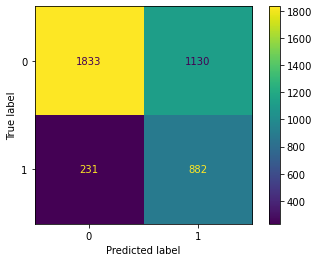

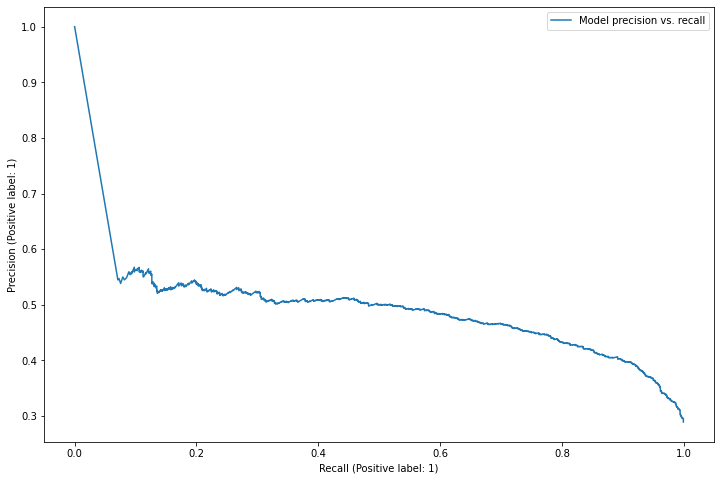

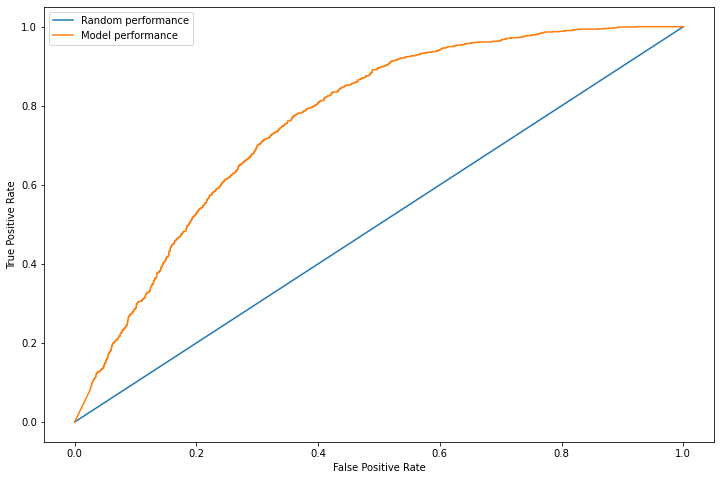

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Adam' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Adam20210603-0955


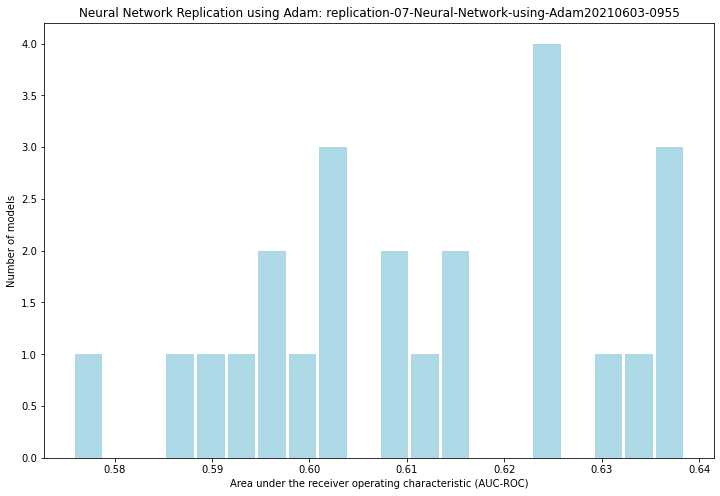

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Adam: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [13]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../NeuralNetworkResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)